In [ ]:
!pip install gym-anytrading yfinance matplotlib pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 2.9 MB/s eta 0:00:00


In [ ]:
import gym_anytrading
import gymnasium as gym
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from gym_anytrading.datasets import STOCKS_GOOGL
from tqdm import trange
import pickle
import warnings
import gym_anytrading.envs
import yfinance as yf
warnings.filterwarnings("ignore", category=DeprecationWarning)



# Importing data files
- For this,  Google stock price dataset from the gym-anytrading library is loaded -> starting from date January 1, 2010
- convert all to lower case (this is to later avoid library keyword issue) and flatten any multi index columns into simple ones

In [ ]:
from gym_anytrading.datasets import STOCKS_GOOGL

df = STOCKS_GOOGL.copy().reset_index(drop=True)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df.columns = df.columns.str.lower()

In [ ]:
#adding date

In [ ]:
df["date"] = pd.bdate_range(start="2010-01-01", periods=len(df))


Ensuring we have all the necessary files

In [ ]:
required_cols = {"date", "open", "high", "low", "close", "volume"}
missing = required_cols.difference(df.columns)
if missing:
    raise ValueError(f" Dataset missing columns: {missing}")


In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume', 'date'], dtype='object')

In [ ]:
df = df[["date", "open", "high", "low", "close", "volume", "adj close"]]


In [ ]:
df.head()

,date,open,high,low,close,volume,adj close
0,2010-01-01,198.528534,199.524521,196.196198,196.946945,3433700,196.946945
1,2010-01-04,196.171173,202.702698,195.195190,202.382385,6202700,202.382385
2,2010-01-05,203.023026,206.136139,202.607605,202.982986,6062500,202.982986
3,2010-01-06,204.544540,206.016022,202.507507,205.405411,5332200,205.405411
4,2010-01-07,206.261261,208.823822,205.555557,208.823822,5291100,208.823822


In [ ]:
df.columns = [col.capitalize() for col in df.columns]


In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj close'], dtype='object')

# Creating the Stock Trading Environment
- First set the window size to 10 - the number of past time steps (days) the agent sees before making a decision
- starts trading period at index - 10 (should match the window size) and end at 300 - run from episodes 10-299
- the stock trading enviornment used is from gym-anytrading (google stock data)

In [ ]:
window_size   = 10
frame_bound   = (window_size, 300)             # follows API rule- refer to documentation

env_raw = gym.make(
    "stocks-v0",
    df=df,
    window_size=window_size,
    frame_bound=frame_bound
)

In [ ]:
print("\n Env created:")
print("   Action space     :", env_raw.action_space)
print("   Observation space:", env_raw.observation_space)
print("   Observation shape:", env_raw.observation_space.shape)
print("   Prices length    :", len(env_raw.unwrapped.prices))
print("   Start tick       :", env_raw.unwrapped._start_tick,
      "| End tick :", env_raw.unwrapped._end_tick)


 Env created:
   Action space     : Discrete(2)
   Observation space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)
   Observation shape: (10, 2)
   Prices length    : 300
   Start tick       : 10 | End tick : 299


The above shows sucessful initialisation

In [ ]:
df

,Date,Open,High,Low,Close,Volume,Adj close
0,2010-01-01,198.528534,199.524521,196.196198,196.946945,3433700,196.946945
1,2010-01-04,196.171173,202.702698,195.195190,202.382385,6202700,202.382385
2,2010-01-05,203.023026,206.136139,202.607605,202.982986,6062500,202.982986
3,2010-01-06,204.544540,206.016022,202.507507,205.405411,5332200,205.405411
4,2010-01-07,206.261261,208.823822,205.555557,208.823822,5291100,208.823822
...,...,...,...,...,...,...,...
2330,2018-12-07,1219.880005,1235.170044,1219.349976,1221.160034,1233300,1221.160034
2331,2018-12-10,1226.000000,1237.400024,1221.420044,1236.750000,1222700,1236.750000
2332,2018-12-11,1244.140015,1257.869995,1240.680054,1256.270020,1429000,1256.270020
2333,2018-12-12,1255.900024,1256.560059,1242.969971,1245.859985,1366500,1245.859985


# Calculating Technical Indicators for Trading Strategy
- This code calculates several popular technical indicators used in stock trading to analyze price trends
- it begins by extracting the closing prices from the datasetthen computes short-term and long-term simple moving averages (SMA) and exponential moving averages (EMA) to understand overall price direction
- use the EMAs to derive the MACD (Moving Average Convergence Divergence)-> this is  a key trend-following momentum indicator
- It also calculates the Bollinger Band width to measure market volatility.
- It computes the Relative Strength Index (RSI) which helps identify overbought or oversold conditions in the market by analyzing average gains and losses over a 14-day period.

In [ ]:
price = df["Close"]

sma_f = price.rolling(20, min_periods=1).mean()
sma_s = price.rolling(50, min_periods=1).mean()
ema12 = price.ewm(span=12, adjust=False).mean()
ema26 = price.ewm(span=26, adjust=False).mean()
macd  = ema12 - ema26
bb_width = 2 * price.rolling(20, min_periods=1).std(ddof=0) / sma_f

delta        = price.diff()
gain         = delta.clip(lower=0)
loss         = -delta.clip(upper=0)
avg_gain_ema = gain.ewm(alpha=1/14, adjust=False).mean()
avg_loss_ema = loss.ewm(alpha=1/14, adjust=False).mean()
rs           = avg_gain_ema / (avg_loss_ema + 1e-9)
rsi          = 100 - 100 / (1 + rs)

Th function encode() takes in a time step (tick) and the current observation (obs) and returns a tuple of discrete features representing the market condition

In [ ]:
def encode(tick: int, obs):
    tri = lambda x: 2 if x > 0 else 0 if x < 0 else 1

    trend   = tri(sma_f.iloc[tick] - sma_s.iloc[tick])
    rsi_bin = 0 if rsi.iloc[tick] < 30 else 2 if rsi.iloc[tick] > 70 else 1
    macd_s  = tri(macd.iloc[tick])
    bb_bin  = pd.qcut(bb_width.iloc[:tick+1], 3, labels=False).iloc[-1]

    delta_p = obs[-1, 0] - obs[-2, 0]
    pos     = tri(delta_p)

    return (trend, rsi_bin, macd_s, bb_bin, pos)
#bb_bin is the Bollinger Band width


1.  Soft Q Learning algorithm with KL-divergence regularization is to encourage exploration and prevent the learned policy from drifting too far from a prior policy.

In [ ]:
ACTIONS  = [0, 1]
alpha    = 0.1
gamma    = 0.99
tau      = 1.0
kl_beta  = 0.01

G        = defaultdict(lambda: np.zeros(len(ACTIONS)))
pi_ref   = np.array([0.5, 0.5])

def softmax_g(state):
    g = G[state]
    p = np.exp(-g / tau)
    return p / p.sum()

def kl_div(p, q):
    return np.sum(p * (np.log(p + 1e-9) - np.log(q + 1e-9)))

# Training

In [ ]:
episodes, month_len = 200, 21
equity_curves, month_rewards = [], []

for ep in trange(episodes, desc="Training G‑Learning"):
    obs, _ = env_raw.reset()
    equity  = [env_raw.unwrapped._total_profit]

    for t in range(month_len):
        s  = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s)
        a  = np.random.choice(ACTIONS, p=pi)

        obs, rew, terminated, truncated, info = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g   = softmax_g(s_next) @ G[s_next]
        reg    = kl_beta * kl_div(pi, pi_ref)

        end_of_month = (t == month_len - 1)
        episode_end  = terminated or truncated

        if end_of_month or episode_end:
            ret   = env_raw.unwrapped._total_profit - 1.0
            if len(equity) > 2:
                sigma = np.std(np.diff(equity[-month_len:])) + 1e-6
            else:
                sigma = 1.0
            reward = ret / sigma - reg

            G[s][a] = (1 - alpha) * G[s][a] + alpha * (reward + gamma * Ea_g)

            month_rewards.append(reward)

        if episode_end:
            break

    equity_curves.append(equity)


Training G‑Learning: 100%|██████████| 200/200 [00:13<00:00, 15.37it/s]


# Understanding Hierarchical Structure of the Code – G-Learning Training Loop

- This code implements a soft Q-learning (G-learning) algorithm with KL-regularized reward shaping for a stock trading environment
- The agent learns over multiple episodes and stimulates about a month of trading (21 steps) and at each time step the agent observes the market state—encoded using technical indicators like SMA, MACD, RSI (above code) and selects an action (hold or buy) based on a softmax policy derived from Q-values.
- so unlikestandard Q-learning, this method encourages exploration by keeping the learned policy close to a reference policy (uniform) using KL-divergence regularization.



# Reward Function


> ret = final_total_profit - 1.0
sigma = np.std(np.diff(equity[-month_len:])) + 1e-6  
reward = ret / sigma - kl_beta * kl_div(pi, pi_ref)


- here ret / sigma normalizes profit by recent price volatility to encourage consistent gains over unstable or risky trades.

In [ ]:
Path("models").mkdir(exist_ok=True)
Path("plots").mkdir(exist_ok=True)

with open("models/g_soft.pkl", "wb") as f:
    pickle.dump({"G": dict(G),
                 "params": dict(alpha=alpha, gamma=gamma,
                                tau=tau, beta=kl_beta)}, f)


✅ Training finished — model & plots saved to ./models and ./plots


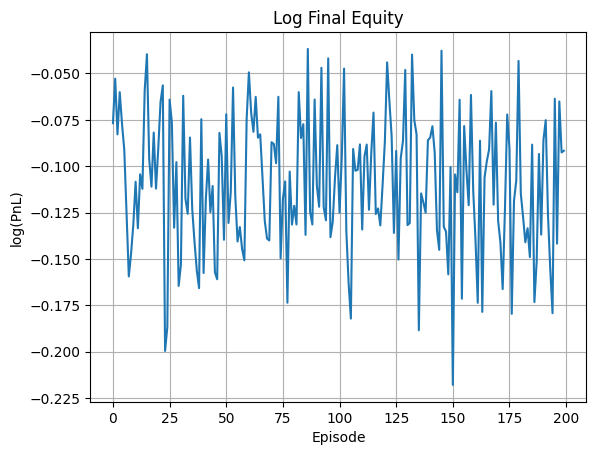

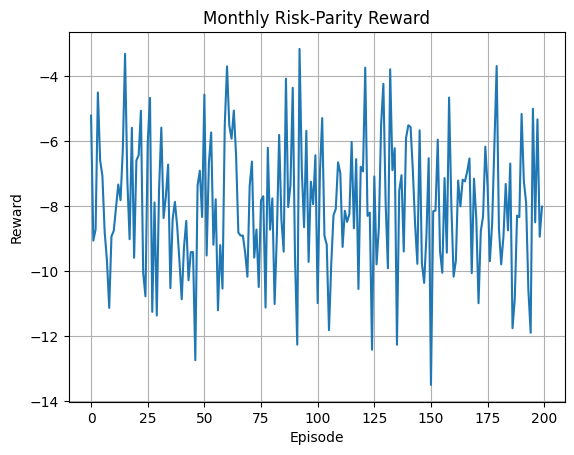

In [ ]:
plt.figure(); plt.plot([np.log(ec[-1]) for ec in equity_curves])
plt.title("Log Final Equity"); plt.xlabel("Episode"); plt.ylabel("log(PnL)"); plt.grid()
plt.savefig("plots/g_equity.png")

plt.figure(); plt.plot(month_rewards)
plt.title("Monthly Risk‑Parity Reward"); plt.xlabel("Episode"); plt.ylabel("Reward"); plt.grid()
plt.savefig("plots/g_rewards.png")

print("\n Training finished — model & plots saved to ./models and ./plots")

# Typical reward range is -2 - +3
- where >1 shows strong performance
(something like reward of 5 is mathematically not possible due to the reward fnc used and highlights model error)
- in our case, rewards often fluctuate between -10 and -5, suggesting the agent is struggling—likely due to high volatility, unstable actions and no profit, Final equity levels are consistently logged in the range -0.13 to -0.075 indicating  net loss of 7.5% to 13%. So even after one month of trading, the agent isn't yet profitable

# Lets try to fix

Changes made:
1. Increased number of training episodes to 500 (2X previous) - more episodes give the agent time to explore and learn from more market situations and stabilise Q-values and encourages more consistent learning.
2. I m also now tracking the rewards to help debug


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

equity_curves, month_rewards = [], []

pbar = tqdm(range(500), desc="Training G‑Learning")
for ep in pbar:
    obs, _ = env_raw.reset()
    equity = [env_raw.unwrapped._total_profit]

    for t in range(month_len):
        s = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s)
        a = np.random.choice(ACTIONS, p=pi)

        obs, rew, terminated, truncated, info = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g   = softmax_g(s_next) @ G[s_next]
        reg    = kl_beta * kl_div(pi, pi_ref)

        end_of_month = (t == month_len - 1)
        episode_end  = terminated or truncated

        if end_of_month or episode_end:
            ret = env_raw.unwrapped._total_profit - 1.0
            if len(equity) > 2:
                sigma = np.std(np.diff(equity[-month_len:])) + 1e-6
            else:
                sigma = 1.0
            reward = ret / sigma - reg

            G[s][a] = (1 - alpha) * G[s][a] + alpha * (reward + gamma * Ea_g)
            month_rewards.append(reward)

        if episode_end:
            break

    equity_curves.append(equity)

    # ✅ Print reward info
    print(f"Episode {ep+1:>3} | Reward: {month_rewards[-1]:>7.4f}")

    # ✅ Update tqdm bar with last reward
    pbar.set_description(f"Ep {ep+1} | R: {month_rewards[-1]:.4f}")

    # ✅ Optional: print average of last 10 rewards
    if len(month_rewards) >= 10:
        avg10 = np.mean(month_rewards[-10:])
        print(f"Avg Reward (last 10): {avg10:.4f}")


Ep 4 | R: -7.2435:   1%|          | 4/500 [00:00<00:33, 14.98it/s]

Episode   1 | Reward: -5.7416
Episode   2 | Reward: -8.9423
Episode   3 | Reward: -11.3293
Episode   4 | Reward: -7.2435


Ep 7 | R: -5.4328:   1%|          | 6/500 [00:00<00:34, 14.52it/s]

Episode   5 | Reward: -8.0330
Episode   6 | Reward: -7.4239
Episode   7 | Reward: -5.4328


Ep 8 | R: -6.7241:   2%|▏         | 8/500 [00:00<00:34, 14.09it/s]

Episode   8 | Reward: -6.7241


Ep 10 | R: -9.8391:   2%|▏         | 10/500 [00:00<00:56,  8.70it/s]

Episode   9 | Reward: -4.3364
Episode  10 | Reward: -9.8391
Avg Reward (last 10): -7.5046


Ep 11 | R: -10.8681:   2%|▏         | 10/500 [00:01<00:56,  8.70it/s]

Episode  11 | Reward: -10.8681
Avg Reward (last 10): -8.0173


Ep 12 | R: -7.9742:   2%|▏         | 12/500 [00:01<01:16,  6.42it/s]

Episode  12 | Reward: -7.9742
Avg Reward (last 10): -7.9204


Ep 13 | R: -6.4501:   3%|▎         | 13/500 [00:01<01:27,  5.59it/s]

Episode  13 | Reward: -6.4501
Avg Reward (last 10): -7.4325


Ep 15 | R: -8.6523:   3%|▎         | 15/500 [00:02<01:32,  5.26it/s]

Episode  14 | Reward: -2.3261
Avg Reward (last 10): -6.9408
Episode  15 | Reward: -8.6523
Avg Reward (last 10): -7.0027


Ep 19 | R: -5.2173:   4%|▍         | 19/500 [00:02<00:53,  8.99it/s]

Episode  16 | Reward: -9.6584
Avg Reward (last 10): -7.2262
Episode  17 | Reward: -8.0868
Avg Reward (last 10): -7.4916
Episode  18 | Reward: -3.2504
Avg Reward (last 10): -7.1442
Episode  19 | Reward: -5.2173
Avg Reward (last 10): -7.2323


Ep 22 | R: -9.2999:   4%|▍         | 21/500 [00:02<00:44, 10.80it/s]

Episode  20 | Reward: -5.3279
Avg Reward (last 10): -6.7812
Episode  21 | Reward: -7.7291
Avg Reward (last 10): -6.4673
Episode  22 | Reward: -9.2999
Avg Reward (last 10): -6.5998


Ep 26 | R: -6.4860:   5%|▌         | 25/500 [00:02<00:38, 12.31it/s] 

Episode  23 | Reward: -9.5826
Avg Reward (last 10): -6.9131
Episode  24 | Reward: -6.1010
Avg Reward (last 10): -7.2906
Episode  25 | Reward: -10.9771
Avg Reward (last 10): -7.5230
Episode  26 | Reward: -6.4860
Avg Reward (last 10): -7.2058


Ep 30 | R: -4.6647:   6%|▌         | 29/500 [00:03<00:31, 15.17it/s]

Episode  27 | Reward: -8.8342
Avg Reward (last 10): -7.2805
Episode  28 | Reward: -5.1569
Avg Reward (last 10): -7.4712
Episode  29 | Reward: -9.1602
Avg Reward (last 10): -7.8655
Episode  30 | Reward: -4.6647
Avg Reward (last 10): -7.7992


Ep 34 | R: -8.6682:   7%|▋         | 33/500 [00:03<00:28, 16.58it/s]

Episode  31 | Reward: -9.8353
Avg Reward (last 10): -8.0098
Episode  32 | Reward: -12.2894
Avg Reward (last 10): -8.3087
Episode  33 | Reward: -8.9425
Avg Reward (last 10): -8.2447
Episode  34 | Reward: -8.6682
Avg Reward (last 10): -8.5014


Ep 38 | R: -10.0993:   7%|▋         | 37/500 [00:03<00:26, 17.51it/s]

Episode  35 | Reward: -10.6542
Avg Reward (last 10): -8.4692
Episode  36 | Reward: -7.3453
Avg Reward (last 10): -8.5551
Episode  37 | Reward: -9.3155
Avg Reward (last 10): -8.6032
Episode  38 | Reward: -10.0993
Avg Reward (last 10): -9.0975


Ep 41 | R: -9.6762:   8%|▊         | 41/500 [00:03<00:30, 15.09it/s]

Episode  39 | Reward: -6.3400
Avg Reward (last 10): -8.8154
Episode  40 | Reward: -7.9283
Avg Reward (last 10): -9.1418
Episode  41 | Reward: -9.6762
Avg Reward (last 10): -9.1259


Ep 45 | R: -7.0223:   9%|▉         | 45/500 [00:03<00:27, 16.71it/s]

Episode  42 | Reward: -9.2325
Avg Reward (last 10): -8.8202
Episode  43 | Reward: -9.8775
Avg Reward (last 10): -8.9137
Episode  44 | Reward: -11.9229
Avg Reward (last 10): -9.2392
Episode  45 | Reward: -7.0223
Avg Reward (last 10): -8.8760


Ep 49 | R: -8.5044:   9%|▉         | 47/500 [00:04<00:26, 17.30it/s]

Episode  46 | Reward: -7.0717
Avg Reward (last 10): -8.8486
Episode  47 | Reward: -6.6669
Avg Reward (last 10): -8.5838
Episode  48 | Reward: -6.9821
Avg Reward (last 10): -8.2720
Episode  49 | Reward: -8.5044
Avg Reward (last 10): -8.4885


Ep 53 | R: -9.6030:  11%|█         | 53/500 [00:04<00:24, 18.47it/s]

Episode  50 | Reward: -11.2425
Avg Reward (last 10): -8.8199
Episode  51 | Reward: -7.1627
Avg Reward (last 10): -8.5686
Episode  52 | Reward: -8.6651
Avg Reward (last 10): -8.5118
Episode  53 | Reward: -9.6030
Avg Reward (last 10): -8.4844
Episode  54 | Reward: -4.6311


Ep 57 | R: -8.2123:  11%|█▏        | 57/500 [00:04<00:24, 18.24it/s]

Avg Reward (last 10): -7.7552
Episode  55 | Reward: -10.9699
Avg Reward (last 10): -8.1499
Episode  56 | Reward: -8.7909
Avg Reward (last 10): -8.3219
Episode  57 | Reward: -8.2123
Avg Reward (last 10): -8.4764


Ep 61 | R: -7.2137:  12%|█▏        | 61/500 [00:04<00:24, 18.22it/s]

Episode  58 | Reward: -8.7337
Avg Reward (last 10): -8.6516
Episode  59 | Reward: -7.8077
Avg Reward (last 10): -8.5819
Episode  60 | Reward: -9.0664
Avg Reward (last 10): -8.3643
Episode  61 | Reward: -7.2137
Avg Reward (last 10): -8.3694


Ep 65 | R: -10.4891:  13%|█▎        | 65/500 [00:05<00:24, 17.93it/s]

Episode  62 | Reward: -5.0332
Avg Reward (last 10): -8.0062
Episode  63 | Reward: -8.7218
Avg Reward (last 10): -7.9181
Episode  64 | Reward: -8.3573
Avg Reward (last 10): -8.2907
Episode  65 | Reward: -10.4891
Avg Reward (last 10): -8.2426


Ep 69 | R: -7.8712:  14%|█▍        | 69/500 [00:05<00:25, 17.22it/s]

Episode  66 | Reward: -9.5059
Avg Reward (last 10): -8.3141
Episode  67 | Reward: -5.5040
Avg Reward (last 10): -8.0433
Episode  68 | Reward: -9.0018
Avg Reward (last 10): -8.0701
Episode  69 | Reward: -7.8712
Avg Reward (last 10): -8.0765


Ep 72 | R: -5.7446:  14%|█▍        | 71/500 [00:05<00:29, 14.63it/s]

Episode  70 | Reward: -10.0019
Avg Reward (last 10): -8.1700
Episode  71 | Reward: -8.3070
Avg Reward (last 10): -8.2793
Episode  72 | Reward: -5.7446
Avg Reward (last 10): -8.3505


Ep 76 | R: -8.6256:  15%|█▌        | 75/500 [00:05<00:26, 16.12it/s] 

Episode  73 | Reward: -6.1540
Avg Reward (last 10): -8.0937
Episode  74 | Reward: -5.7935
Avg Reward (last 10): -7.8373
Episode  75 | Reward: -10.0531
Avg Reward (last 10): -7.7937
Episode  76 | Reward: -8.6256
Avg Reward (last 10): -7.7057


Ep 80 | R: -5.8777:  16%|█▌        | 79/500 [00:05<00:24, 17.12it/s]

Episode  77 | Reward: -6.5648
Avg Reward (last 10): -7.8118
Episode  78 | Reward: -8.9402
Avg Reward (last 10): -7.8056
Episode  79 | Reward: -6.2544
Avg Reward (last 10): -7.6439
Episode  80 | Reward: -5.8777
Avg Reward (last 10): -7.2315


Ep 84 | R: -5.7122:  17%|█▋        | 83/500 [00:06<00:23, 17.83it/s]

Episode  81 | Reward: -9.8365
Avg Reward (last 10): -7.3844
Episode  82 | Reward: -5.9570
Avg Reward (last 10): -7.4057
Episode  83 | Reward: -9.4540
Avg Reward (last 10): -7.7357
Episode  84 | Reward: -5.7122
Avg Reward (last 10): -7.7276


Ep 87 | R: -9.9206:  17%|█▋        | 87/500 [00:06<00:24, 17.20it/s]

Episode  85 | Reward: -8.3136
Avg Reward (last 10): -7.5536
Episode  86 | Reward: -8.9794
Avg Reward (last 10): -7.5890
Episode  87 | Reward: -9.9206
Avg Reward (last 10): -7.9245


Ep 91 | R: -11.1658:  18%|█▊        | 91/500 [00:06<00:26, 15.50it/s]

Episode  88 | Reward: -8.1572
Avg Reward (last 10): -7.8462
Episode  89 | Reward: -9.2081
Avg Reward (last 10): -8.1416
Episode  90 | Reward: -9.0303
Avg Reward (last 10): -8.4569
Episode  91 | Reward: -11.1658
Avg Reward (last 10): -8.5898


Ep 95 | R: -10.1443:  19%|█▉        | 95/500 [00:06<00:24, 16.80it/s]

Episode  92 | Reward: -6.1813
Avg Reward (last 10): -8.6122
Episode  93 | Reward: -6.6387
Avg Reward (last 10): -8.3307
Episode  94 | Reward: -8.8905
Avg Reward (last 10): -8.6485
Episode  95 | Reward: -10.1443
Avg Reward (last 10): -8.8316


Ep 99 | R: -5.9567:  20%|█▉        | 99/500 [00:07<00:22, 17.80it/s]

Episode  96 | Reward: -6.4550
Avg Reward (last 10): -8.5792
Episode  97 | Reward: -9.4832
Avg Reward (last 10): -8.5354
Episode  98 | Reward: -6.3268
Avg Reward (last 10): -8.3524
Episode  99 | Reward: -5.9567
Avg Reward (last 10): -8.0273


Ep 103 | R: -9.5111:  21%|██        | 103/500 [00:07<00:23, 17.05it/s]

Episode 100 | Reward: -10.3946
Avg Reward (last 10): -8.1637
Episode 101 | Reward: -9.3109
Avg Reward (last 10): -7.9782
Episode 102 | Reward: -12.1623
Avg Reward (last 10): -8.5763
Episode 103 | Reward: -9.5111
Avg Reward (last 10): -8.8635


Ep 107 | R: -8.6257:  21%|██▏       | 107/500 [00:07<00:25, 15.39it/s]

Episode 104 | Reward: -8.9414
Avg Reward (last 10): -8.8686
Episode 105 | Reward: -7.7118
Avg Reward (last 10): -8.6254
Episode 106 | Reward: -7.0749
Avg Reward (last 10): -8.6874
Episode 107 | Reward: -8.6257
Avg Reward (last 10): -8.6016


Ep 111 | R: -6.0035:  22%|██▏       | 111/500 [00:07<00:23, 16.57it/s]

Episode 108 | Reward: -10.5436
Avg Reward (last 10): -9.0233
Episode 109 | Reward: -8.8940
Avg Reward (last 10): -9.3170
Episode 110 | Reward: -9.5613
Avg Reward (last 10): -9.2337
Episode 111 | Reward: -6.0035
Avg Reward (last 10): -8.9029


Ep 115 | R: -6.3711:  23%|██▎       | 115/500 [00:08<00:22, 17.37it/s]

Episode 112 | Reward: -8.6823
Avg Reward (last 10): -8.5549
Episode 113 | Reward: -6.9821
Avg Reward (last 10): -8.3021
Episode 114 | Reward: -8.8071
Avg Reward (last 10): -8.2886
Episode 115 | Reward: -6.3711
Avg Reward (last 10): -8.1545


Ep 119 | R: -12.3384:  24%|██▍       | 119/500 [00:08<00:21, 17.43it/s]

Episode 116 | Reward: -7.6718
Avg Reward (last 10): -8.2142
Episode 117 | Reward: -5.7896
Avg Reward (last 10): -7.9306
Episode 118 | Reward: -7.6189
Avg Reward (last 10): -7.6382
Episode 119 | Reward: -12.3384
Avg Reward (last 10): -7.9826


Ep 122 | R: -6.7978:  24%|██▍       | 121/500 [00:08<00:26, 14.28it/s]

Episode 120 | Reward: -10.7572
Avg Reward (last 10): -8.1022
Episode 121 | Reward: -9.9726
Avg Reward (last 10): -8.4991
Episode 122 | Reward: -6.7978
Avg Reward (last 10): -8.3107


Ep 126 | R: -9.2985:  25%|██▌       | 125/500 [00:08<00:23, 15.94it/s]

Episode 123 | Reward: -4.3176
Avg Reward (last 10): -8.0442
Episode 124 | Reward: -7.7426
Avg Reward (last 10): -7.9377
Episode 125 | Reward: -9.3571
Avg Reward (last 10): -8.2363
Episode 126 | Reward: -9.2985
Avg Reward (last 10): -8.3990


Ep 130 | R: -8.1578:  26%|██▌       | 129/500 [00:08<00:21, 17.05it/s]

Episode 127 | Reward: -6.3779
Avg Reward (last 10): -8.4578
Episode 128 | Reward: -11.0021
Avg Reward (last 10): -8.7962
Episode 129 | Reward: -8.5548
Avg Reward (last 10): -8.4178
Episode 130 | Reward: -8.1578
Avg Reward (last 10): -8.1579


Ep 134 | R: -7.6670:  27%|██▋       | 133/500 [00:09<00:20, 17.73it/s] 

Episode 131 | Reward: -7.6539
Avg Reward (last 10): -7.9260
Episode 132 | Reward: -9.0942
Avg Reward (last 10): -8.1556
Episode 133 | Reward: -11.0555
Avg Reward (last 10): -8.8294
Episode 134 | Reward: -7.6670
Avg Reward (last 10): -8.8219


Ep 137 | R: -10.6315:  27%|██▋       | 137/500 [00:09<00:24, 14.61it/s]

Episode 135 | Reward: -7.5525
Avg Reward (last 10): -8.6414
Episode 136 | Reward: -8.6547
Avg Reward (last 10): -8.5770
Episode 137 | Reward: -10.6315
Avg Reward (last 10): -9.0024


Ep 141 | R: -10.0135:  28%|██▊       | 141/500 [00:09<00:21, 16.35it/s]

Episode 138 | Reward: -8.0598
Avg Reward (last 10): -8.7082
Episode 139 | Reward: -9.5539
Avg Reward (last 10): -8.8081
Episode 140 | Reward: -9.5064
Avg Reward (last 10): -8.9429
Episode 141 | Reward: -10.0135
Avg Reward (last 10): -9.1789


Ep 145 | R: -10.8232:  29%|██▉       | 145/500 [00:09<00:20, 17.33it/s]

Episode 142 | Reward: -7.1411
Avg Reward (last 10): -8.9836
Episode 143 | Reward: -6.8247
Avg Reward (last 10): -8.5605
Episode 144 | Reward: -9.7619
Avg Reward (last 10): -8.7700
Episode 145 | Reward: -10.8232
Avg Reward (last 10): -9.0971


Ep 149 | R: -7.2985:  30%|██▉       | 149/500 [00:10<00:19, 17.78it/s]

Episode 146 | Reward: -3.6892
Avg Reward (last 10): -8.6005
Episode 147 | Reward: -7.6665
Avg Reward (last 10): -8.3040
Episode 148 | Reward: -7.3569
Avg Reward (last 10): -8.2337
Episode 149 | Reward: -7.2985
Avg Reward (last 10): -8.0082


Ep 153 | R: -7.7650:  31%|███       | 153/500 [00:10<00:19, 17.88it/s]

Episode 150 | Reward: -4.1429
Avg Reward (last 10): -7.4718
Episode 151 | Reward: -10.0336
Avg Reward (last 10): -7.4738
Episode 152 | Reward: -10.5561
Avg Reward (last 10): -7.8153
Episode 153 | Reward: -7.7650
Avg Reward (last 10): -7.9094


Ep 157 | R: -7.5002:  31%|███▏      | 157/500 [00:10<00:21, 15.61it/s]

Episode 154 | Reward: -6.9291
Avg Reward (last 10): -7.6261
Episode 155 | Reward: -7.9156
Avg Reward (last 10): -7.3353
Episode 156 | Reward: -9.7023
Avg Reward (last 10): -7.9367
Episode 157 | Reward: -7.5002
Avg Reward (last 10): -7.9200


Ep 161 | R: -5.2665:  32%|███▏      | 161/500 [00:10<00:20, 16.71it/s]

Episode 158 | Reward: -4.3221
Avg Reward (last 10): -7.6165
Episode 159 | Reward: -11.6315
Avg Reward (last 10): -8.0498
Episode 160 | Reward: -10.5911
Avg Reward (last 10): -8.6947
Episode 161 | Reward: -5.2665
Avg Reward (last 10): -8.2180


Ep 165 | R: -8.2571:  33%|███▎      | 165/500 [00:11<00:19, 17.51it/s]

Episode 162 | Reward: -10.0508
Avg Reward (last 10): -8.1674
Episode 163 | Reward: -7.8845
Avg Reward (last 10): -8.1794
Episode 164 | Reward: -4.5531
Avg Reward (last 10): -7.9418
Episode 165 | Reward: -8.2571
Avg Reward (last 10): -7.9759


Ep 167 | R: -9.4824:  33%|███▎      | 167/500 [00:11<00:18, 17.73it/s]

Episode 166 | Reward: -12.2852
Avg Reward (last 10): -8.2342
Episode 167 | Reward: -9.4824
Avg Reward (last 10): -8.4324


Ep 169 | R: -6.2970:  34%|███▍      | 169/500 [00:11<00:24, 13.45it/s]

Episode 168 | Reward: -5.2182
Avg Reward (last 10): -8.5220
Episode 169 | Reward: -6.2970
Avg Reward (last 10): -7.9886
Episode 170 | Reward: -9.9151


Ep 173 | R: -8.7123:  35%|███▍      | 173/500 [00:11<00:24, 13.55it/s]

Avg Reward (last 10): -7.9210
Episode 171 | Reward: -6.4251
Avg Reward (last 10): -8.0368
Episode 172 | Reward: -6.3754
Avg Reward (last 10): -7.6693
Episode 173 | Reward: -8.7123
Avg Reward (last 10): -7.7521


Ep 177 | R: -7.5183:  35%|███▌      | 177/500 [00:11<00:20, 15.56it/s]

Episode 174 | Reward: -4.1347
Avg Reward (last 10): -7.7102
Episode 175 | Reward: -7.8522
Avg Reward (last 10): -7.6698
Episode 176 | Reward: -10.9798
Avg Reward (last 10): -7.5392
Episode 177 | Reward: -7.5183
Avg Reward (last 10): -7.3428


Ep 180 | R: -5.5480:  36%|███▌      | 179/500 [00:12<00:22, 14.52it/s]

Episode 178 | Reward: -8.9952
Avg Reward (last 10): -7.7205
Episode 179 | Reward: -9.8408
Avg Reward (last 10): -8.0749
Episode 180 | Reward: -5.5480
Avg Reward (last 10): -7.6382


Ep 182 | R: -2.9209:  36%|███▌      | 181/500 [00:12<00:23, 13.78it/s]

Episode 181 | Reward: -6.5201
Avg Reward (last 10): -7.6477
Episode 182 | Reward: -2.9209
Avg Reward (last 10): -7.3022


Ep 185 | R: -8.4057:  37%|███▋      | 183/500 [00:12<00:27, 11.49it/s]

Episode 183 | Reward: -8.6685
Avg Reward (last 10): -7.2978
Episode 184 | Reward: -6.1408
Avg Reward (last 10): -7.4985
Episode 185 | Reward: -8.4057
Avg Reward (last 10): -7.5538


Ep 188 | R: -10.6467:  37%|███▋      | 187/500 [00:12<00:26, 11.69it/s]

Episode 186 | Reward: -6.5075
Avg Reward (last 10): -7.1066
Episode 187 | Reward: -8.9598
Avg Reward (last 10): -7.2507
Episode 188 | Reward: -10.6467
Avg Reward (last 10): -7.4159


Ep 191 | R: -10.6653:  38%|███▊      | 191/500 [00:13<00:24, 12.70it/s]

Episode 189 | Reward: -8.0008
Avg Reward (last 10): -7.2319
Episode 190 | Reward: -6.6070
Avg Reward (last 10): -7.3378
Episode 191 | Reward: -10.6653
Avg Reward (last 10): -7.7523


Ep 194 | R: -8.1279:  39%|███▊      | 193/500 [00:13<00:24, 12.65it/s]

Episode 192 | Reward: -9.0800
Avg Reward (last 10): -8.3682
Episode 193 | Reward: -9.0362
Avg Reward (last 10): -8.4050
Episode 194 | Reward: -8.1279
Avg Reward (last 10): -8.6037


Ep 197 | R: -5.8000:  39%|███▉      | 197/500 [00:13<00:28, 10.73it/s]

Episode 195 | Reward: -8.9229
Avg Reward (last 10): -8.6554
Episode 196 | Reward: -10.3585
Avg Reward (last 10): -9.0405
Episode 197 | Reward: -5.8000
Avg Reward (last 10): -8.7245


Ep 200 | R: -8.3166:  40%|███▉      | 199/500 [00:13<00:27, 10.96it/s]

Episode 198 | Reward: -8.5192
Avg Reward (last 10): -8.5118
Episode 199 | Reward: -8.8537
Avg Reward (last 10): -8.5971
Episode 200 | Reward: -8.3166
Avg Reward (last 10): -8.7680


Ep 203 | R: -8.5870:  41%|████      | 203/500 [00:14<00:25, 11.44it/s]

Episode 201 | Reward: -8.3485
Avg Reward (last 10): -8.5364
Episode 202 | Reward: -9.7509
Avg Reward (last 10): -8.6035
Episode 203 | Reward: -8.5870
Avg Reward (last 10): -8.5585


Ep 205 | R: -10.9183:  41%|████      | 205/500 [00:14<00:29,  9.84it/s]

Episode 204 | Reward: -7.6036
Avg Reward (last 10): -8.5061
Episode 205 | Reward: -10.9183
Avg Reward (last 10): -8.7057


Ep 209 | R: -8.8361:  41%|████▏     | 207/500 [00:14<00:28, 10.12it/s]

Episode 206 | Reward: -9.8691
Avg Reward (last 10): -8.6567
Episode 207 | Reward: -7.5667
Avg Reward (last 10): -8.8334
Episode 208 | Reward: -9.7906
Avg Reward (last 10): -8.9605
Episode 209 | Reward: -8.8361
Avg Reward (last 10): -8.9588


Ep 213 | R: -5.1945:  43%|████▎     | 213/500 [00:15<00:20, 14.19it/s]

Episode 210 | Reward: -9.2980
Avg Reward (last 10): -9.0569
Episode 211 | Reward: -9.1061
Avg Reward (last 10): -9.1327
Episode 212 | Reward: -5.9144
Avg Reward (last 10): -8.7490
Episode 213 | Reward: -5.1945
Avg Reward (last 10): -8.4098


Ep 217 | R: -7.2467:  43%|████▎     | 217/500 [00:15<00:18, 15.67it/s]

Episode 214 | Reward: -12.3526
Avg Reward (last 10): -8.8847
Episode 215 | Reward: -7.6311
Avg Reward (last 10): -8.5559
Episode 216 | Reward: -9.3632
Avg Reward (last 10): -8.5053
Episode 217 | Reward: -7.2467
Avg Reward (last 10): -8.4733


Ep 220 | R: -8.1614:  44%|████▍     | 219/500 [00:15<00:20, 13.99it/s]

Episode 218 | Reward: -10.6745
Avg Reward (last 10): -8.5617
Episode 219 | Reward: -5.6890
Avg Reward (last 10): -8.2470
Episode 220 | Reward: -8.1614
Avg Reward (last 10): -8.1333


Ep 224 | R: -5.8268:  45%|████▍     | 223/500 [00:15<00:18, 15.38it/s]

Episode 221 | Reward: -10.5112
Avg Reward (last 10): -8.2739
Episode 222 | Reward: -9.8025
Avg Reward (last 10): -8.6627
Episode 223 | Reward: -9.8844
Avg Reward (last 10): -9.1317
Episode 224 | Reward: -5.8268
Avg Reward (last 10): -8.4791


Ep 228 | R: -7.3999:  45%|████▌     | 227/500 [00:15<00:16, 16.12it/s]

Episode 225 | Reward: -8.2223
Avg Reward (last 10): -8.5382
Episode 226 | Reward: -5.7447
Avg Reward (last 10): -8.1763
Episode 227 | Reward: -7.3742
Avg Reward (last 10): -8.1891
Episode 228 | Reward: -7.3999
Avg Reward (last 10): -7.8616


Ep 232 | R: -7.7041:  46%|████▌     | 231/500 [00:16<00:16, 16.52it/s]

Episode 229 | Reward: -10.1861
Avg Reward (last 10): -8.3113
Episode 230 | Reward: -8.6991
Avg Reward (last 10): -8.3651
Episode 231 | Reward: -7.8556
Avg Reward (last 10): -8.0996
Episode 232 | Reward: -7.7041
Avg Reward (last 10): -7.8897


Ep 235 | R: -7.0356:  47%|████▋     | 235/500 [00:16<00:17, 14.97it/s]

Episode 233 | Reward: -11.0608
Avg Reward (last 10): -8.0074
Episode 234 | Reward: -8.3589
Avg Reward (last 10): -8.2606
Episode 235 | Reward: -7.0356
Avg Reward (last 10): -8.1419


Ep 239 | R: -5.0079:  48%|████▊     | 239/500 [00:16<00:16, 15.67it/s]

Episode 236 | Reward: -11.5581
Avg Reward (last 10): -8.7232
Episode 237 | Reward: -9.5208
Avg Reward (last 10): -8.9379
Episode 238 | Reward: -9.5750
Avg Reward (last 10): -9.1554
Episode 239 | Reward: -5.0079
Avg Reward (last 10): -8.6376


Ep 243 | R: -9.1095:  49%|████▊     | 243/500 [00:16<00:15, 16.69it/s]

Episode 240 | Reward: -10.1133
Avg Reward (last 10): -8.7790
Episode 241 | Reward: -9.2132
Avg Reward (last 10): -8.9148
Episode 242 | Reward: -7.6206
Avg Reward (last 10): -8.9064
Episode 243 | Reward: -9.1095
Avg Reward (last 10): -8.7113


Ep 247 | R: -8.9597:  49%|████▉     | 247/500 [00:17<00:14, 17.54it/s]

Episode 244 | Reward: -8.6975
Avg Reward (last 10): -8.7452
Episode 245 | Reward: -8.0073
Avg Reward (last 10): -8.8423
Episode 246 | Reward: -6.2981
Avg Reward (last 10): -8.3163
Episode 247 | Reward: -8.9597
Avg Reward (last 10): -8.2602


Ep 251 | R: -7.1165:  50%|█████     | 251/500 [00:17<00:14, 17.51it/s]

Episode 248 | Reward: -11.2445
Avg Reward (last 10): -8.4272
Episode 249 | Reward: -8.4861
Avg Reward (last 10): -8.7750
Episode 250 | Reward: -7.5311
Avg Reward (last 10): -8.5168
Episode 251 | Reward: -7.1165
Avg Reward (last 10): -8.3071


Ep 255 | R: -5.7044:  51%|█████     | 255/500 [00:17<00:15, 15.73it/s]

Episode 252 | Reward: -7.8505
Avg Reward (last 10): -8.3301
Episode 253 | Reward: -9.8434
Avg Reward (last 10): -8.4035
Episode 254 | Reward: -8.3356
Avg Reward (last 10): -8.3673
Episode 255 | Reward: -5.7044
Avg Reward (last 10): -8.1370


Ep 259 | R: -8.7521:  52%|█████▏    | 259/500 [00:17<00:14, 16.25it/s]

Episode 256 | Reward: -8.3155
Avg Reward (last 10): -8.3387
Episode 257 | Reward: -7.9392
Avg Reward (last 10): -8.2367
Episode 258 | Reward: -5.0284
Avg Reward (last 10): -7.6151
Episode 259 | Reward: -8.7521
Avg Reward (last 10): -7.6417


Ep 261 | R: -8.4662:  52%|█████▏    | 261/500 [00:18<00:16, 14.67it/s]

Episode 260 | Reward: -11.8304
Avg Reward (last 10): -8.0716
Episode 261 | Reward: -8.4662
Avg Reward (last 10): -8.2066


Ep 262 | R: -6.2795:  52%|█████▏    | 261/500 [00:18<00:16, 14.67it/s]

Episode 262 | Reward: -6.2795
Avg Reward (last 10): -8.0495


Ep 264 | R: -8.9691:  53%|█████▎    | 263/500 [00:18<00:24,  9.86it/s]

Episode 263 | Reward: -6.0500
Avg Reward (last 10): -7.6701
Episode 264 | Reward: -8.9691
Avg Reward (last 10): -7.7335


Ep 266 | R: -7.2718:  53%|█████▎    | 265/500 [00:18<00:24,  9.66it/s]

Episode 265 | Reward: -7.4824
Avg Reward (last 10): -7.9113
Episode 266 | Reward: -7.2718
Avg Reward (last 10): -7.8069


Ep 268 | R: -5.1986:  53%|█████▎    | 267/500 [00:19<00:30,  7.63it/s]

Episode 267 | Reward: -7.0184
Avg Reward (last 10): -7.7148
Episode 268 | Reward: -5.1986


Ep 269 | R: -13.4596:  54%|█████▍    | 269/500 [00:19<00:31,  7.38it/s]

Avg Reward (last 10): -7.7319
Episode 269 | Reward: -13.4596
Avg Reward (last 10): -8.2026


Ep 271 | R: -9.3947:  54%|█████▍    | 271/500 [00:19<00:33,  6.79it/s]

Episode 270 | Reward: -5.1908
Avg Reward (last 10): -7.5386
Episode 271 | Reward: -9.3947
Avg Reward (last 10): -7.6315


Ep 273 | R: -7.5626:  55%|█████▍    | 273/500 [00:19<00:28,  7.91it/s]

Episode 272 | Reward: -5.2588
Avg Reward (last 10): -7.5294
Episode 273 | Reward: -7.5626
Avg Reward (last 10): -7.6807


Ep 277 | R: -5.5938:  55%|█████▌    | 276/500 [00:20<00:21, 10.22it/s]

Episode 274 | Reward: -6.6442
Avg Reward (last 10): -7.4482
Episode 275 | Reward: -9.0796
Avg Reward (last 10): -7.6079
Episode 276 | Reward: -7.0128
Avg Reward (last 10): -7.5820
Episode 277 | Reward: -5.5938
Avg Reward (last 10): -7.4396


Ep 281 | R: -5.4596:  56%|█████▌    | 280/500 [00:20<00:16, 13.46it/s] 

Episode 278 | Reward: -6.9753
Avg Reward (last 10): -7.6172
Episode 279 | Reward: -3.6628
Avg Reward (last 10): -6.6376
Episode 280 | Reward: -11.1288
Avg Reward (last 10): -7.2314
Episode 281 | Reward: -5.4596
Avg Reward (last 10): -6.8378


Ep 285 | R: -7.7104:  57%|█████▋    | 284/500 [00:20<00:15, 13.75it/s] 

Episode 282 | Reward: -8.2893
Avg Reward (last 10): -7.1409
Episode 283 | Reward: -5.0248
Avg Reward (last 10): -6.8871
Episode 284 | Reward: -11.0197
Avg Reward (last 10): -7.3247
Episode 285 | Reward: -7.7104
Avg Reward (last 10): -7.1877


Ep 289 | R: -12.1995:  58%|█████▊    | 288/500 [00:20<00:13, 15.73it/s]

Episode 286 | Reward: -6.4581
Avg Reward (last 10): -7.1323
Episode 287 | Reward: -6.0737
Avg Reward (last 10): -7.1803
Episode 288 | Reward: -11.4639
Avg Reward (last 10): -7.6291
Episode 289 | Reward: -12.1995
Avg Reward (last 10): -8.4828


Ep 293 | R: -6.2436:  58%|█████▊    | 292/500 [00:21<00:12, 16.67it/s]

Episode 290 | Reward: -10.6668
Avg Reward (last 10): -8.4366
Episode 291 | Reward: -8.2897
Avg Reward (last 10): -8.7196
Episode 292 | Reward: -8.3085
Avg Reward (last 10): -8.7215
Episode 293 | Reward: -6.2436
Avg Reward (last 10): -8.8434


Ep 297 | R: -8.1974:  59%|█████▉    | 296/500 [00:21<00:11, 17.05it/s]

Episode 294 | Reward: -10.3513
Avg Reward (last 10): -8.7766
Episode 295 | Reward: -7.1064
Avg Reward (last 10): -8.7162
Episode 296 | Reward: -8.5291
Avg Reward (last 10): -8.9232
Episode 297 | Reward: -8.1974
Avg Reward (last 10): -9.1356


Ep 301 | R: -10.3905:  60%|██████    | 300/500 [00:21<00:13, 15.37it/s]

Episode 298 | Reward: -9.1410
Avg Reward (last 10): -8.9033
Episode 299 | Reward: -8.9429
Avg Reward (last 10): -8.5777
Episode 300 | Reward: -6.0500
Avg Reward (last 10): -8.1160
Episode 301 | Reward: -10.3905
Avg Reward (last 10): -8.3261


Ep 305 | R: -9.4508:  61%|██████    | 304/500 [00:21<00:11, 16.42it/s] 

Episode 302 | Reward: -9.3354
Avg Reward (last 10): -8.4288
Episode 303 | Reward: -9.2473
Avg Reward (last 10): -8.7291
Episode 304 | Reward: -10.7377
Avg Reward (last 10): -8.7678
Episode 305 | Reward: -9.4508
Avg Reward (last 10): -9.0022


Ep 309 | R: -11.4396:  62%|██████▏   | 308/500 [00:22<00:11, 16.46it/s]

Episode 306 | Reward: -9.5590
Avg Reward (last 10): -9.1052
Episode 307 | Reward: -2.3313
Avg Reward (last 10): -8.5186
Episode 308 | Reward: -7.4526
Avg Reward (last 10): -8.3498
Episode 309 | Reward: -11.4396
Avg Reward (last 10): -8.5994


Ep 312 | R: -9.4350:  62%|██████▏   | 312/500 [00:22<00:11, 16.92it/s]

Episode 310 | Reward: -5.9554
Avg Reward (last 10): -8.5900
Episode 311 | Reward: -6.2183
Avg Reward (last 10): -8.1727
Episode 312 | Reward: -9.4350
Avg Reward (last 10): -8.1827


Ep 316 | R: -9.9718:  63%|██████▎   | 316/500 [00:22<00:11, 15.43it/s]

Episode 313 | Reward: -9.0068
Avg Reward (last 10): -8.1587
Episode 314 | Reward: -7.9275
Avg Reward (last 10): -7.8776
Episode 315 | Reward: -9.1340
Avg Reward (last 10): -7.8459
Episode 316 | Reward: -9.9718
Avg Reward (last 10): -7.8872


Ep 320 | R: -6.5479:  64%|██████▍   | 320/500 [00:22<00:11, 16.15it/s]

Episode 317 | Reward: -4.7081
Avg Reward (last 10): -8.1249
Episode 318 | Reward: -6.7251
Avg Reward (last 10): -8.0522
Episode 319 | Reward: -8.8881
Avg Reward (last 10): -7.7970
Episode 320 | Reward: -6.5479
Avg Reward (last 10): -7.8563


Ep 324 | R: -7.3706:  65%|██████▍   | 324/500 [00:23<00:10, 16.35it/s]

Episode 321 | Reward: -9.2884
Avg Reward (last 10): -8.1633
Episode 322 | Reward: -7.0814
Avg Reward (last 10): -7.9279
Episode 323 | Reward: -9.7099
Avg Reward (last 10): -7.9982
Episode 324 | Reward: -7.3706
Avg Reward (last 10): -7.9425


Ep 326 | R: -10.4504:  65%|██████▌   | 326/500 [00:23<00:11, 15.56it/s]

Episode 325 | Reward: -6.3974
Avg Reward (last 10): -7.6689
Episode 326 | Reward: -10.4504
Avg Reward (last 10): -7.7167


Ep 327 | R: -10.1986:  65%|██████▌   | 326/500 [00:23<00:11, 15.56it/s]

Episode 327 | Reward: -10.1986
Avg Reward (last 10): -8.2658


Ep 329 | R: -9.8972:  66%|██████▌   | 328/500 [00:23<00:19,  9.02it/s] 

Episode 328 | Reward: -12.0946
Avg Reward (last 10): -8.8027
Episode 329 | Reward: -9.8972
Avg Reward (last 10): -8.9036


Ep 331 | R: -8.1706:  66%|██████▌   | 330/500 [00:24<00:19,  8.76it/s] 

Episode 330 | Reward: -11.3571
Avg Reward (last 10): -9.3846
Episode 331 | Reward: -8.1706
Avg Reward (last 10): -9.2728


Ep 332 | R: -8.7841:  66%|██████▋   | 332/500 [00:24<00:23,  7.14it/s]

Episode 332 | Reward: -8.7841
Avg Reward (last 10): -9.4431


Ep 334 | R: -12.5267:  67%|██████▋   | 333/500 [00:24<00:26,  6.35it/s]

Episode 333 | Reward: -10.5451
Avg Reward (last 10): -9.5266
Episode 334 | Reward: -12.5267
Avg Reward (last 10): -10.0422


Ep 337 | R: -8.2967:  67%|██████▋   | 337/500 [00:24<00:19,  8.28it/s]

Episode 335 | Reward: -6.5749
Avg Reward (last 10): -10.0599
Episode 336 | Reward: -5.6275
Avg Reward (last 10): -9.5776
Episode 337 | Reward: -8.2967
Avg Reward (last 10): -9.3875


Ep 340 | R: -3.3377:  68%|██████▊   | 339/500 [00:25<00:16,  9.54it/s]

Episode 338 | Reward: -9.4814
Avg Reward (last 10): -9.1261
Episode 339 | Reward: -9.2543
Avg Reward (last 10): -9.0618
Episode 340 | Reward: -3.3377
Avg Reward (last 10): -8.2599


Ep 343 | R: -7.5321:  69%|██████▊   | 343/500 [00:25<00:13, 11.29it/s]

Episode 341 | Reward: -7.6126
Avg Reward (last 10): -8.2041
Episode 342 | Reward: -9.9075
Avg Reward (last 10): -8.3164
Episode 343 | Reward: -7.5321
Avg Reward (last 10): -8.0151


Ep 346 | R: -7.7341:  69%|██████▉   | 345/500 [00:25<00:13, 11.74it/s]

Episode 344 | Reward: -8.3517
Avg Reward (last 10): -7.5976
Episode 345 | Reward: -4.5227
Avg Reward (last 10): -7.3924
Episode 346 | Reward: -7.7341
Avg Reward (last 10): -7.6031


Ep 348 | R: -10.6322:  69%|██████▉   | 347/500 [00:25<00:12, 12.00it/s]

Episode 347 | Reward: -8.9600
Avg Reward (last 10): -7.6694
Episode 348 | Reward: -10.6322
Avg Reward (last 10): -7.7845


Ep 351 | R: -8.9880:  70%|███████   | 351/500 [00:26<00:13, 11.23it/s]

Episode 349 | Reward: -4.8746
Avg Reward (last 10): -7.3465
Episode 350 | Reward: -9.1655
Avg Reward (last 10): -7.9293
Episode 351 | Reward: -8.9880
Avg Reward (last 10): -8.0668


Ep 354 | R: -8.1998:  71%|███████   | 353/500 [00:26<00:12, 11.67it/s]

Episode 352 | Reward: -8.4724
Avg Reward (last 10): -7.9233
Episode 353 | Reward: -8.9286
Avg Reward (last 10): -8.0630
Episode 354 | Reward: -8.1998
Avg Reward (last 10): -8.0478


Ep 357 | R: -8.7713:  71%|███████▏  | 357/500 [00:26<00:11, 12.81it/s]

Episode 355 | Reward: -11.0202
Avg Reward (last 10): -8.6975
Episode 356 | Reward: -2.8651
Avg Reward (last 10): -8.2106
Episode 357 | Reward: -8.7713
Avg Reward (last 10): -8.1918


Ep 360 | R: -9.0437:  72%|███████▏  | 359/500 [00:26<00:11, 12.31it/s]

Episode 358 | Reward: -5.2325
Avg Reward (last 10): -7.6518
Episode 359 | Reward: -8.3512
Avg Reward (last 10): -7.9995
Episode 360 | Reward: -9.0437
Avg Reward (last 10): -7.9873


Ep 363 | R: -8.8655:  73%|███████▎  | 363/500 [00:27<00:11, 12.30it/s]

Episode 361 | Reward: -7.0941
Avg Reward (last 10): -7.7979
Episode 362 | Reward: -10.8171
Avg Reward (last 10): -8.0324
Episode 363 | Reward: -8.8655
Avg Reward (last 10): -8.0261


Ep 366 | R: -11.1417:  73%|███████▎  | 365/500 [00:27<00:11, 12.16it/s]

Episode 364 | Reward: -7.0675
Avg Reward (last 10): -7.9128
Episode 365 | Reward: -9.0628
Avg Reward (last 10): -7.7171
Episode 366 | Reward: -11.1417
Avg Reward (last 10): -8.5448


Ep 369 | R: -6.5394:  74%|███████▍  | 369/500 [00:27<00:11, 10.94it/s]

Episode 367 | Reward: -8.2271
Avg Reward (last 10): -8.4903
Episode 368 | Reward: -7.2755
Avg Reward (last 10): -8.6946
Episode 369 | Reward: -6.5394
Avg Reward (last 10): -8.5134


Ep 373 | R: -8.6562:  75%|███████▍  | 373/500 [00:27<00:09, 13.60it/s]

Episode 370 | Reward: -10.9782
Avg Reward (last 10): -8.7069
Episode 371 | Reward: -9.3516
Avg Reward (last 10): -8.9326
Episode 372 | Reward: -4.4613
Avg Reward (last 10): -8.2970
Episode 373 | Reward: -8.6562
Avg Reward (last 10): -8.2761


Ep 377 | R: -12.2838:  75%|███████▌  | 377/500 [00:28<00:08, 15.25it/s]

Episode 374 | Reward: -7.7580
Avg Reward (last 10): -8.3452
Episode 375 | Reward: -10.5138
Avg Reward (last 10): -8.4903
Episode 376 | Reward: -9.2797
Avg Reward (last 10): -8.3041
Episode 377 | Reward: -12.2838
Avg Reward (last 10): -8.7097


Ep 381 | R: -10.7480:  76%|███████▌  | 381/500 [00:28<00:07, 15.95it/s]

Episode 378 | Reward: -9.6602
Avg Reward (last 10): -8.9482
Episode 379 | Reward: -10.2906
Avg Reward (last 10): -9.3233
Episode 380 | Reward: -7.9101
Avg Reward (last 10): -9.0165
Episode 381 | Reward: -10.7480
Avg Reward (last 10): -9.1562


Ep 385 | R: -8.0951:  77%|███████▋  | 385/500 [00:28<00:07, 14.79it/s]

Episode 382 | Reward: -5.4178
Avg Reward (last 10): -9.2518
Episode 383 | Reward: -10.0879
Avg Reward (last 10): -9.3950
Episode 384 | Reward: -9.7098
Avg Reward (last 10): -9.5902
Episode 385 | Reward: -8.0951
Avg Reward (last 10): -9.3483


Ep 389 | R: -10.3910:  78%|███████▊  | 389/500 [00:28<00:06, 15.86it/s]

Episode 386 | Reward: -9.8563
Avg Reward (last 10): -9.4060
Episode 387 | Reward: -7.8030
Avg Reward (last 10): -8.9579
Episode 388 | Reward: -7.0048
Avg Reward (last 10): -8.6923
Episode 389 | Reward: -10.3910
Avg Reward (last 10): -8.7024


Ep 393 | R: -9.4825:  79%|███████▊  | 393/500 [00:29<00:06, 16.84it/s]

Episode 390 | Reward: -4.2241
Avg Reward (last 10): -8.3338
Episode 391 | Reward: -7.5672
Avg Reward (last 10): -8.0157
Episode 392 | Reward: -5.8541
Avg Reward (last 10): -8.0593
Episode 393 | Reward: -9.4825
Avg Reward (last 10): -7.9988


Ep 397 | R: -7.1562:  79%|███████▉  | 397/500 [00:29<00:05, 17.51it/s]

Episode 394 | Reward: -10.0376
Avg Reward (last 10): -8.0316
Episode 395 | Reward: -10.8470
Avg Reward (last 10): -8.3068
Episode 396 | Reward: -9.7694
Avg Reward (last 10): -8.2981
Episode 397 | Reward: -7.1562
Avg Reward (last 10): -8.2334


Ep 400 | R: -7.8997:  80%|███████▉  | 399/500 [00:29<00:07, 14.26it/s]

Episode 398 | Reward: -9.5026
Avg Reward (last 10): -8.4832
Episode 399 | Reward: -9.0505
Avg Reward (last 10): -8.3491
Episode 400 | Reward: -7.8997
Avg Reward (last 10): -8.7167


Ep 404 | R: -7.7176:  81%|████████  | 403/500 [00:29<00:06, 15.71it/s]

Episode 401 | Reward: -8.4005
Avg Reward (last 10): -8.8000
Episode 402 | Reward: -7.2331
Avg Reward (last 10): -8.9379
Episode 403 | Reward: -6.6317
Avg Reward (last 10): -8.6528
Episode 404 | Reward: -7.7176
Avg Reward (last 10): -8.4208


Ep 408 | R: -7.2894:  81%|████████▏ | 407/500 [00:29<00:05, 16.59it/s]

Episode 405 | Reward: -10.2452
Avg Reward (last 10): -8.3607
Episode 406 | Reward: -8.2648
Avg Reward (last 10): -8.2102
Episode 407 | Reward: -7.9708
Avg Reward (last 10): -8.2917
Episode 408 | Reward: -7.2894
Avg Reward (last 10): -8.0703


Ep 412 | R: -8.0470:  82%|████████▏ | 411/500 [00:30<00:05, 17.38it/s]

Episode 409 | Reward: -6.6459
Avg Reward (last 10): -7.8299
Episode 410 | Reward: -8.0257
Avg Reward (last 10): -7.8425
Episode 411 | Reward: -7.9244
Avg Reward (last 10): -7.7949
Episode 412 | Reward: -8.0470
Avg Reward (last 10): -7.8763


Ep 415 | R: -8.6654:  83%|████████▎ | 415/500 [00:30<00:05, 14.59it/s]

Episode 413 | Reward: -9.9140
Avg Reward (last 10): -8.2045
Episode 414 | Reward: -11.7701
Avg Reward (last 10): -8.6097
Episode 415 | Reward: -8.6654
Avg Reward (last 10): -8.4518


Ep 419 | R: -6.2593:  84%|████████▍ | 419/500 [00:30<00:05, 15.87it/s]

Episode 416 | Reward: -6.6142
Avg Reward (last 10): -8.2867
Episode 417 | Reward: -8.6694
Avg Reward (last 10): -8.3566
Episode 418 | Reward: -9.3539
Avg Reward (last 10): -8.5630
Episode 419 | Reward: -6.2593
Avg Reward (last 10): -8.5244


Ep 423 | R: -8.2154:  85%|████████▍ | 423/500 [00:30<00:04, 17.12it/s]

Episode 420 | Reward: -8.8885
Avg Reward (last 10): -8.6106
Episode 421 | Reward: -8.2132
Avg Reward (last 10): -8.6395
Episode 422 | Reward: -4.9938
Avg Reward (last 10): -8.3342
Episode 423 | Reward: -8.2154
Avg Reward (last 10): -8.1643


Ep 427 | R: -5.8633:  85%|████████▌ | 427/500 [00:31<00:04, 17.59it/s]

Episode 424 | Reward: -10.6190
Avg Reward (last 10): -8.0492
Episode 425 | Reward: -6.5372
Avg Reward (last 10): -7.8364
Episode 426 | Reward: -10.9843
Avg Reward (last 10): -8.2734
Episode 427 | Reward: -5.8633
Avg Reward (last 10): -7.9928


Ep 430 | R: -7.1713:  86%|████████▌ | 429/500 [00:31<00:04, 17.39it/s]

Episode 428 | Reward: -7.8464
Avg Reward (last 10): -7.8421
Episode 429 | Reward: -6.5170
Avg Reward (last 10): -7.8678
Episode 430 | Reward: -7.1713
Avg Reward (last 10): -7.6961


Ep 434 | R: -9.2462:  87%|████████▋ | 433/500 [00:31<00:04, 15.36it/s] 

Episode 431 | Reward: -7.5835
Avg Reward (last 10): -7.6331
Episode 432 | Reward: -10.9164
Avg Reward (last 10): -8.2254
Episode 433 | Reward: -11.4294
Avg Reward (last 10): -8.5468
Episode 434 | Reward: -9.2462
Avg Reward (last 10): -8.4095


Ep 437 | R: -9.1168:  87%|████████▋ | 437/500 [00:31<00:04, 14.32it/s]

Episode 435 | Reward: -7.2239
Avg Reward (last 10): -8.4782
Episode 436 | Reward: -10.2803
Avg Reward (last 10): -8.4078
Episode 437 | Reward: -9.1168
Avg Reward (last 10): -8.7331


Ep 441 | R: -10.3960:  88%|████████▊ | 441/500 [00:32<00:03, 16.16it/s]

Episode 438 | Reward: -8.2912
Avg Reward (last 10): -8.7776
Episode 439 | Reward: -8.4346
Avg Reward (last 10): -8.9694
Episode 440 | Reward: -11.7868
Avg Reward (last 10): -9.4309
Episode 441 | Reward: -10.3960
Avg Reward (last 10): -9.7122


Ep 445 | R: -7.6920:  89%|████████▉ | 445/500 [00:32<00:03, 17.26it/s]

Episode 442 | Reward: -5.6213
Avg Reward (last 10): -9.1827
Episode 443 | Reward: -6.5848
Avg Reward (last 10): -8.6982
Episode 444 | Reward: -9.8930
Avg Reward (last 10): -8.7629
Episode 445 | Reward: -7.6920
Avg Reward (last 10): -8.8097


Ep 449 | R: -9.0229:  90%|████████▉ | 449/500 [00:32<00:02, 17.17it/s]

Episode 446 | Reward: -8.6232
Avg Reward (last 10): -8.6440
Episode 447 | Reward: -8.1160
Avg Reward (last 10): -8.5439
Episode 448 | Reward: -10.1073
Avg Reward (last 10): -8.7255
Episode 449 | Reward: -9.0229
Avg Reward (last 10): -8.7843


Ep 453 | R: -10.6957:  91%|█████████ | 453/500 [00:32<00:02, 17.63it/s]

Episode 450 | Reward: -9.0017
Avg Reward (last 10): -8.5058
Episode 451 | Reward: -5.0133
Avg Reward (last 10): -7.9675
Episode 452 | Reward: -5.7492
Avg Reward (last 10): -7.9803
Episode 453 | Reward: -10.6957
Avg Reward (last 10): -8.3914


Ep 457 | R: -10.0388:  91%|█████████▏| 457/500 [00:32<00:02, 17.18it/s]

Episode 454 | Reward: -5.2400
Avg Reward (last 10): -7.9261
Episode 455 | Reward: -9.1294
Avg Reward (last 10): -8.0699
Episode 456 | Reward: -8.1346
Avg Reward (last 10): -8.0210
Episode 457 | Reward: -10.0388
Avg Reward (last 10): -8.2133


Ep 461 | R: -8.7984:  92%|█████████▏| 461/500 [00:33<00:02, 17.20it/s]

Episode 458 | Reward: -8.5148
Avg Reward (last 10): -8.0540
Episode 459 | Reward: -6.1116
Avg Reward (last 10): -7.7629
Episode 460 | Reward: -5.9612
Avg Reward (last 10): -7.4589
Episode 461 | Reward: -8.7984
Avg Reward (last 10): -7.8374


Ep 464 | R: -7.5562:  93%|█████████▎| 463/500 [00:33<00:02, 16.86it/s] 

Episode 462 | Reward: -5.9803
Avg Reward (last 10): -7.8605
Episode 463 | Reward: -10.6256
Avg Reward (last 10): -7.8535
Episode 464 | Reward: -7.5562
Avg Reward (last 10): -8.0851


Ep 468 | R: -8.2226:  93%|█████████▎| 467/500 [00:33<00:02, 14.84it/s]

Episode 465 | Reward: -10.1262
Avg Reward (last 10): -8.1848
Episode 466 | Reward: -9.0370
Avg Reward (last 10): -8.2750
Episode 467 | Reward: -5.2178
Avg Reward (last 10): -7.7929
Episode 468 | Reward: -8.2226
Avg Reward (last 10): -7.7637


Ep 472 | R: -3.9831:  94%|█████████▍| 471/500 [00:33<00:01, 16.11it/s]

Episode 469 | Reward: -9.7007
Avg Reward (last 10): -8.1226
Episode 470 | Reward: -9.5631
Avg Reward (last 10): -8.4828
Episode 471 | Reward: -7.4846
Avg Reward (last 10): -8.3514
Episode 472 | Reward: -3.9831
Avg Reward (last 10): -8.1517


Ep 476 | R: -10.6356:  95%|█████████▌| 475/500 [00:34<00:01, 16.91it/s]

Episode 473 | Reward: -10.2405
Avg Reward (last 10): -8.1132
Episode 474 | Reward: -9.7792
Avg Reward (last 10): -8.3355
Episode 475 | Reward: -5.5294
Avg Reward (last 10): -7.8758
Episode 476 | Reward: -10.6356
Avg Reward (last 10): -8.0356


Ep 480 | R: -6.9938:  96%|█████████▌| 479/500 [00:34<00:01, 17.20it/s]

Episode 477 | Reward: -9.4893
Avg Reward (last 10): -8.4628
Episode 478 | Reward: -9.5036
Avg Reward (last 10): -8.5909
Episode 479 | Reward: -8.7854
Avg Reward (last 10): -8.4994
Episode 480 | Reward: -6.9938
Avg Reward (last 10): -8.2425


Ep 484 | R: -8.5846:  97%|█████████▋| 483/500 [00:34<00:01, 15.20it/s]

Episode 481 | Reward: -6.3472
Avg Reward (last 10): -8.1287
Episode 482 | Reward: -9.9469
Avg Reward (last 10): -8.7251
Episode 483 | Reward: -6.4762
Avg Reward (last 10): -8.3487
Episode 484 | Reward: -8.5846
Avg Reward (last 10): -8.2292


Ep 488 | R: -7.0153:  97%|█████████▋| 487/500 [00:34<00:00, 16.30it/s] 

Episode 485 | Reward: -8.7258
Avg Reward (last 10): -8.5488
Episode 486 | Reward: -5.1879
Avg Reward (last 10): -8.0041
Episode 487 | Reward: -10.0678
Avg Reward (last 10): -8.0619
Episode 488 | Reward: -7.0153
Avg Reward (last 10): -7.8131


Ep 492 | R: -9.4778:  98%|█████████▊| 491/500 [00:35<00:00, 17.38it/s]

Episode 489 | Reward: -8.3422
Avg Reward (last 10): -7.7688
Episode 490 | Reward: -7.4228
Avg Reward (last 10): -7.8117
Episode 491 | Reward: -9.9726
Avg Reward (last 10): -8.1742
Episode 492 | Reward: -9.4778
Avg Reward (last 10): -8.1273


Ep 496 | R: -8.1749:  99%|█████████▉| 495/500 [00:35<00:00, 17.30it/s]

Episode 493 | Reward: -9.1745
Avg Reward (last 10): -8.3971
Episode 494 | Reward: -9.6019
Avg Reward (last 10): -8.4989
Episode 495 | Reward: -7.3155
Avg Reward (last 10): -8.3578
Episode 496 | Reward: -8.1749
Avg Reward (last 10): -8.6565


Ep 500 | R: -7.5836: 100%|██████████| 500/500 [00:35<00:00, 14.01it/s]

Episode 497 | Reward: -8.3365
Avg Reward (last 10): -8.4834
Episode 498 | Reward: -5.4440
Avg Reward (last 10): -8.3263
Episode 499 | Reward: -6.4791
Avg Reward (last 10): -8.1400
Episode 500 | Reward: -7.5836
Avg Reward (last 10): -8.1561


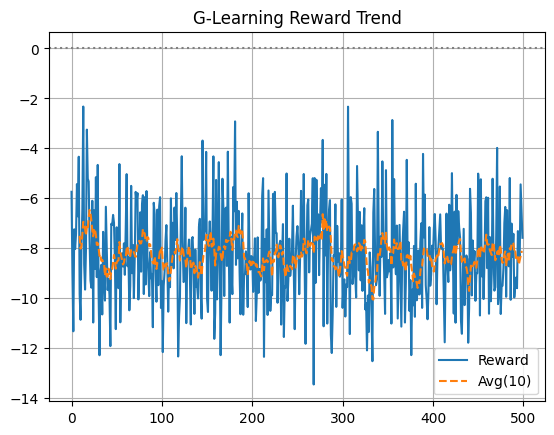

In [ ]:
plt.plot(month_rewards, label="Reward")
plt.plot(pd.Series(month_rewards).rolling(10).mean(), label="Avg(10)", linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.legend(); plt.title("G‑Learning Reward Trend"); plt.grid(True)

It doesnt seem like increasing episosdes helped much (even tho more q updates usually help converge more smoothly) - the reward range has sightly improve to -9 to -6

#with greedy variant

- Now I improve this by using a soft stochastic policy where the agent samples actions probabilistically from the softmax policy ( SOFT Q LEARNING)
- This means it will always pick the action with the lowest G-value, no randomness, no KL penalty - > this is now a more
- so i m using stochastic for training and then greedy variant for evaluation

In [ ]:


episodes = 500
month_len = 21
equity_curves, month_rewards = [], []

pbar = tqdm(range(episodes), desc="Training G‑Learning")
for ep in pbar:
    obs, _ = env_raw.reset()
    equity = [env_raw.unwrapped._total_profit]

    for t in range(month_len):
        s = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s)
        a = np.random.choice(ACTIONS, p=pi)  # stochastic during training

        obs, rew, terminated, truncated, info = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g = softmax_g(s_next) @ G[s_next]
        reg = kl_beta * kl_div(pi, pi_ref)

        end_of_month = (t == month_len - 1)
        episode_end = terminated or truncated

        if end_of_month or episode_end:
            ret = env_raw.unwrapped._total_profit - 1.0
            if len(equity) > 2:
                sigma = np.std(np.diff(equity[-month_len:])) + 1e-6
            else:
                sigma = 1.0
            reward = ret / sigma - reg

            G[s][a] = (1 - alpha) * G[s][a] + alpha * (reward + gamma * Ea_g)
            month_rewards.append(reward)

        if episode_end:
            break

    equity_curves.append(equity)

    print(f"Episode {ep+1:>3} | Reward: {month_rewards[-1]:>7.4f}")

    pbar.set_description(f"Ep {ep+1} | R: {month_rewards[-1]:.4f}")

    if len(month_rewards) >= 10:
        avg10 = np.mean(month_rewards[-10:])
        print(f"Avg Reward (last 10): {avg10:.4f}")


Ep 2 | R: -6.4137:   0%|          | 2/500 [00:00<01:05,  7.63it/s]

Episode   1 | Reward: -8.2647
Episode   2 | Reward: -6.4137


Ep 4 | R: -5.2837:   1%|          | 4/500 [00:00<01:05,  7.55it/s]

Episode   3 | Reward: -10.8412
Episode   4 | Reward: -5.2837


Ep 7 | R: -8.1689:   1%|▏         | 7/500 [00:00<00:51,  9.65it/s]

Episode   5 | Reward: -6.8391
Episode   6 | Reward: -6.9263
Episode   7 | Reward: -8.1689


Ep 11 | R: -9.2629:   2%|▏         | 11/500 [00:01<00:35, 13.63it/s]

Episode   8 | Reward: -6.5279
Episode   9 | Reward: -7.6706
Episode  10 | Reward: -7.4094
Avg Reward (last 10): -7.4345
Episode  11 | Reward: -9.2629
Avg Reward (last 10): -7.5344


Ep 15 | R: -7.1143:   3%|▎         | 15/500 [00:01<00:30, 15.66it/s]

Episode  12 | Reward: -9.0628
Avg Reward (last 10): -7.7993
Episode  13 | Reward: -7.9091
Avg Reward (last 10): -7.5061
Episode  14 | Reward: -7.7049
Avg Reward (last 10): -7.7482
Episode  15 | Reward: -7.1143
Avg Reward (last 10): -7.7757


Ep 19 | R: -7.7127:   4%|▍         | 19/500 [00:01<00:28, 16.80it/s]

Episode  16 | Reward: -8.2066
Avg Reward (last 10): -7.9037
Episode  17 | Reward: -7.8961
Avg Reward (last 10): -7.8765
Episode  18 | Reward: -8.5302
Avg Reward (last 10): -8.0767
Episode  19 | Reward: -7.7127
Avg Reward (last 10): -8.0809


Ep 23 | R: -10.8721:   5%|▍         | 23/500 [00:01<00:28, 16.83it/s]

Episode  20 | Reward: -10.6286
Avg Reward (last 10): -8.4028
Episode  21 | Reward: -8.1673
Avg Reward (last 10): -8.2933
Episode  22 | Reward: -8.7813
Avg Reward (last 10): -8.2651
Episode  23 | Reward: -10.8721
Avg Reward (last 10): -8.5614


Ep 26 | R: -8.7760:   5%|▌         | 25/500 [00:01<00:27, 17.20it/s]

Episode  24 | Reward: -9.3644
Avg Reward (last 10): -8.7274
Episode  25 | Reward: -6.0902
Avg Reward (last 10): -8.6250
Episode  26 | Reward: -8.7760
Avg Reward (last 10): -8.6819


Ep 30 | R: -8.4493:   6%|▌         | 29/500 [00:02<00:30, 15.24it/s]

Episode  27 | Reward: -5.7322
Avg Reward (last 10): -8.4655
Episode  28 | Reward: -10.0839
Avg Reward (last 10): -8.6209
Episode  29 | Reward: -6.4001
Avg Reward (last 10): -8.4896
Episode  30 | Reward: -8.4493
Avg Reward (last 10): -8.2717


Ep 34 | R: -9.8791:   7%|▋         | 33/500 [00:02<00:28, 16.31it/s]

Episode  31 | Reward: -8.7469
Avg Reward (last 10): -8.3296
Episode  32 | Reward: -8.8711
Avg Reward (last 10): -8.3386
Episode  33 | Reward: -8.9394
Avg Reward (last 10): -8.1453
Episode  34 | Reward: -9.8791
Avg Reward (last 10): -8.1968


Ep 38 | R: -6.3060:   7%|▋         | 37/500 [00:02<00:27, 16.62it/s]

Episode  35 | Reward: -9.6811
Avg Reward (last 10): -8.5559
Episode  36 | Reward: -9.6477
Avg Reward (last 10): -8.6431
Episode  37 | Reward: -9.4077
Avg Reward (last 10): -9.0106
Episode  38 | Reward: -6.3060
Avg Reward (last 10): -8.6328


Ep 42 | R: -6.8160:   8%|▊         | 42/500 [00:02<00:25, 18.00it/s]

Episode  39 | Reward: -8.1095
Avg Reward (last 10): -8.8038
Episode  40 | Reward: -10.7631
Avg Reward (last 10): -9.0352
Episode  41 | Reward: -8.8512
Avg Reward (last 10): -9.0456
Episode  42 | Reward: -6.8160
Avg Reward (last 10): -8.8401


Ep 46 | R: -6.0549:   9%|▉         | 46/500 [00:03<00:24, 18.28it/s]

Episode  43 | Reward: -8.0353
Avg Reward (last 10): -8.7497
Episode  44 | Reward: -10.3818
Avg Reward (last 10): -8.7999
Episode  45 | Reward: -6.3469
Avg Reward (last 10): -8.4665
Episode  46 | Reward: -6.0549
Avg Reward (last 10): -8.1072


Ep 50 | R: -8.8861:  10%|█         | 50/500 [00:03<00:23, 18.92it/s]

Episode  47 | Reward: -6.3698
Avg Reward (last 10): -7.8034
Episode  48 | Reward: -8.7953
Avg Reward (last 10): -8.0524
Episode  49 | Reward: -7.5263
Avg Reward (last 10): -7.9941
Episode  50 | Reward: -8.8861
Avg Reward (last 10): -7.8064
Episode  51 | Reward: -8.0544


Ep 54 | R: -12.1853:  11%|█         | 54/500 [00:03<00:23, 18.97it/s]

Avg Reward (last 10): -7.7267
Episode  52 | Reward: -4.9966
Avg Reward (last 10): -7.5447
Episode  53 | Reward: -9.8781
Avg Reward (last 10): -7.7290
Episode  54 | Reward: -12.1853
Avg Reward (last 10): -7.9094


Ep 58 | R: -7.3038:  12%|█▏        | 58/500 [00:03<00:24, 18.30it/s]

Episode  55 | Reward: -7.5517
Avg Reward (last 10): -8.0299
Episode  56 | Reward: -6.8643
Avg Reward (last 10): -8.1108
Episode  57 | Reward: -10.6992
Avg Reward (last 10): -8.5437
Episode  58 | Reward: -7.3038
Avg Reward (last 10): -8.3946


Ep 62 | R: -7.2763:  12%|█▏        | 62/500 [00:03<00:24, 17.89it/s]

Episode  59 | Reward: -11.5001
Avg Reward (last 10): -8.7920
Episode  60 | Reward: -8.2177
Avg Reward (last 10): -8.7251
Episode  61 | Reward: -10.6290
Avg Reward (last 10): -8.9826
Episode  62 | Reward: -7.2763
Avg Reward (last 10): -9.2106


Ep 66 | R: -6.1035:  13%|█▎        | 66/500 [00:04<00:25, 17.36it/s]

Episode  63 | Reward: -8.0190
Avg Reward (last 10): -9.0246
Episode  64 | Reward: -7.0532
Avg Reward (last 10): -8.5114
Episode  65 | Reward: -10.4328
Avg Reward (last 10): -8.7995
Episode  66 | Reward: -6.1035
Avg Reward (last 10): -8.7235


Ep 69 | R: -9.2833:  14%|█▎        | 68/500 [00:04<00:29, 14.56it/s] 

Episode  67 | Reward: -9.8758
Avg Reward (last 10): -8.6411
Episode  68 | Reward: -10.9599
Avg Reward (last 10): -9.0067
Episode  69 | Reward: -9.2833
Avg Reward (last 10): -8.7851


Ep 73 | R: -5.4048:  14%|█▍        | 72/500 [00:04<00:26, 16.04it/s]

Episode  70 | Reward: -7.1823
Avg Reward (last 10): -8.6815
Episode  71 | Reward: -10.2550
Avg Reward (last 10): -8.6441
Episode  72 | Reward: -6.0455
Avg Reward (last 10): -8.5210
Episode  73 | Reward: -5.4048
Avg Reward (last 10): -8.2596


Ep 77 | R: -9.1931:  15%|█▌        | 76/500 [00:04<00:24, 17.14it/s] 

Episode  74 | Reward: -7.6137
Avg Reward (last 10): -8.3156
Episode  75 | Reward: -7.1069
Avg Reward (last 10): -7.9831
Episode  76 | Reward: -10.6389
Avg Reward (last 10): -8.4366
Episode  77 | Reward: -9.1931
Avg Reward (last 10): -8.3683


Ep 81 | R: -10.8963:  16%|█▌        | 80/500 [00:05<00:24, 17.25it/s]

Episode  78 | Reward: -2.9697
Avg Reward (last 10): -7.5693
Episode  79 | Reward: -5.8351
Avg Reward (last 10): -7.2245
Episode  80 | Reward: -5.5936
Avg Reward (last 10): -7.0656
Episode  81 | Reward: -10.8963
Avg Reward (last 10): -7.1298


Ep 84 | R: -6.6198:  17%|█▋        | 84/500 [00:05<00:28, 14.39it/s]

Episode  82 | Reward: -10.9940
Avg Reward (last 10): -7.6246
Episode  83 | Reward: -10.4309
Avg Reward (last 10): -8.1272
Episode  84 | Reward: -6.6198
Avg Reward (last 10): -8.0278


Ep 88 | R: -12.0204:  18%|█▊        | 88/500 [00:05<00:25, 16.17it/s]

Episode  85 | Reward: -8.4789
Avg Reward (last 10): -8.1650
Episode  86 | Reward: -5.7139
Avg Reward (last 10): -7.6725
Episode  87 | Reward: -8.7704
Avg Reward (last 10): -7.6303
Episode  88 | Reward: -12.0204
Avg Reward (last 10): -8.5353


Ep 92 | R: -8.0470:  18%|█▊        | 92/500 [00:05<00:23, 17.16it/s]

Episode  89 | Reward: -11.0080
Avg Reward (last 10): -9.0526
Episode  90 | Reward: -9.5950
Avg Reward (last 10): -9.4528
Episode  91 | Reward: -11.5448
Avg Reward (last 10): -9.5176
Episode  92 | Reward: -8.0470
Avg Reward (last 10): -9.2229


Ep 96 | R: -7.3149:  19%|█▉        | 96/500 [00:06<00:22, 17.79it/s]

Episode  93 | Reward: -6.9382
Avg Reward (last 10): -8.8736
Episode  94 | Reward: -10.8776
Avg Reward (last 10): -9.2994
Episode  95 | Reward: -7.8556
Avg Reward (last 10): -9.2371
Episode  96 | Reward: -7.3149
Avg Reward (last 10): -9.3972


Ep 99 | R: -4.6087:  20%|█▉        | 98/500 [00:06<00:23, 17.23it/s] 

Episode  97 | Reward: -13.3459
Avg Reward (last 10): -9.8548
Episode  98 | Reward: -10.0721
Avg Reward (last 10): -9.6599
Episode  99 | Reward: -4.6087
Avg Reward (last 10): -9.0200


Ep 103 | R: -4.9826:  20%|██        | 102/500 [00:06<00:25, 15.50it/s]

Episode 100 | Reward: -10.5906
Avg Reward (last 10): -9.1196
Episode 101 | Reward: -9.6229
Avg Reward (last 10): -8.9274
Episode 102 | Reward: -8.5687
Avg Reward (last 10): -8.9795
Episode 103 | Reward: -4.9826
Avg Reward (last 10): -8.7840


Ep 106 | R: -1.8246:  21%|██        | 106/500 [00:06<00:28, 14.06it/s]

Episode 104 | Reward: -8.7515
Avg Reward (last 10): -8.5714
Episode 105 | Reward: -2.8601
Avg Reward (last 10): -8.0718
Episode 106 | Reward: -1.8246
Avg Reward (last 10): -7.5228


Ep 110 | R: -10.2052:  22%|██▏       | 110/500 [00:06<00:24, 15.70it/s]

Episode 107 | Reward: -7.7260
Avg Reward (last 10): -6.9608
Episode 108 | Reward: -8.1065
Avg Reward (last 10): -6.7642
Episode 109 | Reward: -11.0849
Avg Reward (last 10): -7.4118
Episode 110 | Reward: -10.2052
Avg Reward (last 10): -7.3733


Ep 114 | R: -9.5563:  23%|██▎       | 114/500 [00:07<00:23, 16.14it/s]

Episode 111 | Reward: -6.9675
Avg Reward (last 10): -7.1078
Episode 112 | Reward: -7.5371
Avg Reward (last 10): -7.0046
Episode 113 | Reward: -9.9472
Avg Reward (last 10): -7.5011
Episode 114 | Reward: -9.5563
Avg Reward (last 10): -7.5815


Ep 118 | R: -9.0892:  24%|██▎       | 118/500 [00:07<00:22, 17.30it/s]

Episode 115 | Reward: -6.9126
Avg Reward (last 10): -7.9868
Episode 116 | Reward: -5.8483
Avg Reward (last 10): -8.3892
Episode 117 | Reward: -7.1978
Avg Reward (last 10): -8.3363
Episode 118 | Reward: -9.0892
Avg Reward (last 10): -8.4346


Ep 122 | R: -11.4644:  24%|██▍       | 122/500 [00:07<00:21, 17.66it/s]

Episode 119 | Reward: -8.2369
Avg Reward (last 10): -8.1498
Episode 120 | Reward: -6.7790
Avg Reward (last 10): -7.8072
Episode 121 | Reward: -12.0007
Avg Reward (last 10): -8.3105
Episode 122 | Reward: -11.4644
Avg Reward (last 10): -8.7032


Ep 126 | R: -8.4712:  25%|██▌       | 126/500 [00:07<00:20, 17.82it/s]

Episode 123 | Reward: -6.1872
Avg Reward (last 10): -8.3272
Episode 124 | Reward: -8.1203
Avg Reward (last 10): -8.1836
Episode 125 | Reward: -7.5201
Avg Reward (last 10): -8.2444
Episode 126 | Reward: -8.4712
Avg Reward (last 10): -8.5067


Ep 130 | R: -9.6353:  26%|██▌       | 130/500 [00:08<00:20, 18.33it/s]

Episode 127 | Reward: -7.1912
Avg Reward (last 10): -8.5060
Episode 128 | Reward: -9.0423
Avg Reward (last 10): -8.5013
Episode 129 | Reward: -9.3139
Avg Reward (last 10): -8.6090
Episode 130 | Reward: -9.6353
Avg Reward (last 10): -8.8947


Ep 133 | R: -7.9324:  26%|██▋       | 132/500 [00:08<00:24, 14.88it/s]

Episode 131 | Reward: -10.5202
Avg Reward (last 10): -8.7466
Episode 132 | Reward: -7.9743
Avg Reward (last 10): -8.3976
Episode 133 | Reward: -7.9324
Avg Reward (last 10): -8.5721


Ep 137 | R: -8.7236:  27%|██▋       | 136/500 [00:08<00:22, 16.32it/s]

Episode 134 | Reward: -4.4451
Avg Reward (last 10): -8.2046
Episode 135 | Reward: -9.2144
Avg Reward (last 10): -8.3740
Episode 136 | Reward: -7.6026
Avg Reward (last 10): -8.2872
Episode 137 | Reward: -8.7236
Avg Reward (last 10): -8.4404


Ep 140 | R: -10.5971:  28%|██▊       | 140/500 [00:08<00:24, 14.47it/s]

Episode 138 | Reward: -8.6918
Avg Reward (last 10): -8.4054
Episode 139 | Reward: -9.9309
Avg Reward (last 10): -8.4671
Episode 140 | Reward: -10.5971
Avg Reward (last 10): -8.5633


Ep 143 | R: -4.6441:  28%|██▊       | 142/500 [00:09<00:25, 13.91it/s] 

Episode 141 | Reward: -9.5767
Avg Reward (last 10): -8.4689
Episode 142 | Reward: -11.3742
Avg Reward (last 10): -8.8089
Episode 143 | Reward: -4.6441
Avg Reward (last 10): -8.4801


Ep 145 | R: -9.7525:  29%|██▉       | 144/500 [00:09<00:25, 13.94it/s]

Episode 144 | Reward: -9.2668
Avg Reward (last 10): -8.9622
Episode 145 | Reward: -9.7525
Avg Reward (last 10): -9.0160


Ep 148 | R: -9.0386:  30%|██▉       | 148/500 [00:09<00:29, 11.94it/s]

Episode 146 | Reward: -12.2886
Avg Reward (last 10): -9.4846
Episode 147 | Reward: -11.3800
Avg Reward (last 10): -9.7503
Episode 148 | Reward: -9.0386
Avg Reward (last 10): -9.7850


Ep 151 | R: -6.7974:  30%|███       | 150/500 [00:09<00:27, 12.57it/s]

Episode 149 | Reward: -3.3162
Avg Reward (last 10): -9.1235
Episode 150 | Reward: -9.2345
Avg Reward (last 10): -8.9872
Episode 151 | Reward: -6.7974
Avg Reward (last 10): -8.7093


Ep 154 | R: -9.9159:  31%|███       | 154/500 [00:09<00:26, 12.98it/s]

Episode 152 | Reward: -6.9915
Avg Reward (last 10): -8.2710
Episode 153 | Reward: -7.4012
Avg Reward (last 10): -8.5467
Episode 154 | Reward: -9.9159
Avg Reward (last 10): -8.6116


Ep 157 | R: -10.5592:  31%|███       | 156/500 [00:10<00:25, 13.31it/s]

Episode 155 | Reward: -8.9775
Avg Reward (last 10): -8.5341
Episode 156 | Reward: -6.6094
Avg Reward (last 10): -7.9662
Episode 157 | Reward: -10.5592
Avg Reward (last 10): -7.8841


Ep 160 | R: 0.2585:  32%|███▏      | 160/500 [00:10<00:30, 11.09it/s]

Episode 158 | Reward: -7.5670
Avg Reward (last 10): -7.7370
Episode 159 | Reward: -6.9586
Avg Reward (last 10): -8.1012
Episode 160 | Reward:  0.2585
Avg Reward (last 10): -7.1519


Ep 163 | R: -10.7104:  32%|███▏      | 162/500 [00:10<00:28, 11.66it/s]

Episode 161 | Reward: -9.8828
Avg Reward (last 10): -7.4605
Episode 162 | Reward: -7.5669
Avg Reward (last 10): -7.5180
Episode 163 | Reward: -10.7104
Avg Reward (last 10): -7.8489


Ep 166 | R: -8.1310:  33%|███▎      | 166/500 [00:10<00:27, 12.09it/s]

Episode 164 | Reward: -9.7363
Avg Reward (last 10): -7.8310
Episode 165 | Reward: -9.8434
Avg Reward (last 10): -7.9175
Episode 166 | Reward: -8.1310
Avg Reward (last 10): -8.0697


Ep 168 | R: -9.4709:  34%|███▎      | 168/500 [00:11<00:27, 12.16it/s]

Episode 167 | Reward: -4.9934
Avg Reward (last 10): -7.5131
Episode 168 | Reward: -9.4709
Avg Reward (last 10): -7.7035


Ep 172 | R: -11.0169:  34%|███▍      | 172/500 [00:11<00:25, 12.63it/s]

Episode 169 | Reward: -8.3993
Avg Reward (last 10): -7.8476
Episode 170 | Reward: -7.0354
Avg Reward (last 10): -8.5770
Episode 171 | Reward: -6.9731
Avg Reward (last 10): -8.2860
Episode 172 | Reward: -11.0169
Avg Reward (last 10): -8.6310


Ep 176 | R: -6.0340:  35%|███▌      | 176/500 [00:11<00:21, 14.80it/s]

Episode 173 | Reward: -10.4250
Avg Reward (last 10): -8.6025
Episode 174 | Reward: -9.3189
Avg Reward (last 10): -8.5607
Episode 175 | Reward: -8.1487
Avg Reward (last 10): -8.3913
Episode 176 | Reward: -6.0340
Avg Reward (last 10): -8.1816


Ep 180 | R: -9.3856:  36%|███▌      | 180/500 [00:11<00:19, 16.44it/s]

Episode 177 | Reward: -8.8153
Avg Reward (last 10): -8.5637
Episode 178 | Reward: -8.2343
Avg Reward (last 10): -8.4401
Episode 179 | Reward: -6.6799
Avg Reward (last 10): -8.2681
Episode 180 | Reward: -9.3856
Avg Reward (last 10): -8.5032


Ep 184 | R: -5.2668:  37%|███▋      | 184/500 [00:12<00:18, 16.88it/s]

Episode 181 | Reward: -8.4395
Avg Reward (last 10): -8.6498
Episode 182 | Reward: -6.2944
Avg Reward (last 10): -8.1776
Episode 183 | Reward: -10.0987
Avg Reward (last 10): -8.1449
Episode 184 | Reward: -5.2668
Avg Reward (last 10): -7.7397


Ep 187 | R: -11.5614:  37%|███▋      | 186/500 [00:12<00:21, 14.38it/s]

Episode 185 | Reward: -9.8722
Avg Reward (last 10): -7.9121
Episode 186 | Reward: -6.3492
Avg Reward (last 10): -7.9436
Episode 187 | Reward: -11.5614
Avg Reward (last 10): -8.2182


Ep 191 | R: -7.9767:  38%|███▊      | 190/500 [00:12<00:19, 15.55it/s]

Episode 188 | Reward: -10.0082
Avg Reward (last 10): -8.3956
Episode 189 | Reward: -11.5129
Avg Reward (last 10): -8.8789
Episode 190 | Reward: -8.4191
Avg Reward (last 10): -8.7822
Episode 191 | Reward: -7.9767
Avg Reward (last 10): -8.7359


Ep 195 | R: -7.1908:  39%|███▉      | 194/500 [00:12<00:18, 16.83it/s]

Episode 192 | Reward: -11.4402
Avg Reward (last 10): -9.2505
Episode 193 | Reward: -9.8329
Avg Reward (last 10): -9.2240
Episode 194 | Reward: -7.5645
Avg Reward (last 10): -9.4537
Episode 195 | Reward: -7.1908
Avg Reward (last 10): -9.1856


Ep 199 | R: -9.6309:  40%|███▉      | 198/500 [00:13<00:17, 17.62it/s]

Episode 196 | Reward: -6.8114
Avg Reward (last 10): -9.2318
Episode 197 | Reward: -10.0891
Avg Reward (last 10): -9.0846
Episode 198 | Reward: -1.2721
Avg Reward (last 10): -8.2110
Episode 199 | Reward: -9.6309
Avg Reward (last 10): -8.0228


Ep 202 | R: -9.4641:  40%|████      | 202/500 [00:13<00:19, 15.06it/s]

Episode 200 | Reward: -5.7620
Avg Reward (last 10): -7.7571
Episode 201 | Reward: -7.9658
Avg Reward (last 10): -7.7560
Episode 202 | Reward: -9.4641
Avg Reward (last 10): -7.5584


Ep 206 | R: -9.2345:  41%|████      | 206/500 [00:13<00:18, 15.91it/s]

Episode 203 | Reward: -8.5215
Avg Reward (last 10): -7.4272
Episode 204 | Reward: -10.1655
Avg Reward (last 10): -7.6873
Episode 205 | Reward: -8.9226
Avg Reward (last 10): -7.8605
Episode 206 | Reward: -9.2345
Avg Reward (last 10): -8.1028


Ep 210 | R: -9.4096:  42%|████▏     | 210/500 [00:13<00:17, 17.05it/s]

Episode 207 | Reward: -7.0793
Avg Reward (last 10): -7.8018
Episode 208 | Reward: -8.9329
Avg Reward (last 10): -8.5679
Episode 209 | Reward: -6.9823
Avg Reward (last 10): -8.3030
Episode 210 | Reward: -9.4096
Avg Reward (last 10): -8.6678


Ep 214 | R: -9.1062:  43%|████▎     | 214/500 [00:13<00:16, 17.62it/s]

Episode 211 | Reward: -9.8371
Avg Reward (last 10): -8.8549
Episode 212 | Reward: -8.6772
Avg Reward (last 10): -8.7762
Episode 213 | Reward: -6.8824
Avg Reward (last 10): -8.6123
Episode 214 | Reward: -9.1062
Avg Reward (last 10): -8.5064


Ep 217 | R: -7.3905:  43%|████▎     | 216/500 [00:14<00:16, 17.51it/s]

Episode 215 | Reward: -7.9543
Avg Reward (last 10): -8.4096
Episode 216 | Reward: -9.5485
Avg Reward (last 10): -8.4410
Episode 217 | Reward: -7.3905
Avg Reward (last 10): -8.4721


Ep 221 | R: -6.5791:  44%|████▍     | 220/500 [00:14<00:17, 15.75it/s]

Episode 218 | Reward: -9.8119
Avg Reward (last 10): -8.5600
Episode 219 | Reward: -9.0848
Avg Reward (last 10): -8.7702
Episode 220 | Reward: -7.4892
Avg Reward (last 10): -8.5782
Episode 221 | Reward: -6.5791
Avg Reward (last 10): -8.2524


Ep 225 | R: -8.8987:  45%|████▍     | 224/500 [00:14<00:16, 16.61it/s]

Episode 222 | Reward: -7.5357
Avg Reward (last 10): -8.1382
Episode 223 | Reward: -9.6768
Avg Reward (last 10): -8.4177
Episode 224 | Reward: -2.1619
Avg Reward (last 10): -7.7233
Episode 225 | Reward: -8.8987
Avg Reward (last 10): -7.8177


Ep 229 | R: -6.6716:  46%|████▌     | 228/500 [00:14<00:15, 17.46it/s]

Episode 226 | Reward: -8.3313
Avg Reward (last 10): -7.6960
Episode 227 | Reward: -6.1205
Avg Reward (last 10): -7.5690
Episode 228 | Reward: -9.3409
Avg Reward (last 10): -7.5219
Episode 229 | Reward: -6.6716
Avg Reward (last 10): -7.2805


Ep 233 | R: -10.1538:  46%|████▋     | 232/500 [00:15<00:15, 17.68it/s]

Episode 230 | Reward: -9.4134
Avg Reward (last 10): -7.4730
Episode 231 | Reward: -11.0234
Avg Reward (last 10): -7.9174
Episode 232 | Reward: -4.6301
Avg Reward (last 10): -7.6268
Episode 233 | Reward: -10.1538
Avg Reward (last 10): -7.6746


Ep 237 | R: -5.6865:  47%|████▋     | 236/500 [00:15<00:16, 15.85it/s] 

Episode 234 | Reward: -5.9773
Avg Reward (last 10): -8.0561
Episode 235 | Reward: -9.7966
Avg Reward (last 10): -8.1459
Episode 236 | Reward: -10.7133
Avg Reward (last 10): -8.3841
Episode 237 | Reward: -5.6865
Avg Reward (last 10): -8.3407


Ep 240 | R: -10.4639:  48%|████▊     | 240/500 [00:15<00:18, 14.28it/s]

Episode 238 | Reward: -9.1428
Avg Reward (last 10): -8.3209
Episode 239 | Reward: -8.3087
Avg Reward (last 10): -8.4846
Episode 240 | Reward: -10.4639
Avg Reward (last 10): -8.5896


Ep 244 | R: -8.4235:  49%|████▉     | 244/500 [00:15<00:15, 16.05it/s]

Episode 241 | Reward: -7.4596
Avg Reward (last 10): -8.2333
Episode 242 | Reward: -7.0715
Avg Reward (last 10): -8.4774
Episode 243 | Reward: -9.3906
Avg Reward (last 10): -8.4011
Episode 244 | Reward: -8.4235
Avg Reward (last 10): -8.6457


Ep 248 | R: -5.0807:  50%|████▉     | 248/500 [00:16<00:14, 17.58it/s]

Episode 245 | Reward: -10.1764
Avg Reward (last 10): -8.6837
Episode 246 | Reward: -8.4347
Avg Reward (last 10): -8.4558
Episode 247 | Reward: -7.1029
Avg Reward (last 10): -8.5975
Episode 248 | Reward: -5.0807
Avg Reward (last 10): -8.1913


Ep 252 | R: -7.1050:  50%|█████     | 252/500 [00:16<00:13, 18.23it/s]

Episode 249 | Reward: -6.5098
Avg Reward (last 10): -8.0114
Episode 250 | Reward: -4.5973
Avg Reward (last 10): -7.4247
Episode 251 | Reward: -6.4113
Avg Reward (last 10): -7.3199
Episode 252 | Reward: -7.1050
Avg Reward (last 10): -7.3232


Ep 256 | R: -7.3689:  51%|█████     | 256/500 [00:16<00:13, 17.76it/s]

Episode 253 | Reward: -12.3089
Avg Reward (last 10): -7.6151
Episode 254 | Reward: -5.2457
Avg Reward (last 10): -7.2973
Episode 255 | Reward: -9.2134
Avg Reward (last 10): -7.2010
Episode 256 | Reward: -7.3689
Avg Reward (last 10): -7.0944


Ep 260 | R: -9.0346:  52%|█████▏    | 260/500 [00:16<00:13, 17.62it/s]

Episode 257 | Reward: -4.6620
Avg Reward (last 10): -6.8503
Episode 258 | Reward: -7.7475
Avg Reward (last 10): -7.1170
Episode 259 | Reward: -9.7994
Avg Reward (last 10): -7.4460
Episode 260 | Reward: -9.0346
Avg Reward (last 10): -7.8897


Ep 264 | R: -9.8893:  53%|█████▎    | 264/500 [00:16<00:13, 17.69it/s]

Episode 261 | Reward: -8.4317
Avg Reward (last 10): -8.0917
Episode 262 | Reward: -9.6801
Avg Reward (last 10): -8.3492
Episode 263 | Reward: -9.6750
Avg Reward (last 10): -8.0858
Episode 264 | Reward: -9.8893
Avg Reward (last 10): -8.5502


Ep 268 | R: -8.7415:  54%|█████▎    | 268/500 [00:17<00:13, 17.44it/s]

Episode 265 | Reward: -9.2510
Avg Reward (last 10): -8.5539
Episode 266 | Reward: -8.0559
Avg Reward (last 10): -8.6226
Episode 267 | Reward: -9.5564
Avg Reward (last 10): -9.1121
Episode 268 | Reward: -8.7415
Avg Reward (last 10): -9.2115


Ep 271 | R: -8.0698:  54%|█████▍    | 270/500 [00:17<00:13, 17.37it/s]

Episode 269 | Reward: -7.4718
Avg Reward (last 10): -8.9787
Episode 270 | Reward: -8.0289
Avg Reward (last 10): -8.8781
Episode 271 | Reward: -8.0698
Avg Reward (last 10): -8.8420


Ep 275 | R: -9.1015:  55%|█████▍    | 274/500 [00:17<00:14, 15.37it/s]

Episode 272 | Reward: -7.7660
Avg Reward (last 10): -8.6505
Episode 273 | Reward: -9.9461
Avg Reward (last 10): -8.6777
Episode 274 | Reward: -7.3979
Avg Reward (last 10): -8.4285
Episode 275 | Reward: -9.1015
Avg Reward (last 10): -8.4136


Ep 279 | R: -11.5578:  56%|█████▌    | 278/500 [00:17<00:13, 16.49it/s]

Episode 276 | Reward: -9.9042
Avg Reward (last 10): -8.5984
Episode 277 | Reward: -6.5194
Avg Reward (last 10): -8.2947
Episode 278 | Reward: -8.1033
Avg Reward (last 10): -8.2309
Episode 279 | Reward: -11.5578
Avg Reward (last 10): -8.6395


Ep 283 | R: -6.2673:  56%|█████▋    | 282/500 [00:18<00:12, 17.37it/s]

Episode 280 | Reward: -8.2977
Avg Reward (last 10): -8.6664
Episode 281 | Reward: -9.4026
Avg Reward (last 10): -8.7996
Episode 282 | Reward: -9.5372
Avg Reward (last 10): -8.9768
Episode 283 | Reward: -6.2673
Avg Reward (last 10): -8.6089


Ep 286 | R: -9.1847:  57%|█████▋    | 286/500 [00:18<00:14, 14.84it/s]

Episode 284 | Reward: -6.4159
Avg Reward (last 10): -8.5107
Episode 285 | Reward: -6.5803
Avg Reward (last 10): -8.2586
Episode 286 | Reward: -9.1847
Avg Reward (last 10): -8.1866


Ep 290 | R: -8.7519:  58%|█████▊    | 290/500 [00:18<00:13, 15.79it/s]

Episode 287 | Reward: -8.1230
Avg Reward (last 10): -8.3470
Episode 288 | Reward: -9.7968
Avg Reward (last 10): -8.5163
Episode 289 | Reward: -4.7429
Avg Reward (last 10): -7.8348
Episode 290 | Reward: -8.7519
Avg Reward (last 10): -7.8803


Ep 294 | R: -9.0746:  59%|█████▉    | 294/500 [00:18<00:12, 16.85it/s]

Episode 291 | Reward: -9.4778
Avg Reward (last 10): -7.8878
Episode 292 | Reward: -5.2996
Avg Reward (last 10): -7.4640
Episode 293 | Reward: -10.2532
Avg Reward (last 10): -7.8626
Episode 294 | Reward: -9.0746
Avg Reward (last 10): -8.1285


Ep 298 | R: -5.1562:  60%|█████▉    | 298/500 [00:19<00:11, 17.35it/s]

Episode 295 | Reward: -5.9525
Avg Reward (last 10): -8.0657
Episode 296 | Reward: -3.6411
Avg Reward (last 10): -7.5113
Episode 297 | Reward: -9.9549
Avg Reward (last 10): -7.6945
Episode 298 | Reward: -5.1562
Avg Reward (last 10): -7.2305


Ep 301 | R: -8.5531:  60%|██████    | 300/500 [00:19<00:11, 17.24it/s] 

Episode 299 | Reward: -9.2808
Avg Reward (last 10): -7.6842
Episode 300 | Reward: -10.6573
Avg Reward (last 10): -7.8748
Episode 301 | Reward: -8.5531
Avg Reward (last 10): -7.7823


Ep 305 | R: -9.0920:  61%|██████    | 304/500 [00:19<00:12, 15.74it/s]

Episode 302 | Reward: -6.0810
Avg Reward (last 10): -7.8604
Episode 303 | Reward: -6.4604
Avg Reward (last 10): -7.4812
Episode 304 | Reward: -3.4454
Avg Reward (last 10): -6.9183
Episode 305 | Reward: -9.0920
Avg Reward (last 10): -7.2322


Ep 309 | R: -6.9686:  62%|██████▏   | 308/500 [00:19<00:11, 16.47it/s]

Episode 306 | Reward: -9.1395
Avg Reward (last 10): -7.7821
Episode 307 | Reward: -7.6386
Avg Reward (last 10): -7.5504
Episode 308 | Reward: -9.9728
Avg Reward (last 10): -8.0321
Episode 309 | Reward: -6.9686
Avg Reward (last 10): -7.8009


Ep 313 | R: -10.6433:  62%|██████▏   | 312/500 [00:19<00:10, 17.43it/s]

Episode 310 | Reward: -9.4288
Avg Reward (last 10): -7.6780
Episode 311 | Reward: -8.4883
Avg Reward (last 10): -7.6715
Episode 312 | Reward: -9.3738
Avg Reward (last 10): -8.0008
Episode 313 | Reward: -10.6433
Avg Reward (last 10): -8.4191


Ep 316 | R: -10.3590:  63%|██████▎   | 316/500 [00:20<00:10, 17.44it/s]

Episode 314 | Reward: -8.2607
Avg Reward (last 10): -8.9006
Episode 315 | Reward: -10.8835
Avg Reward (last 10): -9.0798
Episode 316 | Reward: -10.3590
Avg Reward (last 10): -9.2017


Ep 320 | R: -5.3456:  64%|██████▍   | 320/500 [00:20<00:11, 15.80it/s]

Episode 317 | Reward: -10.7110
Avg Reward (last 10): -9.5090
Episode 318 | Reward: -9.3906
Avg Reward (last 10): -9.4508
Episode 319 | Reward: -9.8264
Avg Reward (last 10): -9.7365
Episode 320 | Reward: -5.3456
Avg Reward (last 10): -9.3282


Ep 324 | R: -9.9082:  65%|██████▍   | 324/500 [00:20<00:11, 15.97it/s]

Episode 321 | Reward: -8.1741
Avg Reward (last 10): -9.2968
Episode 322 | Reward: -9.2100
Avg Reward (last 10): -9.2804
Episode 323 | Reward: -5.0385
Avg Reward (last 10): -8.7199
Episode 324 | Reward: -9.9082
Avg Reward (last 10): -8.8847


Ep 328 | R: -10.2235:  66%|██████▌   | 328/500 [00:20<00:10, 16.98it/s]

Episode 325 | Reward: -3.3020
Avg Reward (last 10): -8.1265
Episode 326 | Reward: -7.9688
Avg Reward (last 10): -7.8875
Episode 327 | Reward: -12.3640
Avg Reward (last 10): -8.0528
Episode 328 | Reward: -10.2235
Avg Reward (last 10): -8.1361


Ep 332 | R: -11.0255:  66%|██████▋   | 332/500 [00:21<00:09, 17.40it/s]

Episode 329 | Reward: -9.7083
Avg Reward (last 10): -8.1243
Episode 330 | Reward: -5.9705
Avg Reward (last 10): -8.1868
Episode 331 | Reward: -7.5383
Avg Reward (last 10): -8.1232
Episode 332 | Reward: -11.0255
Avg Reward (last 10): -8.3047


Ep 334 | R: -8.8262:  67%|██████▋   | 334/500 [00:21<00:12, 13.57it/s]

Episode 333 | Reward: -6.9444
Avg Reward (last 10): -8.4953
Episode 334 | Reward: -8.8262
Avg Reward (last 10): -8.3871


Ep 337 | R: -11.1279:  67%|██████▋   | 336/500 [00:21<00:12, 13.06it/s]

Episode 335 | Reward: -2.3378
Avg Reward (last 10): -8.2907
Episode 336 | Reward: -12.3482
Avg Reward (last 10): -8.7287
Episode 337 | Reward: -11.1279
Avg Reward (last 10): -8.6050


Ep 340 | R: -10.5579:  68%|██████▊   | 340/500 [00:21<00:12, 12.59it/s]

Episode 338 | Reward: -10.4759
Avg Reward (last 10): -8.6303
Episode 339 | Reward: -8.0676
Avg Reward (last 10): -8.4662
Episode 340 | Reward: -10.5579
Avg Reward (last 10): -8.9250


Ep 343 | R: -7.9841:  68%|██████▊   | 342/500 [00:22<00:12, 12.93it/s]

Episode 341 | Reward: -6.2100
Avg Reward (last 10): -8.7921
Episode 342 | Reward: -7.3972
Avg Reward (last 10): -8.4293
Episode 343 | Reward: -7.9841
Avg Reward (last 10): -8.5333


Ep 345 | R: -9.1488:  69%|██████▉   | 344/500 [00:22<00:12, 12.67it/s]

Episode 344 | Reward: -7.6271
Avg Reward (last 10): -8.4134
Episode 345 | Reward: -9.1488
Avg Reward (last 10): -9.0945


Ep 348 | R: -8.3296:  70%|██████▉   | 348/500 [00:22<00:13, 11.62it/s]

Episode 346 | Reward: -5.3696
Avg Reward (last 10): -8.3966
Episode 347 | Reward: -7.9437
Avg Reward (last 10): -8.0782
Episode 348 | Reward: -8.3296
Avg Reward (last 10): -7.8635


Ep 351 | R: -6.6147:  70%|███████   | 350/500 [00:22<00:12, 12.10it/s]

Episode 349 | Reward: -12.2752
Avg Reward (last 10): -8.2843
Episode 350 | Reward: -9.3522
Avg Reward (last 10): -8.1637
Episode 351 | Reward: -6.6147
Avg Reward (last 10): -8.2042


Ep 354 | R: -10.1896:  71%|███████   | 354/500 [00:22<00:11, 12.82it/s]

Episode 352 | Reward: -8.1461
Avg Reward (last 10): -8.2791
Episode 353 | Reward: -8.2476
Avg Reward (last 10): -8.3055
Episode 354 | Reward: -10.1896
Avg Reward (last 10): -8.5617


Ep 356 | R: -5.6462:  71%|███████   | 356/500 [00:23<00:12, 11.69it/s]

Episode 355 | Reward: -3.7792
Avg Reward (last 10): -8.0248
Episode 356 | Reward: -5.6462
Avg Reward (last 10): -8.0524


Ep 359 | R: -7.1578:  72%|███████▏  | 358/500 [00:23<00:13, 10.62it/s]

Episode 357 | Reward: -7.8939
Avg Reward (last 10): -8.0474
Episode 358 | Reward: -9.4694
Avg Reward (last 10): -8.1614
Episode 359 | Reward: -7.1578
Avg Reward (last 10): -7.6497


Ep 362 | R: -7.5988:  72%|███████▏  | 362/500 [00:23<00:11, 11.66it/s]

Episode 360 | Reward: -10.0017
Avg Reward (last 10): -7.7146
Episode 361 | Reward: -10.3518
Avg Reward (last 10): -8.0883
Episode 362 | Reward: -7.5988
Avg Reward (last 10): -8.0336


Ep 365 | R: -7.8928:  73%|███████▎  | 364/500 [00:23<00:12, 11.24it/s]

Episode 363 | Reward: -7.4869
Avg Reward (last 10): -7.9575
Episode 364 | Reward: -8.1126
Avg Reward (last 10): -7.7498
Episode 365 | Reward: -7.8928
Avg Reward (last 10): -8.1612


Ep 368 | R: -8.0997:  74%|███████▎  | 368/500 [00:24<00:10, 12.04it/s]

Episode 366 | Reward: -9.3983
Avg Reward (last 10): -8.5364
Episode 367 | Reward: -11.9308
Avg Reward (last 10): -8.9401
Episode 368 | Reward: -8.0997
Avg Reward (last 10): -8.8031


Ep 372 | R: -7.9078:  74%|███████▍  | 372/500 [00:24<00:08, 14.42it/s]

Episode 369 | Reward: -8.7743
Avg Reward (last 10): -8.9648
Episode 370 | Reward: -7.5934
Avg Reward (last 10): -8.7239
Episode 371 | Reward: -8.1142
Avg Reward (last 10): -8.5002
Episode 372 | Reward: -7.9078
Avg Reward (last 10): -8.5311


Ep 376 | R: -4.1851:  75%|███████▌  | 376/500 [00:24<00:08, 15.07it/s]

Episode 373 | Reward: -10.3748
Avg Reward (last 10): -8.8199
Episode 374 | Reward: -9.5678
Avg Reward (last 10): -8.9654
Episode 375 | Reward: -6.3100
Avg Reward (last 10): -8.8071
Episode 376 | Reward: -4.1851
Avg Reward (last 10): -8.2858


Ep 380 | R: -3.2996:  76%|███████▌  | 380/500 [00:24<00:07, 16.07it/s]

Episode 377 | Reward: -9.0349
Avg Reward (last 10): -7.9962
Episode 378 | Reward: -5.7540
Avg Reward (last 10): -7.7616
Episode 379 | Reward: -9.9514
Avg Reward (last 10): -7.8793
Episode 380 | Reward: -3.2996
Avg Reward (last 10): -7.4500


Ep 384 | R: -10.2218:  77%|███████▋  | 384/500 [00:25<00:06, 16.82it/s]

Episode 381 | Reward: -4.8816
Avg Reward (last 10): -7.1267
Episode 382 | Reward: -6.9625
Avg Reward (last 10): -7.0322
Episode 383 | Reward: -8.3587
Avg Reward (last 10): -6.8305
Episode 384 | Reward: -10.2218
Avg Reward (last 10): -6.8960


Ep 388 | R: -6.0133:  78%|███████▊  | 388/500 [00:25<00:07, 15.39it/s]

Episode 385 | Reward: -9.2719
Avg Reward (last 10): -7.1921
Episode 386 | Reward: -7.6501
Avg Reward (last 10): -7.5386
Episode 387 | Reward: -6.2428
Avg Reward (last 10): -7.2594
Episode 388 | Reward: -6.0133
Avg Reward (last 10): -7.2854


Ep 391 | R: -7.4147:  78%|███████▊  | 390/500 [00:25<00:06, 15.94it/s]

Episode 389 | Reward: -6.6246
Avg Reward (last 10): -6.9527
Episode 390 | Reward: -6.0090
Avg Reward (last 10): -7.2236
Episode 391 | Reward: -7.4147
Avg Reward (last 10): -7.4769


Ep 393 | R: -8.8151:  78%|███████▊  | 392/500 [00:25<00:08, 12.93it/s] 

Episode 392 | Reward: -10.3433
Avg Reward (last 10): -7.8150
Episode 393 | Reward: -8.8151
Avg Reward (last 10): -7.8607


Ep 395 | R: -12.6261:  79%|███████▉  | 394/500 [00:26<00:09, 10.77it/s]

Episode 394 | Reward: -7.8080
Avg Reward (last 10): -7.6193
Episode 395 | Reward: -12.6261
Avg Reward (last 10): -7.9547


Ep 398 | R: -9.2278:  80%|███████▉  | 398/500 [00:26<00:10,  9.65it/s]

Episode 396 | Reward: -8.6127
Avg Reward (last 10): -8.0509
Episode 397 | Reward: -4.7369
Avg Reward (last 10): -7.9004
Episode 398 | Reward: -9.2278
Avg Reward (last 10): -8.2218


Ep 401 | R: -4.8167:  80%|████████  | 400/500 [00:26<00:10,  9.78it/s]

Episode 399 | Reward: -10.2059
Avg Reward (last 10): -8.5799
Episode 400 | Reward: -8.3153
Avg Reward (last 10): -8.8106
Episode 401 | Reward: -4.8167
Avg Reward (last 10): -8.5508


Ep 403 | R: -6.5309:  80%|████████  | 402/500 [00:27<00:09,  9.95it/s]

Episode 402 | Reward: -8.8418
Avg Reward (last 10): -8.4006
Episode 403 | Reward: -6.5309
Avg Reward (last 10): -8.1722


Ep 407 | R: -4.7450:  81%|████████  | 406/500 [00:27<00:08, 10.47it/s] 

Episode 404 | Reward: -3.3019
Avg Reward (last 10): -7.7216
Episode 405 | Reward: -7.7379
Avg Reward (last 10): -7.2328
Episode 406 | Reward: -10.1825
Avg Reward (last 10): -7.3898
Episode 407 | Reward: -4.7450
Avg Reward (last 10): -7.3906


Ep 410 | R: -7.6867:  82%|████████▏ | 410/500 [00:27<00:06, 13.10it/s]

Episode 408 | Reward: -7.1263
Avg Reward (last 10): -7.1804
Episode 409 | Reward: -6.6484
Avg Reward (last 10): -6.8247
Episode 410 | Reward: -7.6867
Avg Reward (last 10): -6.7618


Ep 414 | R: -6.4938:  83%|████████▎ | 414/500 [00:27<00:06, 13.57it/s]

Episode 411 | Reward: -10.2222
Avg Reward (last 10): -7.3024
Episode 412 | Reward: -8.4096
Avg Reward (last 10): -7.2591
Episode 413 | Reward: -9.3633
Avg Reward (last 10): -7.5424
Episode 414 | Reward: -6.4938
Avg Reward (last 10): -7.8616


Ep 418 | R: -8.2962:  84%|████████▎ | 418/500 [00:28<00:05, 15.13it/s]

Episode 415 | Reward: -7.7405
Avg Reward (last 10): -7.8618
Episode 416 | Reward: -10.8009
Avg Reward (last 10): -7.9237
Episode 417 | Reward: -7.5405
Avg Reward (last 10): -8.2032
Episode 418 | Reward: -8.2962
Avg Reward (last 10): -8.3202


Ep 422 | R: -10.2943:  84%|████████▍ | 422/500 [00:28<00:04, 15.89it/s]

Episode 419 | Reward: -6.9662
Avg Reward (last 10): -8.3520
Episode 420 | Reward: -7.4364
Avg Reward (last 10): -8.3270
Episode 421 | Reward: -4.9765
Avg Reward (last 10): -7.8024
Episode 422 | Reward: -10.2943
Avg Reward (last 10): -7.9909


Ep 426 | R: -11.5767:  85%|████████▌ | 426/500 [00:28<00:04, 16.79it/s]

Episode 423 | Reward: -10.9303
Avg Reward (last 10): -8.1476
Episode 424 | Reward: -11.4021
Avg Reward (last 10): -8.6384
Episode 425 | Reward: -10.5556
Avg Reward (last 10): -8.9199
Episode 426 | Reward: -11.5767
Avg Reward (last 10): -8.9975


Ep 430 | R: -3.9230:  86%|████████▌ | 430/500 [00:28<00:04, 17.00it/s]

Episode 427 | Reward: -8.2637
Avg Reward (last 10): -9.0698
Episode 428 | Reward: -10.7979
Avg Reward (last 10): -9.3200
Episode 429 | Reward: -7.3134
Avg Reward (last 10): -9.3547
Episode 430 | Reward: -3.9230
Avg Reward (last 10): -9.0033


Ep 434 | R: -8.8024:  87%|████████▋ | 434/500 [00:29<00:03, 17.56it/s]

Episode 431 | Reward: -2.2500
Avg Reward (last 10): -8.7307
Episode 432 | Reward: -9.5787
Avg Reward (last 10): -8.6591
Episode 433 | Reward: -6.9599
Avg Reward (last 10): -8.2621
Episode 434 | Reward: -8.8024
Avg Reward (last 10): -8.0021


Ep 437 | R: -6.6342:  87%|████████▋ | 436/500 [00:29<00:03, 16.89it/s]

Episode 435 | Reward: -7.1122
Avg Reward (last 10): -7.6578
Episode 436 | Reward: -8.5909
Avg Reward (last 10): -7.3592
Episode 437 | Reward: -6.6342
Avg Reward (last 10): -7.1963


Ep 441 | R: -10.5000:  88%|████████▊ | 440/500 [00:29<00:03, 15.33it/s]

Episode 438 | Reward: -9.1981
Avg Reward (last 10): -7.0363
Episode 439 | Reward: -10.9531
Avg Reward (last 10): -7.4002
Episode 440 | Reward: -7.1114
Avg Reward (last 10): -7.7191
Episode 441 | Reward: -10.5000
Avg Reward (last 10): -8.5441


Ep 445 | R: -6.1097:  89%|████████▉ | 444/500 [00:29<00:03, 15.95it/s] 

Episode 442 | Reward: -8.0586
Avg Reward (last 10): -8.3921
Episode 443 | Reward: -9.2832
Avg Reward (last 10): -8.6244
Episode 444 | Reward: -10.8184
Avg Reward (last 10): -8.8260
Episode 445 | Reward: -6.1097
Avg Reward (last 10): -8.7258


Ep 449 | R: -9.4290:  90%|████████▉ | 448/500 [00:29<00:03, 16.89it/s]

Episode 446 | Reward: -6.9397
Avg Reward (last 10): -8.5606
Episode 447 | Reward: -10.7360
Avg Reward (last 10): -8.9708
Episode 448 | Reward: -8.9666
Avg Reward (last 10): -8.9477
Episode 449 | Reward: -9.4290
Avg Reward (last 10): -8.7953


Ep 453 | R: -11.4930:  90%|█████████ | 452/500 [00:30<00:02, 17.54it/s]

Episode 450 | Reward: -7.4125
Avg Reward (last 10): -8.8254
Episode 451 | Reward: -9.2234
Avg Reward (last 10): -8.6977
Episode 452 | Reward: -8.8483
Avg Reward (last 10): -8.7767
Episode 453 | Reward: -11.4930
Avg Reward (last 10): -8.9977


Ep 457 | R: -8.1129:  91%|█████████ | 456/500 [00:30<00:02, 15.32it/s]

Episode 454 | Reward: -8.3088
Avg Reward (last 10): -8.7467
Episode 455 | Reward: -10.6469
Avg Reward (last 10): -9.2004
Episode 456 | Reward: -8.8038
Avg Reward (last 10): -9.3868
Episode 457 | Reward: -8.1129
Avg Reward (last 10): -9.1245


Ep 461 | R: -5.9470:  92%|█████████▏| 460/500 [00:30<00:02, 16.53it/s]

Episode 458 | Reward: -6.2109
Avg Reward (last 10): -8.8490
Episode 459 | Reward: -2.6672
Avg Reward (last 10): -8.1728
Episode 460 | Reward: -7.7955
Avg Reward (last 10): -8.2111
Episode 461 | Reward: -5.9470
Avg Reward (last 10): -7.8834


Ep 465 | R: -4.1371:  93%|█████████▎| 464/500 [00:30<00:02, 17.20it/s] 

Episode 462 | Reward: -8.6604
Avg Reward (last 10): -7.8646
Episode 463 | Reward: -6.5584
Avg Reward (last 10): -7.3712
Episode 464 | Reward: -10.1299
Avg Reward (last 10): -7.5533
Episode 465 | Reward: -4.1371
Avg Reward (last 10): -6.9023


Ep 468 | R: -7.4275:  94%|█████████▎| 468/500 [00:31<00:01, 17.11it/s]

Episode 466 | Reward: -10.5694
Avg Reward (last 10): -7.0789
Episode 467 | Reward: -9.4671
Avg Reward (last 10): -7.2143
Episode 468 | Reward: -7.4275
Avg Reward (last 10): -7.3359


Ep 472 | R: -8.8028:  94%|█████████▍| 472/500 [00:31<00:01, 15.26it/s]

Episode 469 | Reward: -6.7157
Avg Reward (last 10): -7.7408
Episode 470 | Reward: -8.0958
Avg Reward (last 10): -7.7708
Episode 471 | Reward: -8.8720
Avg Reward (last 10): -8.0633
Episode 472 | Reward: -8.8028
Avg Reward (last 10): -8.0776


Ep 476 | R: -8.4703:  95%|█████████▌| 476/500 [00:31<00:01, 16.48it/s]

Episode 473 | Reward: -8.5459
Avg Reward (last 10): -8.2763
Episode 474 | Reward: -3.3930
Avg Reward (last 10): -7.6026
Episode 475 | Reward: -5.6166
Avg Reward (last 10): -7.7506
Episode 476 | Reward: -8.4703
Avg Reward (last 10): -7.5407


Ep 480 | R: -4.6918:  96%|█████████▌| 480/500 [00:31<00:01, 17.25it/s]

Episode 477 | Reward: -5.7182
Avg Reward (last 10): -7.1658
Episode 478 | Reward: -9.9605
Avg Reward (last 10): -7.4191
Episode 479 | Reward: -10.8536
Avg Reward (last 10): -7.8329
Episode 480 | Reward: -4.6918
Avg Reward (last 10): -7.4925


Ep 484 | R: -8.9789:  97%|█████████▋| 484/500 [00:32<00:00, 17.80it/s]

Episode 481 | Reward: -8.5501
Avg Reward (last 10): -7.4603
Episode 482 | Reward: -6.8098
Avg Reward (last 10): -7.2610
Episode 483 | Reward: -7.9220
Avg Reward (last 10): -7.1986
Episode 484 | Reward: -8.9789
Avg Reward (last 10): -7.7572


Ep 487 | R: -10.4636:  97%|█████████▋| 486/500 [00:32<00:00, 14.71it/s]

Episode 485 | Reward: -4.5695
Avg Reward (last 10): -7.6525
Episode 486 | Reward: -10.8644
Avg Reward (last 10): -7.8919
Episode 487 | Reward: -10.4636
Avg Reward (last 10): -8.3664


Ep 489 | R: -9.8967:  98%|█████████▊| 488/500 [00:32<00:00, 15.23it/s]

Episode 488 | Reward: -7.4100
Avg Reward (last 10): -8.1114
Episode 489 | Reward: -9.8967
Avg Reward (last 10): -8.0157


Ep 490 | R: -10.2937:  98%|█████████▊| 490/500 [00:32<00:00, 12.68it/s]

Episode 490 | Reward: -10.2937
Avg Reward (last 10): -8.5759


Ep 491 | R: -9.6364:  98%|█████████▊| 490/500 [00:32<00:00, 12.68it/s] 

Episode 491 | Reward: -9.6364
Avg Reward (last 10): -8.6845


Ep 492 | R: -6.5038:  98%|█████████▊| 492/500 [00:33<00:01,  7.90it/s]

Episode 492 | Reward: -6.5038
Avg Reward (last 10): -8.6539


Ep 494 | R: -2.8063:  99%|█████████▉| 494/500 [00:33<00:01,  5.97it/s]

Episode 493 | Reward: -8.5898
Avg Reward (last 10): -8.7207
Episode 494 | Reward: -2.8063
Avg Reward (last 10): -8.1034


Ep 498 | R: -7.6224: 100%|█████████▉| 498/500 [00:33<00:00,  8.71it/s]

Episode 495 | Reward: -7.5136
Avg Reward (last 10): -8.3978
Episode 496 | Reward: -5.9895
Avg Reward (last 10): -7.9104
Episode 497 | Reward: -5.4177
Avg Reward (last 10): -7.4058
Episode 498 | Reward: -7.6224
Avg Reward (last 10): -7.4270


Ep 500 | R: -10.2686: 100%|██████████| 500/500 [00:33<00:00, 14.71it/s]

Episode 499 | Reward: -10.8596
Avg Reward (last 10): -7.5233
Episode 500 | Reward: -10.2686
Avg Reward (last 10): -7.5208


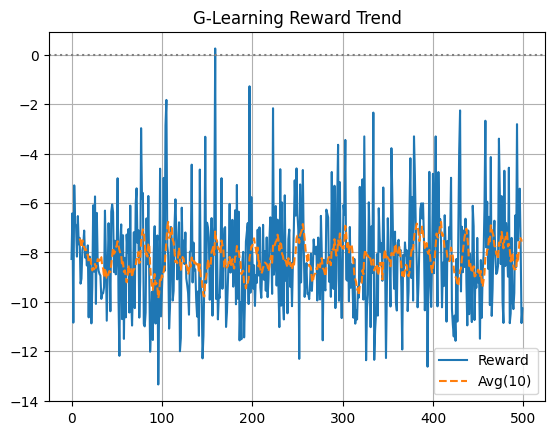

In [ ]:
plt.plot(month_rewards, label="Reward")
plt.plot(pd.Series(month_rewards).rolling(10).mean(), label="Avg(10)", linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.legend(); plt.title("G‑Learning Reward Trend"); plt.grid(True)


Using a stochastic policy during training helps by promoting exploration and smoother learning, but doesn't guarantee optimal actions, which a greedy policy can provide during evaluation.

# Circular training

- This implementation is a two-phase G-learning algorithm that trains an agent in a stock trading environment using a form of curriculum learning. It starts with a short 1-month training window to teach the agent short term dynamics and gradually transitions to a longer 3-month window  after 200 episodes to develop long-term stability and strategic behavior
- The agent selects actions stochastically using a softmax policy derived from G-values and updates these G-values only at the end of each window or when the episode terminates
- This two phase training approach helps by gradually increasing the complexity and stability requirements of the agents behavior



In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

episodes          = 500
short_T, long_T   = 21, 60
baseline_short    = 0.98      # 2 % target on 1‑month window
baseline_long     = 1.05      # 5 % target on 3‑month window
sigma_cap_short   = 0.20
sigma_cap_long    = 0.30
kl_beta           = 0.01
use_sharpe_scaling = True

equity_curves, month_rewards = [], []
pbar = tqdm(range(episodes), desc="Training G‑Learning")

for ep in pbar:
    if ep < 200:
        month_len  = short_T
        baseline   = baseline_short
        sigma_cap  = sigma_cap_short
    else:
        month_len  = long_T
        baseline   = baseline_long
        sigma_cap  = sigma_cap_long

    obs, _ = env_raw.reset()
    equity = [env_raw.unwrapped._total_profit]

    for t in range(month_len):
        s  = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s)
        a  = np.random.choice(ACTIONS, p=pi)

        obs, _, terminated, truncated, _ = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g   = softmax_g(s_next) @ G[s_next]
        reg    = kl_div(pi, pi_ref)

        end_of_window = (t == month_len - 1)
        episode_end   = terminated or truncated

        if end_of_window or episode_end:
            profit      = env_raw.unwrapped._total_profit
            log_return  = np.log(max(profit, 1e-6) / baseline)

            if len(equity) > 2:
                raw_sigma = np.std(np.diff(equity[-month_len:])) + 1e-6
            else:
                raw_sigma = 1.0

            smoothed_sigma = min(raw_sigma, sigma_cap) + 1e-6
            if use_sharpe_scaling and ep >= 200:            # phase2 only
                smoothed_sigma *= np.sqrt(month_len)

            annealed_kl = kl_beta * (1 - ep / episodes)

            reward = log_return / smoothed_sigma - annealed_kl * reg

            G[s][a] = (1 - alpha) * G[s][a] + alpha * (reward + gamma * Ea_g)
            month_rewards.append(reward)

        if episode_end:
            break

    equity_curves.append(equity)

    print(f"Ep {ep+1:>3} | Rwd {month_rewards[-1]:8.4f}")
    pbar.set_description(f"Ep {ep+1} | R: {month_rewards[-1]:.4f}")
    if len(month_rewards) >= 10:
        print(f"Avg(10) {np.mean(month_rewards[-10:]):7.4f}")


Ep 1 | R: -8.6350:   0%|          | 1/500 [00:00<01:22,  6.05it/s]

Ep   1 | Rwd  -8.6350
Ep   2 | Rwd  -5.1935


Ep 4 | R: -8.8878:   1%|          | 4/500 [00:00<01:55,  4.31it/s]

Ep   3 | Rwd  -7.8308
Ep   4 | Rwd  -8.8878


Ep 6 | R: -7.8345:   1%|          | 6/500 [00:01<01:32,  5.37it/s]

Ep   5 | Rwd  -4.0574
Ep   6 | Rwd  -7.8345


Ep 8 | R: -7.5139:   2%|▏         | 8/500 [00:01<01:27,  5.61it/s]

Ep   7 | Rwd  -6.1909
Ep   8 | Rwd  -7.5139


Ep 10 | R: -5.9372:   2%|▏         | 10/500 [00:01<01:14,  6.57it/s]

Ep   9 | Rwd  -7.0683
Ep  10 | Rwd  -5.9372
Avg(10) -6.9149


Ep 12 | R: -8.7594:   2%|▏         | 12/500 [00:02<01:09,  7.03it/s]

Ep  11 | Rwd  -6.2606
Avg(10) -6.6775
Ep  12 | Rwd  -8.7594
Avg(10) -7.0341


Ep 14 | R: -6.4701:   3%|▎         | 14/500 [00:02<01:08,  7.09it/s]

Ep  13 | Rwd  -6.4536
Avg(10) -6.8963
Ep  14 | Rwd  -6.4701
Avg(10) -6.6546


Ep 17 | R: -3.7754:   3%|▎         | 16/500 [00:02<00:56,  8.49it/s]

Ep  15 | Rwd  -9.6062
Avg(10) -7.2095
Ep  16 | Rwd  -4.3821
Avg(10) -6.8642
Ep  17 | Rwd  -3.7754
Avg(10) -6.6227


Ep 20 | R: -6.7133:   4%|▍         | 20/500 [00:02<00:48,  9.98it/s]

Ep  18 | Rwd  -6.1902
Avg(10) -6.4903
Ep  19 | Rwd  -6.2427
Avg(10) -6.4077
Ep  20 | Rwd  -6.7133
Avg(10) -6.4853


Ep 23 | R: -9.0894:   4%|▍         | 22/500 [00:03<00:45, 10.61it/s]

Ep  21 | Rwd  -5.2958
Avg(10) -6.3889
Ep  22 | Rwd  -1.5777
Avg(10) -5.6707
Ep  23 | Rwd  -9.0894
Avg(10) -5.9343


Ep 26 | R: -5.6862:   5%|▌         | 26/500 [00:03<00:43, 10.98it/s]

Ep  24 | Rwd  -8.1702
Avg(10) -6.1043
Ep  25 | Rwd  -3.3955
Avg(10) -5.4832
Ep  26 | Rwd  -5.6862
Avg(10) -5.6136


Ep 29 | R: -3.9047:   6%|▌         | 28/500 [00:03<00:42, 11.01it/s]

Ep  27 | Rwd  -8.0423
Avg(10) -6.0403
Ep  28 | Rwd  -1.7661
Avg(10) -5.5979
Ep  29 | Rwd  -3.9047
Avg(10) -5.3641


Ep 31 | R: -6.7319:   6%|▌         | 30/500 [00:03<00:42, 11.05it/s]

Ep  30 | Rwd  -4.7370
Avg(10) -5.1665
Ep  31 | Rwd  -6.7319
Avg(10) -5.3101


Ep 34 | R: -7.7282:   7%|▋         | 34/500 [00:04<00:47,  9.84it/s]

Ep  32 | Rwd  -3.8120
Avg(10) -5.5335
Ep  33 | Rwd  -5.7564
Avg(10) -5.2002
Ep  34 | Rwd  -7.7282
Avg(10) -5.1560


Ep 37 | R: -8.3809:   7%|▋         | 36/500 [00:04<00:45, 10.25it/s]

Ep  35 | Rwd  -4.6539
Avg(10) -5.2819
Ep  36 | Rwd  -5.2018
Avg(10) -5.2334
Ep  37 | Rwd  -8.3809
Avg(10) -5.2673


Ep 40 | R: -2.4190:   8%|▊         | 40/500 [00:04<00:44, 10.38it/s]

Ep  38 | Rwd  -5.3014
Avg(10) -5.6208
Ep  39 | Rwd  -8.1231
Avg(10) -6.0426
Ep  40 | Rwd  -2.4190
Avg(10) -5.8109


Ep 43 | R: -5.9751:   8%|▊         | 42/500 [00:05<00:42, 10.79it/s]

Ep  41 | Rwd  -8.1683
Avg(10) -5.9545
Ep  42 | Rwd  -4.7360
Avg(10) -6.0469
Ep  43 | Rwd  -5.9751
Avg(10) -6.0688


Ep 46 | R: -6.3882:   9%|▉         | 46/500 [00:05<00:39, 11.42it/s]

Ep  44 | Rwd  -4.2700
Avg(10) -5.7229
Ep  45 | Rwd  -5.8377
Avg(10) -5.8413
Ep  46 | Rwd  -6.3882
Avg(10) -5.9600


Ep 49 | R: -7.6140:  10%|▉         | 48/500 [00:05<00:40, 11.23it/s]

Ep  47 | Rwd  -5.1864
Avg(10) -5.6405
Ep  48 | Rwd  -4.6625
Avg(10) -5.5766
Ep  49 | Rwd  -7.6140
Avg(10) -5.5257


Ep 53 | R: -6.6948:  10%|█         | 52/500 [00:05<00:33, 13.37it/s]

Ep  50 | Rwd  -7.4076
Avg(10) -6.0246
Ep  51 | Rwd  -5.0672
Avg(10) -5.7145
Ep  52 | Rwd  -6.7085
Avg(10) -5.9117
Ep  53 | Rwd  -6.6948
Avg(10) -5.9837


Ep 57 | R: -4.6810:  11%|█         | 56/500 [00:06<00:29, 15.13it/s]

Ep  54 | Rwd  -6.4255
Avg(10) -6.1992
Ep  55 | Rwd  -6.0996
Avg(10) -6.2254
Ep  56 | Rwd  -9.2050
Avg(10) -6.5071
Ep  57 | Rwd  -4.6810
Avg(10) -6.4566


Ep 61 | R: -7.2055:  12%|█▏        | 60/500 [00:06<00:27, 16.17it/s]

Ep  58 | Rwd  -4.3508
Avg(10) -6.4254
Ep  59 | Rwd  -5.2458
Avg(10) -6.1886
Ep  60 | Rwd  -6.2698
Avg(10) -6.0748
Ep  61 | Rwd  -7.2055
Avg(10) -6.2886


Ep 64 | R: -4.5224:  13%|█▎        | 64/500 [00:06<00:31, 14.05it/s]

Ep  62 | Rwd  -8.0081
Avg(10) -6.4186
Ep  63 | Rwd  -7.4441
Avg(10) -6.4935
Ep  64 | Rwd  -4.5224
Avg(10) -6.3032


Ep 68 | R: -7.7978:  14%|█▎        | 68/500 [00:06<00:28, 15.40it/s]

Ep  65 | Rwd  -6.8044
Avg(10) -6.3737
Ep  66 | Rwd  -5.5537
Avg(10) -6.0086
Ep  67 | Rwd  -4.0046
Avg(10) -5.9409
Ep  68 | Rwd  -7.7978
Avg(10) -6.2856


Ep 72 | R: -5.7065:  14%|█▍        | 72/500 [00:06<00:25, 16.49it/s]

Ep  69 | Rwd  -2.2001
Avg(10) -5.9811
Ep  70 | Rwd  -6.5331
Avg(10) -6.0074
Ep  71 | Rwd  -6.0559
Avg(10) -5.8924
Ep  72 | Rwd  -5.7065
Avg(10) -5.6622


Ep 76 | R: -5.5780:  15%|█▌        | 76/500 [00:07<00:24, 17.18it/s]

Ep  73 | Rwd  -6.6084
Avg(10) -5.5787
Ep  74 | Rwd  -9.6980
Avg(10) -6.0962
Ep  75 | Rwd  -8.1147
Avg(10) -6.2273
Ep  76 | Rwd  -5.5780
Avg(10) -6.2297


Ep 79 | R: -5.2180:  16%|█▌        | 78/500 [00:07<00:28, 14.63it/s]

Ep  77 | Rwd  -4.7494
Avg(10) -6.3042
Ep  78 | Rwd  -7.4086
Avg(10) -6.2653
Ep  79 | Rwd  -5.2180
Avg(10) -6.5671


Ep 83 | R: -6.0156:  16%|█▋        | 82/500 [00:07<00:26, 15.70it/s]

Ep  80 | Rwd  -6.3521
Avg(10) -6.5490
Ep  81 | Rwd  -9.2869
Avg(10) -6.8721
Ep  82 | Rwd  -4.5148
Avg(10) -6.7529
Ep  83 | Rwd  -6.0156
Avg(10) -6.6936


Ep 87 | R: -3.8288:  17%|█▋        | 86/500 [00:07<00:29, 14.25it/s]

Ep  84 | Rwd  -7.0751
Avg(10) -6.4313
Ep  85 | Rwd  -2.8246
Avg(10) -5.9023
Ep  86 | Rwd  -7.8323
Avg(10) -6.1277
Ep  87 | Rwd  -3.8288
Avg(10) -6.0357


Ep 91 | R: -4.8499:  18%|█▊        | 90/500 [00:08<00:26, 15.61it/s]

Ep  88 | Rwd  -6.0634
Avg(10) -5.9011
Ep  89 | Rwd  -7.0801
Avg(10) -6.0874
Ep  90 | Rwd  -9.7906
Avg(10) -6.4312
Ep  91 | Rwd  -4.8499
Avg(10) -5.9875


Ep 95 | R: -9.8253:  19%|█▉        | 94/500 [00:08<00:25, 16.15it/s]

Ep  92 | Rwd  -8.0904
Avg(10) -6.3451
Ep  93 | Rwd  -7.0411
Avg(10) -6.4476
Ep  94 | Rwd  -4.0148
Avg(10) -6.1416
Ep  95 | Rwd  -9.8253
Avg(10) -6.8417


Ep 99 | R: -7.7676:  20%|█▉        | 98/500 [00:08<00:23, 16.87it/s]

Ep  96 | Rwd  -5.0311
Avg(10) -6.5615
Ep  97 | Rwd  -6.8801
Avg(10) -6.8667
Ep  98 | Rwd  -4.9985
Avg(10) -6.7602
Ep  99 | Rwd  -7.7676
Avg(10) -6.8289


Ep 103 | R: -5.6641:  20%|██        | 102/500 [00:08<00:23, 16.79it/s]

Ep 100 | Rwd  -6.6805
Avg(10) -6.5179
Ep 101 | Rwd  -7.6535
Avg(10) -6.7983
Ep 102 | Rwd  -5.4120
Avg(10) -6.5304
Ep 103 | Rwd  -5.6641
Avg(10) -6.3928


Ep 107 | R: -4.5014:  21%|██        | 106/500 [00:09<00:22, 17.39it/s]

Ep 104 | Rwd  -7.5544
Avg(10) -6.7467
Ep 105 | Rwd  -7.0910
Avg(10) -6.4733
Ep 106 | Rwd  -4.8982
Avg(10) -6.4600
Ep 107 | Rwd  -4.5014
Avg(10) -6.2221


Ep 110 | R: -10.0641:  22%|██▏       | 110/500 [00:09<00:22, 17.51it/s]

Ep 108 | Rwd  -8.1023
Avg(10) -6.5325
Ep 109 | Rwd  -6.4614
Avg(10) -6.4019
Ep 110 | Rwd -10.0641
Avg(10) -6.7402


Ep 114 | R: -6.1616:  23%|██▎       | 114/500 [00:09<00:24, 15.60it/s]

Ep 111 | Rwd  -6.1556
Avg(10) -6.5905
Ep 112 | Rwd  -8.0641
Avg(10) -6.8557
Ep 113 | Rwd  -8.4919
Avg(10) -7.1384
Ep 114 | Rwd  -6.1616
Avg(10) -6.9992


Ep 118 | R: -6.8171:  24%|██▎       | 118/500 [00:09<00:23, 15.96it/s]

Ep 115 | Rwd  -7.1573
Avg(10) -7.0058
Ep 116 | Rwd  -6.9146
Avg(10) -7.2074
Ep 117 | Rwd  -6.1749
Avg(10) -7.3748
Ep 118 | Rwd  -6.8171
Avg(10) -7.2463


Ep 122 | R: -8.4019:  24%|██▍       | 122/500 [00:10<00:22, 16.74it/s]

Ep 119 | Rwd  -5.0788
Avg(10) -7.1080
Ep 120 | Rwd  -4.5984
Avg(10) -6.5614
Ep 121 | Rwd  -4.6950
Avg(10) -6.4154
Ep 122 | Rwd  -8.4019
Avg(10) -6.4492


Ep 126 | R: -6.5152:  25%|██▌       | 126/500 [00:10<00:22, 16.77it/s]

Ep 123 | Rwd  -7.6291
Avg(10) -6.3629
Ep 124 | Rwd  -7.8265
Avg(10) -6.5294
Ep 125 | Rwd  -9.3181
Avg(10) -6.7454
Ep 126 | Rwd  -6.5152
Avg(10) -6.7055


Ep 130 | R: -9.8852:  26%|██▌       | 130/500 [00:10<00:24, 15.41it/s]

Ep 127 | Rwd  -6.3559
Avg(10) -6.7236
Ep 128 | Rwd  -8.2299
Avg(10) -6.8649
Ep 129 | Rwd  -4.9071
Avg(10) -6.8477
Ep 130 | Rwd  -9.8852
Avg(10) -7.3764


Ep 134 | R: -7.9002:  27%|██▋       | 134/500 [00:10<00:23, 15.74it/s]

Ep 131 | Rwd  -6.8594
Avg(10) -7.5928
Ep 132 | Rwd  -5.8446
Avg(10) -7.3371
Ep 133 | Rwd  -5.8188
Avg(10) -7.1561
Ep 134 | Rwd  -7.9002
Avg(10) -7.1634


Ep 138 | R: -10.4084:  28%|██▊       | 138/500 [00:11<00:21, 16.75it/s]

Ep 135 | Rwd  -7.4647
Avg(10) -6.9781
Ep 136 | Rwd  -8.0854
Avg(10) -7.1351
Ep 137 | Rwd  -5.2278
Avg(10) -7.0223
Ep 138 | Rwd -10.4084
Avg(10) -7.2402


Ep 142 | R: -5.3981:  28%|██▊       | 142/500 [00:11<00:21, 16.86it/s]

Ep 139 | Rwd  -4.8134
Avg(10) -7.2308
Ep 140 | Rwd  -5.0547
Avg(10) -6.7477
Ep 141 | Rwd  -6.7853
Avg(10) -6.7403
Ep 142 | Rwd  -5.3981
Avg(10) -6.6957


Ep 146 | R: -7.3403:  29%|██▉       | 146/500 [00:11<00:22, 15.42it/s]

Ep 143 | Rwd -10.1146
Avg(10) -7.1253
Ep 144 | Rwd  -7.0855
Avg(10) -7.0438
Ep 145 | Rwd  -7.8471
Avg(10) -7.0820
Ep 146 | Rwd  -7.3403
Avg(10) -7.0075


Ep 150 | R: -4.5542:  30%|███       | 150/500 [00:11<00:21, 16.54it/s]

Ep 147 | Rwd  -6.6237
Avg(10) -7.1471
Ep 148 | Rwd  -4.9880
Avg(10) -6.6051
Ep 149 | Rwd  -4.8783
Avg(10) -6.6116
Ep 150 | Rwd  -4.5542
Avg(10) -6.5615


Ep 154 | R: -7.2588:  31%|███       | 154/500 [00:12<00:20, 16.78it/s]

Ep 151 | Rwd  -9.4145
Avg(10) -6.8244
Ep 152 | Rwd  -1.3988
Avg(10) -6.4245
Ep 153 | Rwd  -7.5632
Avg(10) -6.1694
Ep 154 | Rwd  -7.2588
Avg(10) -6.1867


Ep 158 | R: -8.3601:  32%|███▏      | 158/500 [00:12<00:20, 16.78it/s]

Ep 155 | Rwd  -6.7633
Avg(10) -6.0783
Ep 156 | Rwd  -5.8472
Avg(10) -5.9290
Ep 157 | Rwd  -4.7262
Avg(10) -5.7392
Ep 158 | Rwd  -8.3601
Avg(10) -6.0764


Ep 160 | R: -4.7832:  32%|███▏      | 160/500 [00:12<00:27, 12.48it/s]

Ep 159 | Rwd  -6.4144
Avg(10) -6.2301
Ep 160 | Rwd  -4.7832
Avg(10) -6.2530


Ep 163 | R: -4.3260:  32%|███▏      | 162/500 [00:12<00:27, 12.18it/s] 

Ep 161 | Rwd  -7.7143
Avg(10) -6.0829
Ep 162 | Rwd -10.0181
Avg(10) -6.9449
Ep 163 | Rwd  -4.3260
Avg(10) -6.6212


Ep 166 | R: -6.6456:  33%|███▎      | 166/500 [00:13<00:26, 12.46it/s]

Ep 164 | Rwd  -6.8751
Avg(10) -6.5828
Ep 165 | Rwd  -9.9710
Avg(10) -6.9036
Ep 166 | Rwd  -6.6456
Avg(10) -6.9834


Ep 169 | R: -7.3414:  34%|███▎      | 168/500 [00:13<00:25, 12.84it/s]

Ep 167 | Rwd  -7.5070
Avg(10) -7.2615
Ep 168 | Rwd  -2.5352
Avg(10) -6.6790
Ep 169 | Rwd  -7.3414
Avg(10) -6.7717


Ep 171 | R: -11.2430:  34%|███▍      | 170/500 [00:13<00:29, 11.18it/s]

Ep 170 | Rwd  -7.4539
Avg(10) -7.0388
Ep 171 | Rwd -11.2430
Avg(10) -7.3916


Ep 174 | R: -9.6606:  35%|███▍      | 174/500 [00:13<00:28, 11.43it/s]

Ep 172 | Rwd  -9.7746
Avg(10) -7.3673
Ep 173 | Rwd  -7.9432
Avg(10) -7.7290
Ep 174 | Rwd  -9.6606
Avg(10) -8.0075


Ep 177 | R: -7.0214:  35%|███▌      | 176/500 [00:14<00:26, 12.00it/s]

Ep 175 | Rwd  -4.5650
Avg(10) -7.4669
Ep 176 | Rwd  -8.2432
Avg(10) -7.6267
Ep 177 | Rwd  -7.0214
Avg(10) -7.5781


Ep 180 | R: -5.7418:  36%|███▌      | 180/500 [00:14<00:25, 12.59it/s]

Ep 178 | Rwd  -9.8139
Avg(10) -8.3060
Ep 179 | Rwd  -8.2658
Avg(10) -8.3984
Ep 180 | Rwd  -5.7418
Avg(10) -8.2272


Ep 182 | R: -2.3236:  36%|███▋      | 182/500 [00:14<00:30, 10.53it/s]

Ep 181 | Rwd  -8.4489
Avg(10) -7.9478
Ep 182 | Rwd  -2.3236
Avg(10) -7.2027


Ep 185 | R: -6.5636:  37%|███▋      | 184/500 [00:14<00:29, 10.67it/s]

Ep 183 | Rwd  -4.4514
Avg(10) -6.8535
Ep 184 | Rwd  -7.4357
Avg(10) -6.6311
Ep 185 | Rwd  -6.5636
Avg(10) -6.8309


Ep 188 | R: -5.5508:  38%|███▊      | 188/500 [00:15<00:27, 11.40it/s]

Ep 186 | Rwd  -4.7173
Avg(10) -6.4783
Ep 187 | Rwd  -6.5339
Avg(10) -6.4296
Ep 188 | Rwd  -5.5508
Avg(10) -6.0033


Ep 191 | R: -6.1931:  38%|███▊      | 190/500 [00:15<00:27, 11.32it/s]

Ep 189 | Rwd  -8.5476
Avg(10) -6.0314
Ep 190 | Rwd  -6.9277
Avg(10) -6.1500
Ep 191 | Rwd  -6.1931
Avg(10) -5.9245


Ep 194 | R: -7.6465:  39%|███▉      | 194/500 [00:15<00:25, 12.05it/s]

Ep 192 | Rwd  -6.2952
Avg(10) -6.3216
Ep 193 | Rwd  -4.6282
Avg(10) -6.3393
Ep 194 | Rwd  -7.6465
Avg(10) -6.3604


Ep 198 | R: -4.1362:  40%|███▉      | 198/500 [00:15<00:21, 14.08it/s]

Ep 195 | Rwd  -6.0643
Avg(10) -6.3104
Ep 196 | Rwd  -6.3892
Avg(10) -6.4776
Ep 197 | Rwd  -4.3941
Avg(10) -6.2637
Ep 198 | Rwd  -4.1362
Avg(10) -6.1222


Ep 200 | R: -5.9590:  40%|████      | 200/500 [00:15<00:20, 14.71it/s]

Ep 199 | Rwd  -6.3815
Avg(10) -5.9056
Ep 200 | Rwd  -5.9590
Avg(10) -5.8087


Ep 202 | R: -3.7463:  40%|████      | 202/500 [00:16<00:28, 10.35it/s]

Ep 201 | Rwd  -1.9357
Avg(10) -5.3830
Ep 202 | Rwd  -3.7463
Avg(10) -5.1281


Ep 204 | R: -2.3775:  41%|████      | 204/500 [00:16<00:37,  7.93it/s]

Ep 203 | Rwd  -1.3993
Avg(10) -4.8052
Ep 204 | Rwd  -2.3775
Avg(10) -4.2783


Ep 206 | R: -3.1839:  41%|████      | 206/500 [00:16<00:39,  7.39it/s]

Ep 205 | Rwd  -3.0530
Avg(10) -3.9772
Ep 206 | Rwd  -3.1839
Avg(10) -3.6566


Ep 208 | R: -2.3704:  42%|████▏     | 208/500 [00:17<00:41,  7.00it/s]

Ep 207 | Rwd  -3.4007
Avg(10) -3.5573
Ep 208 | Rwd  -2.3704
Avg(10) -3.3807


Ep 210 | R: -3.2975:  42%|████▏     | 210/500 [00:17<00:46,  6.22it/s]

Ep 209 | Rwd  -3.5394
Avg(10) -3.0965
Ep 210 | Rwd  -3.2975
Avg(10) -2.8304


Ep 212 | R: -1.9713:  42%|████▏     | 212/500 [00:17<00:45,  6.33it/s]

Ep 211 | Rwd  -2.5635
Avg(10) -2.8932
Ep 212 | Rwd  -1.9713
Avg(10) -2.7157


Ep 214 | R: -3.0938:  43%|████▎     | 214/500 [00:18<00:46,  6.20it/s]

Ep 213 | Rwd  -2.7329
Avg(10) -2.8490
Ep 214 | Rwd  -3.0938
Avg(10) -2.9206


Ep 216 | R: -3.1998:  43%|████▎     | 216/500 [00:18<00:48,  5.84it/s]

Ep 215 | Rwd  -1.7633
Avg(10) -2.7917
Ep 216 | Rwd  -3.1998
Avg(10) -2.7933


Ep 218 | R: -3.9948:  44%|████▎     | 218/500 [00:18<00:50,  5.63it/s]

Ep 217 | Rwd  -3.0411
Avg(10) -2.7573
Ep 218 | Rwd  -3.9948
Avg(10) -2.9197


Ep 220 | R: -2.9129:  44%|████▍     | 220/500 [00:19<00:47,  5.92it/s]

Ep 219 | Rwd  -2.7192
Avg(10) -2.8377
Ep 220 | Rwd  -2.9129
Avg(10) -2.7993


Ep 222 | R: -3.0396:  44%|████▍     | 222/500 [00:19<00:45,  6.14it/s]

Ep 221 | Rwd  -2.3956
Avg(10) -2.7825
Ep 222 | Rwd  -3.0396
Avg(10) -2.8893


Ep 224 | R: -2.4414:  45%|████▍     | 224/500 [00:19<00:43,  6.33it/s]

Ep 223 | Rwd  -3.8823
Avg(10) -3.0042
Ep 224 | Rwd  -2.4414
Avg(10) -2.9390


Ep 226 | R: -2.1631:  45%|████▌     | 226/500 [00:20<00:42,  6.50it/s]

Ep 225 | Rwd  -3.4370
Avg(10) -3.1064
Ep 226 | Rwd  -2.1631
Avg(10) -3.0027


Ep 228 | R: -3.2710:  46%|████▌     | 228/500 [00:20<00:45,  5.93it/s]

Ep 227 | Rwd  -4.2278
Avg(10) -3.1214
Ep 228 | Rwd  -3.2710
Avg(10) -3.0490


Ep 230 | R: -1.9463:  46%|████▌     | 230/500 [00:20<00:43,  6.16it/s]

Ep 229 | Rwd  -2.6595
Avg(10) -3.0430
Ep 230 | Rwd  -1.9463
Avg(10) -2.9464


Ep 232 | R: -3.4011:  46%|████▋     | 232/500 [00:21<00:41,  6.40it/s]

Ep 231 | Rwd  -2.1120
Avg(10) -2.9180
Ep 232 | Rwd  -3.4011
Avg(10) -2.9542


Ep 234 | R: -4.1895:  47%|████▋     | 234/500 [00:21<00:46,  5.73it/s]

Ep 233 | Rwd  -3.3161
Avg(10) -2.8975
Ep 234 | Rwd  -4.1895
Avg(10) -3.0723


Ep 236 | R: -1.9613:  47%|████▋     | 236/500 [00:21<00:43,  6.10it/s]

Ep 235 | Rwd  -3.9770
Avg(10) -3.1263
Ep 236 | Rwd  -1.9613
Avg(10) -3.1062


Ep 238 | R: -1.9375:  48%|████▊     | 238/500 [00:22<00:41,  6.31it/s]

Ep 237 | Rwd  -4.3616
Avg(10) -3.1195
Ep 238 | Rwd  -1.9375
Avg(10) -2.9862


Ep 240 | R: -2.4029:  48%|████▊     | 240/500 [00:22<00:45,  5.78it/s]

Ep 239 | Rwd  -2.4247
Avg(10) -2.9627
Ep 240 | Rwd  -2.4029
Avg(10) -3.0084


Ep 242 | R: -2.0035:  48%|████▊     | 242/500 [00:22<00:41,  6.17it/s]

Ep 241 | Rwd  -2.9694
Avg(10) -3.0941
Ep 242 | Rwd  -2.0035
Avg(10) -2.9543


Ep 244 | R: -2.1740:  49%|████▉     | 244/500 [00:23<00:40,  6.27it/s]

Ep 243 | Rwd  -3.4243
Avg(10) -2.9652
Ep 244 | Rwd  -2.1740
Avg(10) -2.7636


Ep 246 | R: -2.1181:  49%|████▉     | 246/500 [00:23<00:44,  5.74it/s]

Ep 245 | Rwd  -2.5492
Avg(10) -2.6208
Ep 246 | Rwd  -2.1181
Avg(10) -2.6365


Ep 248 | R: -2.9587:  50%|████▉     | 248/500 [00:23<00:41,  6.10it/s]

Ep 247 | Rwd  -2.7398
Avg(10) -2.4743
Ep 248 | Rwd  -2.9587
Avg(10) -2.5765


Ep 250 | R: -1.8899:  50%|█████     | 250/500 [00:24<00:39,  6.31it/s]

Ep 249 | Rwd  -2.5804
Avg(10) -2.5920
Ep 250 | Rwd  -1.8899
Avg(10) -2.5407


Ep 252 | R: -3.2769:  50%|█████     | 252/500 [00:24<00:43,  5.76it/s]

Ep 251 | Rwd  -2.3258
Avg(10) -2.4764
Ep 252 | Rwd  -3.2769
Avg(10) -2.6037


Ep 254 | R: -1.5275:  51%|█████     | 254/500 [00:24<00:39,  6.18it/s]

Ep 253 | Rwd  -2.7441
Avg(10) -2.5357
Ep 254 | Rwd  -1.5275
Avg(10) -2.4710


Ep 256 | R: -2.4417:  51%|█████     | 256/500 [00:25<00:40,  6.02it/s]

Ep 255 | Rwd  -3.2286
Avg(10) -2.5390
Ep 256 | Rwd  -2.4417
Avg(10) -2.5713


Ep 258 | R: -2.4095:  51%|█████▏    | 257/500 [00:25<00:54,  4.44it/s]

Ep 257 | Rwd  -2.9182
Avg(10) -2.5892
Ep 258 | Rwd  -2.4095


Ep 259 | R: -2.5659:  52%|█████▏    | 258/500 [00:26<00:52,  4.59it/s]

Avg(10) -2.5343
Ep 259 | Rwd  -2.5659


Ep 259 | R: -2.5659:  52%|█████▏    | 259/500 [00:26<00:51,  4.68it/s]

Avg(10) -2.5328


Ep 260 | R: -4.8121:  52%|█████▏    | 260/500 [00:26<00:51,  4.69it/s]

Ep 260 | Rwd  -4.8121
Avg(10) -2.8250


Ep 261 | R: -1.5602:  52%|█████▏    | 261/500 [00:26<01:01,  3.89it/s]

Ep 261 | Rwd  -1.5602
Avg(10) -2.7485


Ep 262 | R: -3.2373:  52%|█████▏    | 262/500 [00:26<00:58,  4.09it/s]

Ep 262 | Rwd  -3.2373
Avg(10) -2.7445


Ep 263 | R: -3.4359:  53%|█████▎    | 263/500 [00:27<00:55,  4.30it/s]

Ep 263 | Rwd  -3.4359
Avg(10) -2.8137


Ep 264 | R: -3.3561:  53%|█████▎    | 264/500 [00:27<00:54,  4.34it/s]

Ep 264 | Rwd  -3.3561
Avg(10) -2.9966


Ep 265 | R: -2.6936:  53%|█████▎    | 265/500 [00:27<01:03,  3.68it/s]

Ep 265 | Rwd  -2.6936
Avg(10) -2.9431


Ep 267 | R: -2.9133:  53%|█████▎    | 267/500 [00:28<00:54,  4.26it/s]

Ep 266 | Rwd  -2.5932
Avg(10) -2.9582
Ep 267 | Rwd  -2.9133
Avg(10) -2.9577


Ep 268 | R: -1.7383:  54%|█████▎    | 268/500 [00:28<00:49,  4.72it/s]

Ep 268 | Rwd  -1.7383
Avg(10) -2.8906


Ep 270 | R: -3.5731:  54%|█████▍    | 270/500 [00:28<00:45,  5.05it/s]

Ep 269 | Rwd  -2.2125
Avg(10) -2.8553
Ep 270 | Rwd  -3.5731
Avg(10) -2.7314


Ep 272 | R: -1.8002:  54%|█████▍    | 272/500 [00:28<00:41,  5.45it/s]

Ep 271 | Rwd  -1.8203
Avg(10) -2.7574
Ep 272 | Rwd  -1.8002
Avg(10) -2.6137


Ep 274 | R: -2.9736:  55%|█████▍    | 274/500 [00:29<00:38,  5.89it/s]

Ep 273 | Rwd  -2.0345
Avg(10) -2.4735
Ep 274 | Rwd  -2.9736
Avg(10) -2.4353


Ep 276 | R: -1.8526:  55%|█████▌    | 276/500 [00:29<00:39,  5.66it/s]

Ep 275 | Rwd  -3.6548
Avg(10) -2.5314
Ep 276 | Rwd  -1.8526
Avg(10) -2.4573


Ep 278 | R: -3.2765:  56%|█████▌    | 278/500 [00:29<00:37,  5.98it/s]

Ep 277 | Rwd  -1.3704
Avg(10) -2.3030
Ep 278 | Rwd  -3.2765
Avg(10) -2.4569


Ep 280 | R: -2.6757:  56%|█████▌    | 280/500 [00:30<00:35,  6.26it/s]

Ep 279 | Rwd  -1.2610
Avg(10) -2.3617
Ep 280 | Rwd  -2.6757
Avg(10) -2.2720


Ep 282 | R: -4.3047:  56%|█████▋    | 282/500 [00:30<00:37,  5.78it/s]

Ep 281 | Rwd  -2.4420
Avg(10) -2.3341
Ep 282 | Rwd  -4.3047
Avg(10) -2.5846


Ep 284 | R: -2.2620:  57%|█████▋    | 284/500 [00:30<00:35,  6.06it/s]

Ep 283 | Rwd  -1.7973
Avg(10) -2.5609
Ep 284 | Rwd  -2.2620
Avg(10) -2.4897


Ep 286 | R: -3.1221:  57%|█████▋    | 286/500 [00:31<00:33,  6.36it/s]

Ep 285 | Rwd  -2.7134
Avg(10) -2.3956
Ep 286 | Rwd  -3.1221
Avg(10) -2.5225


Ep 288 | R: -2.1258:  58%|█████▊    | 288/500 [00:31<00:36,  5.87it/s]

Ep 287 | Rwd  -1.7065
Avg(10) -2.5561
Ep 288 | Rwd  -2.1258
Avg(10) -2.4411


Ep 290 | R: -2.2921:  58%|█████▊    | 290/500 [00:31<00:34,  6.11it/s]

Ep 289 | Rwd  -3.9292
Avg(10) -2.7079
Ep 290 | Rwd  -2.2921
Avg(10) -2.6695


Ep 292 | R: -2.7813:  58%|█████▊    | 292/500 [00:32<00:32,  6.33it/s]

Ep 291 | Rwd  -2.1575
Avg(10) -2.6411
Ep 292 | Rwd  -2.7813
Avg(10) -2.4887


Ep 294 | R: -3.5964:  59%|█████▉    | 294/500 [00:32<00:34,  5.90it/s]

Ep 293 | Rwd  -2.3516
Avg(10) -2.5441
Ep 294 | Rwd  -3.5964
Avg(10) -2.6776


Ep 296 | R: -2.3683:  59%|█████▉    | 296/500 [00:32<00:33,  6.03it/s]

Ep 295 | Rwd  -2.4444
Avg(10) -2.6507
Ep 296 | Rwd  -2.3683
Avg(10) -2.5753


Ep 298 | R: -1.9319:  60%|█████▉    | 298/500 [00:33<00:32,  6.25it/s]

Ep 297 | Rwd  -3.1831
Avg(10) -2.7230
Ep 298 | Rwd  -1.9319
Avg(10) -2.7036


Ep 300 | R: -3.1405:  60%|██████    | 300/500 [00:33<00:34,  5.85it/s]

Ep 299 | Rwd  -2.9885
Avg(10) -2.6095
Ep 300 | Rwd  -3.1405
Avg(10) -2.6943


Ep 302 | R: -3.1341:  60%|██████    | 302/500 [00:33<00:32,  6.04it/s]

Ep 301 | Rwd  -2.6677
Avg(10) -2.7454
Ep 302 | Rwd  -3.1341
Avg(10) -2.7806


Ep 304 | R: -3.1988:  61%|██████    | 304/500 [00:34<00:31,  6.19it/s]

Ep 303 | Rwd  -1.7709
Avg(10) -2.7226
Ep 304 | Rwd  -3.1988
Avg(10) -2.6828


Ep 306 | R: -3.0940:  61%|██████    | 306/500 [00:34<00:33,  5.76it/s]

Ep 305 | Rwd  -3.8313
Avg(10) -2.8215
Ep 306 | Rwd  -3.0940
Avg(10) -2.8941


Ep 308 | R: -3.5378:  62%|██████▏   | 308/500 [00:34<00:32,  5.98it/s]

Ep 307 | Rwd  -4.0071
Avg(10) -2.9765
Ep 308 | Rwd  -3.5378
Avg(10) -3.1371


Ep 310 | R: -2.5124:  62%|██████▏   | 310/500 [00:35<00:30,  6.29it/s]

Ep 309 | Rwd  -2.9930
Avg(10) -3.1375
Ep 310 | Rwd  -2.5124
Avg(10) -3.0747


Ep 312 | R: -3.5079:  62%|██████▏   | 312/500 [00:35<00:33,  5.64it/s]

Ep 311 | Rwd  -3.4739
Avg(10) -3.1553
Ep 312 | Rwd  -3.5079
Avg(10) -3.1927


Ep 314 | R: -2.0930:  63%|██████▎   | 314/500 [00:36<00:31,  5.92it/s]

Ep 313 | Rwd  -2.8797
Avg(10) -3.3036
Ep 314 | Rwd  -2.0930
Avg(10) -3.1930


Ep 316 | R: -2.8556:  63%|██████▎   | 316/500 [00:36<00:29,  6.19it/s]

Ep 315 | Rwd  -4.0375
Avg(10) -3.2136
Ep 316 | Rwd  -2.8556
Avg(10) -3.1898


Ep 318 | R: -1.4108:  64%|██████▎   | 318/500 [00:36<00:31,  5.79it/s]

Ep 317 | Rwd  -2.9841
Avg(10) -3.0875
Ep 318 | Rwd  -1.4108
Avg(10) -2.8748


Ep 320 | R: -2.9540:  64%|██████▍   | 320/500 [00:37<00:30,  5.99it/s]

Ep 319 | Rwd  -2.5017
Avg(10) -2.8257
Ep 320 | Rwd  -2.9540
Avg(10) -2.8698


Ep 321 | R: -0.3465:  64%|██████▍   | 321/500 [00:37<00:29,  6.06it/s]

Ep 321 | Rwd  -0.3465
Avg(10) -2.5571


Ep 323 | R: -2.8333:  65%|██████▍   | 323/500 [00:37<00:30,  5.74it/s]

Ep 322 | Rwd  -1.4556
Avg(10) -2.3518
Ep 323 | Rwd  -2.8333
Avg(10) -2.3472


Ep 325 | R: -1.5950:  65%|██████▌   | 325/500 [00:37<00:31,  5.56it/s]

Ep 324 | Rwd  -2.5171
Avg(10) -2.3896
Ep 325 | Rwd  -1.5950
Avg(10) -2.1454


Ep 326 | R: -1.9288:  65%|██████▌   | 326/500 [00:38<00:33,  5.17it/s]

Ep 326 | Rwd  -1.9288
Avg(10) -2.0527


Ep 328 | R: -4.0688:  66%|██████▌   | 328/500 [00:38<00:33,  5.12it/s]

Ep 327 | Rwd  -3.1510
Avg(10) -2.0694
Ep 328 | Rwd  -4.0688
Avg(10) -2.3352


Ep 329 | R: -2.7421:  66%|██████▌   | 329/500 [00:38<00:33,  5.07it/s]

Ep 329 | Rwd  -2.7421
Avg(10) -2.3592


Ep 330 | R: -3.4322:  66%|██████▌   | 330/500 [00:38<00:33,  5.00it/s]

Ep 330 | Rwd  -3.4322
Avg(10) -2.4070


Ep 331 | R: -2.9415:  66%|██████▌   | 331/500 [00:39<00:34,  4.86it/s]

Ep 331 | Rwd  -2.9415
Avg(10) -2.6665


Ep 332 | R: -2.7517:  66%|██████▋   | 332/500 [00:39<00:38,  4.41it/s]

Ep 332 | Rwd  -2.7517
Avg(10) -2.7962


Ep 333 | R: -1.9814:  67%|██████▋   | 333/500 [00:39<00:39,  4.21it/s]

Ep 333 | Rwd  -1.9814
Avg(10) -2.7110


Ep 334 | R: -2.2716:  67%|██████▋   | 334/500 [00:39<00:38,  4.31it/s]

Ep 334 | Rwd  -2.2716
Avg(10) -2.6864


Ep 335 | R: -2.5840:  67%|██████▋   | 335/500 [00:40<00:37,  4.43it/s]

Ep 335 | Rwd  -2.5840
Avg(10) -2.7853


Ep 336 | R: -3.1469:  67%|██████▋   | 336/500 [00:40<00:37,  4.42it/s]

Ep 336 | Rwd  -3.1469
Avg(10) -2.9071


Ep 338 | R: -3.2956:  68%|██████▊   | 338/500 [00:40<00:34,  4.66it/s]

Ep 337 | Rwd  -3.8042
Avg(10) -2.9724
Ep 338 | Rwd  -3.2956
Avg(10) -2.8951


Ep 340 | R: -3.7108:  68%|██████▊   | 340/500 [00:41<00:29,  5.34it/s]

Ep 339 | Rwd  -3.1696
Avg(10) -2.9379
Ep 340 | Rwd  -3.7108
Avg(10) -2.9657


Ep 341 | R: -3.4619:  68%|██████▊   | 341/500 [00:41<00:29,  5.44it/s]

Ep 341 | Rwd  -3.4619
Avg(10) -3.0178


Ep 343 | R: -3.2997:  69%|██████▊   | 343/500 [00:41<00:29,  5.37it/s]

Ep 342 | Rwd  -3.0768
Avg(10) -3.0503
Ep 343 | Rwd  -3.2997
Avg(10) -3.1821


Ep 345 | R: -3.9963:  69%|██████▉   | 345/500 [00:41<00:25,  5.97it/s]

Ep 344 | Rwd  -2.5986
Avg(10) -3.2148
Ep 345 | Rwd  -3.9963
Avg(10) -3.3560


Ep 347 | R: -3.7495:  69%|██████▉   | 347/500 [00:42<00:25,  6.04it/s]

Ep 346 | Rwd  -0.8568
Avg(10) -3.1270
Ep 347 | Rwd  -3.7495
Avg(10) -3.1216


Ep 349 | R: -1.9825:  70%|██████▉   | 349/500 [00:42<00:26,  5.78it/s]

Ep 348 | Rwd  -2.4429
Avg(10) -3.0363
Ep 349 | Rwd  -1.9825
Avg(10) -2.9176


Ep 351 | R: -3.6157:  70%|███████   | 351/500 [00:42<00:24,  6.18it/s]

Ep 350 | Rwd  -1.6924
Avg(10) -2.7157
Ep 351 | Rwd  -3.6157
Avg(10) -2.7311


Ep 352 | R: -3.3241:  70%|███████   | 352/500 [00:43<00:23,  6.30it/s]

Ep 352 | Rwd  -3.3241
Avg(10) -2.7559


Ep 354 | R: -2.0881:  71%|███████   | 354/500 [00:43<00:26,  5.59it/s]

Ep 353 | Rwd  -3.4274
Avg(10) -2.7686
Ep 354 | Rwd  -2.0881
Avg(10) -2.7176


Ep 356 | R: -3.5214:  71%|███████   | 356/500 [00:43<00:26,  5.43it/s]

Ep 355 | Rwd  -2.2471
Avg(10) -2.5427
Ep 356 | Rwd  -3.5214
Avg(10) -2.8091


Ep 358 | R: -3.5949:  72%|███████▏  | 358/500 [00:44<00:24,  5.76it/s]

Ep 357 | Rwd  -3.0428
Avg(10) -2.7384
Ep 358 | Rwd  -3.5949
Avg(10) -2.8536


Ep 360 | R: -2.2785:  72%|███████▏  | 360/500 [00:44<00:23,  6.02it/s]

Ep 359 | Rwd  -2.8144
Avg(10) -2.9368
Ep 360 | Rwd  -2.2785
Avg(10) -2.9954


Ep 362 | R: -3.4158:  72%|███████▏  | 362/500 [00:44<00:23,  5.78it/s]

Ep 361 | Rwd  -4.3149
Avg(10) -3.0654
Ep 362 | Rwd  -3.4158
Avg(10) -3.0745


Ep 364 | R: -2.1524:  73%|███████▎  | 364/500 [00:45<00:22,  6.17it/s]

Ep 363 | Rwd  -3.1408
Avg(10) -3.0459
Ep 364 | Rwd  -2.1524
Avg(10) -3.0523


Ep 366 | R: -1.4658:  73%|███████▎  | 366/500 [00:45<00:21,  6.18it/s]

Ep 365 | Rwd  -2.2725
Avg(10) -3.0548
Ep 366 | Rwd  -1.4658
Avg(10) -2.8493


Ep 368 | R: -3.6552:  74%|███████▎  | 368/500 [00:45<00:22,  5.84it/s]

Ep 367 | Rwd  -3.0939
Avg(10) -2.8544
Ep 368 | Rwd  -3.6552
Avg(10) -2.8604


Ep 370 | R: -2.4380:  74%|███████▍  | 370/500 [00:46<00:21,  6.18it/s]

Ep 369 | Rwd  -1.6460
Avg(10) -2.7436
Ep 370 | Rwd  -2.4380
Avg(10) -2.7595


Ep 372 | R: -1.9971:  74%|███████▍  | 372/500 [00:46<00:21,  6.09it/s]

Ep 371 | Rwd  -2.2727
Avg(10) -2.5553
Ep 372 | Rwd  -1.9971
Avg(10) -2.4134


Ep 374 | R: -3.0505:  75%|███████▍  | 374/500 [00:46<00:19,  6.35it/s]

Ep 373 | Rwd  -1.8712
Avg(10) -2.2865
Ep 374 | Rwd  -3.0505
Avg(10) -2.3763


Ep 376 | R: -3.1393:  75%|███████▌  | 376/500 [00:47<00:19,  6.46it/s]

Ep 375 | Rwd  -2.4701
Avg(10) -2.3961
Ep 376 | Rwd  -3.1393
Avg(10) -2.5634


Ep 378 | R: -3.9254:  76%|███████▌  | 378/500 [00:47<00:21,  5.72it/s]

Ep 377 | Rwd  -2.7084
Avg(10) -2.5248
Ep 378 | Rwd  -3.9254
Avg(10) -2.5519


Ep 380 | R: -2.4697:  76%|███████▌  | 380/500 [00:47<00:19,  6.10it/s]

Ep 379 | Rwd  -1.5345
Avg(10) -2.5407
Ep 380 | Rwd  -2.4697
Avg(10) -2.5439


Ep 382 | R: -3.1977:  76%|███████▋  | 382/500 [00:48<00:19,  6.13it/s]

Ep 381 | Rwd  -2.8978
Avg(10) -2.6064
Ep 382 | Rwd  -3.1977
Avg(10) -2.7265


Ep 384 | R: -3.6223:  77%|███████▋  | 384/500 [00:48<00:20,  5.61it/s]

Ep 383 | Rwd  -2.8027
Avg(10) -2.8196
Ep 384 | Rwd  -3.6223
Avg(10) -2.8768


Ep 386 | R: -1.7277:  77%|███████▋  | 386/500 [00:48<00:18,  6.01it/s]

Ep 385 | Rwd  -1.8076
Avg(10) -2.8105
Ep 386 | Rwd  -1.7277
Avg(10) -2.6694


Ep 388 | R: -3.6892:  78%|███████▊  | 388/500 [00:49<00:18,  6.18it/s]

Ep 387 | Rwd  -2.9444
Avg(10) -2.6930
Ep 388 | Rwd  -3.6892
Avg(10) -2.6694


Ep 390 | R: -2.6945:  78%|███████▊  | 390/500 [00:49<00:19,  5.71it/s]

Ep 389 | Rwd  -2.3899
Avg(10) -2.7549
Ep 390 | Rwd  -2.6945
Avg(10) -2.7774


Ep 392 | R: -1.7894:  78%|███████▊  | 392/500 [00:50<00:17,  6.17it/s]

Ep 391 | Rwd  -2.9406
Avg(10) -2.7817
Ep 392 | Rwd  -1.7894
Avg(10) -2.6408


Ep 393 | R: -2.1256:  79%|███████▊  | 393/500 [00:50<00:17,  6.18it/s]

Ep 393 | Rwd  -2.1256
Avg(10) -2.5731


Ep 395 | R: -2.5830:  79%|███████▉  | 395/500 [00:50<00:18,  5.66it/s]

Ep 394 | Rwd  -4.1806
Avg(10) -2.6289
Ep 395 | Rwd  -2.5830
Avg(10) -2.7065


Ep 396 | R: -3.1079:  79%|███████▉  | 396/500 [00:50<00:20,  5.11it/s]

Ep 396 | Rwd  -3.1079
Avg(10) -2.8445


Ep 397 | R: -3.6874:  79%|███████▉  | 397/500 [00:51<00:22,  4.66it/s]

Ep 397 | Rwd  -3.6874
Avg(10) -2.9188


Ep 398 | R: -3.4845:  80%|███████▉  | 398/500 [00:51<00:21,  4.71it/s]

Ep 398 | Rwd  -3.4845
Avg(10) -2.8983


Ep 399 | R: -2.2935:  80%|███████▉  | 399/500 [00:51<00:21,  4.67it/s]

Ep 399 | Rwd  -2.2935
Avg(10) -2.8887


Ep 400 | R: -3.5853:  80%|████████  | 400/500 [00:51<00:22,  4.53it/s]

Ep 400 | Rwd  -3.5853
Avg(10) -2.9778
Ep 401 | Rwd  -3.2709


Ep 402 | R: -3.5019:  80%|████████  | 401/500 [00:52<00:21,  4.69it/s]

Avg(10) -3.0108
Ep 402 | Rwd  -3.5019
Avg(10) -3.1821


Ep 403 | R: -4.5700:  81%|████████  | 403/500 [00:52<00:19,  4.88it/s]

Ep 403 | Rwd  -4.5700
Avg(10) -3.4265


Ep 404 | R: -3.2541:  81%|████████  | 404/500 [00:52<00:23,  4.12it/s]

Ep 404 | Rwd  -3.2541
Avg(10) -3.3339


Ep 405 | R: -1.1910:  81%|████████  | 405/500 [00:52<00:22,  4.22it/s]

Ep 405 | Rwd  -1.1910
Avg(10) -3.1947


Ep 406 | R: -2.5880:  81%|████████  | 406/500 [00:53<00:21,  4.32it/s]

Ep 406 | Rwd  -2.5880
Avg(10) -3.1427


Ep 407 | R: -2.5280:  81%|████████▏ | 407/500 [00:53<00:22,  4.15it/s]

Ep 407 | Rwd  -2.5280
Avg(10) -3.0267


Ep 409 | R: -2.7147:  82%|████████▏ | 409/500 [00:53<00:20,  4.48it/s]

Ep 408 | Rwd  -3.1058
Avg(10) -2.9889
Ep 409 | Rwd  -2.7147
Avg(10) -3.0310


Ep 411 | R: -3.0950:  82%|████████▏ | 411/500 [00:54<00:16,  5.29it/s]

Ep 410 | Rwd  -2.4296
Avg(10) -2.9154
Ep 411 | Rwd  -3.0950
Avg(10) -2.8978


Ep 412 | R: -3.0487:  82%|████████▏ | 412/500 [00:54<00:15,  5.51it/s]

Ep 412 | Rwd  -3.0487
Avg(10) -2.8525


Ep 414 | R: -1.6150:  83%|████████▎ | 414/500 [00:54<00:15,  5.43it/s]

Ep 413 | Rwd  -1.5175
Avg(10) -2.5472
Ep 414 | Rwd  -1.6150
Avg(10) -2.3833


Ep 416 | R: -2.2229:  83%|████████▎ | 416/500 [00:54<00:14,  5.70it/s]

Ep 415 | Rwd  -3.0994
Avg(10) -2.5742
Ep 416 | Rwd  -2.2229
Avg(10) -2.5376


Ep 418 | R: -2.5952:  84%|████████▎ | 418/500 [00:55<00:13,  5.97it/s]

Ep 417 | Rwd  -2.8630
Avg(10) -2.5711
Ep 418 | Rwd  -2.5952
Avg(10) -2.5201


Ep 420 | R: -2.6634:  84%|████████▍ | 420/500 [00:55<00:14,  5.67it/s]

Ep 419 | Rwd  -1.2471
Avg(10) -2.3733
Ep 420 | Rwd  -2.6634
Avg(10) -2.3967


Ep 422 | R: -2.8889:  84%|████████▍ | 422/500 [00:55<00:13,  5.97it/s]

Ep 421 | Rwd  -3.9799
Avg(10) -2.4852
Ep 422 | Rwd  -2.8889
Avg(10) -2.4692


Ep 424 | R: -2.6432:  85%|████████▍ | 424/500 [00:56<00:12,  6.21it/s]

Ep 423 | Rwd  -3.1465
Avg(10) -2.6321
Ep 424 | Rwd  -2.6432
Avg(10) -2.7349


Ep 426 | R: -2.1472:  85%|████████▌ | 426/500 [00:56<00:12,  5.81it/s]

Ep 425 | Rwd  -2.5500
Avg(10) -2.6800
Ep 426 | Rwd  -2.1472
Avg(10) -2.6724


Ep 428 | R: -2.6688:  86%|████████▌ | 428/500 [00:57<00:11,  6.12it/s]

Ep 427 | Rwd  -1.6486
Avg(10) -2.5510
Ep 428 | Rwd  -2.6688
Avg(10) -2.5584


Ep 429 | R: -3.5414:  86%|████████▌ | 429/500 [00:57<00:11,  6.15it/s]

Ep 429 | Rwd  -3.5414
Avg(10) -2.7878


Ep 431 | R: -2.0928:  86%|████████▌ | 431/500 [00:57<00:12,  5.73it/s]

Ep 430 | Rwd  -1.9973
Avg(10) -2.7212
Ep 431 | Rwd  -2.0928
Avg(10) -2.5325


Ep 433 | R: -3.3018:  87%|████████▋ | 433/500 [00:57<00:11,  5.96it/s]

Ep 432 | Rwd  -3.0582
Avg(10) -2.5494
Ep 433 | Rwd  -3.3018
Avg(10) -2.5649


Ep 435 | R: -2.4135:  87%|████████▋ | 435/500 [00:58<00:10,  6.30it/s]

Ep 434 | Rwd  -3.1325
Avg(10) -2.6139
Ep 435 | Rwd  -2.4135
Avg(10) -2.6002


Ep 437 | R: -2.3469:  87%|████████▋ | 437/500 [00:58<00:10,  5.74it/s]

Ep 436 | Rwd  -3.0337
Avg(10) -2.6889
Ep 437 | Rwd  -2.3469
Avg(10) -2.7587


Ep 439 | R: -3.5105:  88%|████████▊ | 439/500 [00:58<00:10,  6.05it/s]

Ep 438 | Rwd  -2.3090
Avg(10) -2.7227
Ep 439 | Rwd  -3.5105
Avg(10) -2.7196


Ep 441 | R: -2.9322:  88%|████████▊ | 441/500 [00:59<00:09,  6.16it/s]

Ep 440 | Rwd  -3.2633
Avg(10) -2.8462
Ep 441 | Rwd  -2.9322
Avg(10) -2.9302


Ep 443 | R: -3.0160:  89%|████████▊ | 443/500 [00:59<00:09,  5.77it/s]

Ep 442 | Rwd  -3.2391
Avg(10) -2.9482
Ep 443 | Rwd  -3.0160
Avg(10) -2.9197


Ep 445 | R: -3.8671:  89%|████████▉ | 445/500 [00:59<00:08,  6.15it/s]

Ep 444 | Rwd  -2.9087
Avg(10) -2.8973
Ep 445 | Rwd  -3.8671
Avg(10) -3.0426


Ep 447 | R: -3.3142:  89%|████████▉ | 447/500 [01:00<00:08,  6.28it/s]

Ep 446 | Rwd  -3.0327
Avg(10) -3.0426
Ep 447 | Rwd  -3.3142
Avg(10) -3.1393


Ep 449 | R: -2.5249:  90%|████████▉ | 449/500 [01:00<00:08,  5.84it/s]

Ep 448 | Rwd  -3.7291
Avg(10) -3.2813
Ep 449 | Rwd  -2.5249
Avg(10) -3.1827


Ep 451 | R: -2.8893:  90%|█████████ | 451/500 [01:00<00:07,  6.21it/s]

Ep 450 | Rwd  -3.3136
Avg(10) -3.1878
Ep 451 | Rwd  -2.8893
Avg(10) -3.1835


Ep 453 | R: -3.0876:  91%|█████████ | 453/500 [01:01<00:07,  6.28it/s]

Ep 452 | Rwd  -2.4746
Avg(10) -3.1070
Ep 453 | Rwd  -3.0876
Avg(10) -3.1142


Ep 455 | R: -2.5919:  91%|█████████ | 455/500 [01:01<00:07,  5.77it/s]

Ep 454 | Rwd  -1.9762
Avg(10) -3.0209
Ep 455 | Rwd  -2.5919
Avg(10) -2.8934


Ep 457 | R: -2.4959:  91%|█████████▏| 457/500 [01:01<00:06,  6.18it/s]

Ep 456 | Rwd  -4.1604
Avg(10) -3.0062
Ep 457 | Rwd  -2.4959
Avg(10) -2.9243


Ep 459 | R: -2.0370:  92%|█████████▏| 459/500 [01:02<00:06,  6.20it/s]

Ep 458 | Rwd  -1.4713
Avg(10) -2.6986
Ep 459 | Rwd  -2.0370
Avg(10) -2.6498


Ep 461 | R: -1.5014:  92%|█████████▏| 461/500 [01:02<00:06,  5.71it/s]

Ep 460 | Rwd  -2.5321
Avg(10) -2.5716
Ep 461 | Rwd  -1.5014
Avg(10) -2.4328


Ep 463 | R: -2.9814:  93%|█████████▎| 463/500 [01:02<00:06,  5.62it/s]

Ep 462 | Rwd  -2.6504
Avg(10) -2.4504
Ep 463 | Rwd  -2.9814
Avg(10) -2.4398


Ep 465 | R: -3.8642:  93%|█████████▎| 465/500 [01:03<00:05,  6.07it/s]

Ep 464 | Rwd  -1.4973
Avg(10) -2.3919
Ep 465 | Rwd  -3.8642
Avg(10) -2.5191


Ep 466 | R: -2.7550:  93%|█████████▎| 466/500 [01:03<00:05,  6.22it/s]

Ep 466 | Rwd  -2.7550
Avg(10) -2.3786


Ep 467 | R: -1.9955:  93%|█████████▎| 467/500 [01:03<00:05,  5.72it/s]

Ep 467 | Rwd  -1.9955
Avg(10) -2.3286


Ep 468 | R: -3.0247:  94%|█████████▎| 468/500 [01:03<00:06,  5.25it/s]

Ep 468 | Rwd  -3.0247
Avg(10) -2.4839


Ep 469 | R: -3.7572:  94%|█████████▍| 469/500 [01:04<00:06,  5.05it/s]

Ep 469 | Rwd  -3.7572
Avg(10) -2.6559


Ep 470 | R: -3.5252:  94%|█████████▍| 470/500 [01:04<00:06,  4.76it/s]

Ep 470 | Rwd  -3.5252
Avg(10) -2.7552


Ep 472 | R: -3.0790:  94%|█████████▍| 471/500 [01:04<00:06,  4.24it/s]

Ep 471 | Rwd  -3.4897
Avg(10) -2.9540
Ep 472 | Rwd  -3.0790


Ep 473 | R: -3.0381:  94%|█████████▍| 472/500 [01:05<00:06,  4.45it/s]

Avg(10) -2.9969
Ep 473 | Rwd  -3.0381


Ep 473 | R: -3.0381:  95%|█████████▍| 473/500 [01:05<00:05,  4.59it/s]

Avg(10) -3.0026


Ep 474 | R: -2.1768:  95%|█████████▍| 474/500 [01:05<00:05,  4.53it/s]

Ep 474 | Rwd  -2.1768
Avg(10) -3.0705


Ep 475 | R: -2.5871:  95%|█████████▌| 475/500 [01:05<00:06,  3.87it/s]

Ep 475 | Rwd  -2.5871
Avg(10) -2.9428


Ep 476 | R: -2.9416:  95%|█████████▌| 476/500 [01:05<00:06,  3.99it/s]

Ep 476 | Rwd  -2.9416
Avg(10) -2.9615


Ep 477 | R: -3.2824:  95%|█████████▌| 477/500 [01:06<00:05,  4.04it/s]

Ep 477 | Rwd  -3.2824
Avg(10) -3.0902


Ep 479 | R: -2.2105:  96%|█████████▌| 479/500 [01:06<00:05,  4.11it/s]

Ep 478 | Rwd  -3.0648
Avg(10) -3.0942
Ep 479 | Rwd  -2.2105
Avg(10) -2.9395


Ep 481 | R: -2.1789:  96%|█████████▌| 481/500 [01:06<00:03,  5.06it/s]

Ep 480 | Rwd  -2.5526
Avg(10) -2.8423
Ep 481 | Rwd  -2.1789
Avg(10) -2.7112


Ep 483 | R: -1.7131:  97%|█████████▋| 483/500 [01:07<00:03,  5.66it/s]

Ep 482 | Rwd  -1.3387
Avg(10) -2.5371
Ep 483 | Rwd  -1.7131
Avg(10) -2.4046


Ep 485 | R: -2.5136:  97%|█████████▋| 485/500 [01:07<00:02,  5.41it/s]

Ep 484 | Rwd  -2.3286
Avg(10) -2.4198
Ep 485 | Rwd  -2.5136
Avg(10) -2.4125


Ep 487 | R: -2.3678:  97%|█████████▋| 487/500 [01:07<00:02,  5.90it/s]

Ep 486 | Rwd  -2.4067
Avg(10) -2.3590
Ep 487 | Rwd  -2.3678
Avg(10) -2.2675


Ep 489 | R: -4.1153:  98%|█████████▊| 489/500 [01:08<00:01,  6.12it/s]

Ep 488 | Rwd  -2.9852
Avg(10) -2.2596
Ep 489 | Rwd  -4.1153
Avg(10) -2.4500


Ep 491 | R: -3.0732:  98%|█████████▊| 491/500 [01:08<00:01,  5.56it/s]

Ep 490 | Rwd  -3.7521
Avg(10) -2.5700
Ep 491 | Rwd  -3.0732
Avg(10) -2.6594


Ep 493 | R: -1.8523:  99%|█████████▊| 493/500 [01:09<00:01,  5.41it/s]

Ep 492 | Rwd  -2.2696
Avg(10) -2.7525
Ep 493 | Rwd  -1.8523
Avg(10) -2.7664


Ep 495 | R: -2.4155:  99%|█████████▉| 495/500 [01:09<00:00,  5.71it/s]

Ep 494 | Rwd  -3.2803
Avg(10) -2.8616
Ep 495 | Rwd  -2.4155
Avg(10) -2.8518


Ep 497 | R: -2.5124:  99%|█████████▉| 497/500 [01:09<00:00,  5.87it/s]

Ep 496 | Rwd  -3.4464
Avg(10) -2.9558
Ep 497 | Rwd  -2.5124
Avg(10) -2.9702


Ep 499 | R: -1.4323: 100%|█████████▉| 499/500 [01:09<00:00,  6.19it/s]

Ep 498 | Rwd  -2.4910
Avg(10) -2.9208
Ep 499 | Rwd  -1.4323
Avg(10) -2.6525


Ep 500 | R: -2.8263: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]

Ep 500 | Rwd  -2.8263
Avg(10) -2.5599


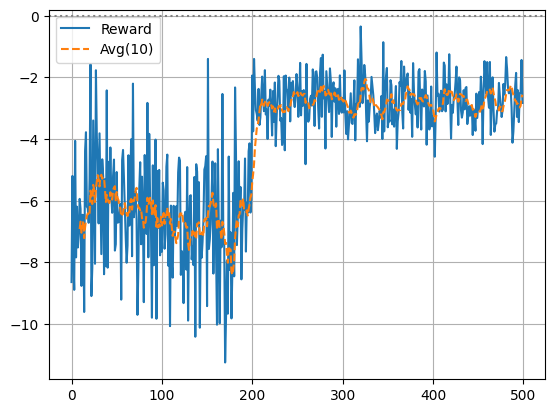

In [ ]:
plt.plot(month_rewards, label='Reward')
plt.plot(pd.Series(month_rewards).rolling(10).mean(), '--', label='Avg(10)')
plt.axhline(0, color='grey', ls=':')
plt.legend(); plt.grid(True); plt.show()

This worked exceptionally better - the peak at phase 2 causing the reward to range from -2.5 to -1.8

# Why did it improve in Phase 2??
- startinf with a short term training (0-199 episodes) allows for a faster feedback loop so the agent quickly learn cause effect relationships between actions and profits abd there is low variance due to shorter periods -> builds a foundation of safe more forging enviornment
- Then phase 2 - is a longe term strategy - 60-step episodes force the agent to consider delayed rewards and smoother decision making and sharpe liek scaling with stricter base line to meet
- It teaches the agent to remain profitable and stable over larger horizons (essential for realworld trading)
- KL penalty annealing ensures that early on the agent stays close to the safe reference policy (uniform), promoting exploration. and over time it decreases (see formula used) - > more confident behavior

My assumption is that :
1. radually increasing time horizon + performance target accelerates learning — which is a valid and effective strategy in reinforcement learning. - Phase change
2. The assumption is that the agent first learns short-term tactical decisions, then scales up to longer-term strategic planning.

3. This reduces early noise, helps the G-values stabilize, and avoids overwhelming the agent with long-horizon uncertainty from the start

# Trying to enchance the circular training
-  where the training gradually progresses through increasingly difficult phases
- This time instead of 2, I made it 4 phase (my assumption was phase change causes a spike)
- I also opted or a gradual window change increase 21 > 45 > 60 -> 90 compared to previous 21->60 and similar baseline targets
- I also applied sharpe scaling to all phases except the first and KL penalty anealing

In [ ]:

episodes  = 1000
kl_beta   = 0.01
use_sharpe_scaling = True

curriculum = [
    dict(end_ep=199,  month_len=21, baseline=0.98, sigma_cap=0.20),
    dict(end_ep=499,  month_len=45, baseline=1.02, sigma_cap=0.25),
    dict(end_ep=799,  month_len=60, baseline=1.05, sigma_cap=0.30),
    dict(end_ep=999,  month_len=90, baseline=1.10, sigma_cap=0.40),
]

equity_curves, month_rewards = [], []
pbar = tqdm(range(episodes), desc="Training G‑Learning")

for ep in pbar:
    for phase in curriculum:
        if ep <= phase["end_ep"]:
            month_len = phase["month_len"]
            baseline = phase["baseline"]
            sigma_cap = phase["sigma_cap"]
            break

    anneal_factor = 1 - ep / episodes

    obs, _ = env_raw.reset()
    equity = [env_raw.unwrapped._total_profit]

    for t in range(month_len):
        s = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s)
        a = np.random.choice(ACTIONS, p=pi)

        obs, _, terminated, truncated, _ = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g = softmax_g(s_next) @ G[s_next]
        reg = kl_div(pi, pi_ref)

        end_of_window = (t == month_len - 1)
        episode_end = terminated or truncated

        if end_of_window or episode_end:
            profit = env_raw.unwrapped._total_profit
            log_return = np.log(max(profit, 1e-6) / baseline)

            if len(equity) > 2:
                raw_sigma = np.std(np.diff(equity[-month_len:])) + 1e-6
            else:
                raw_sigma = 1.0

            sigma = min(raw_sigma, sigma_cap) + 1e-6
            if use_sharpe_scaling and month_len > 21:
                sigma *= np.sqrt(month_len)

            reward = log_return / sigma - kl_beta * anneal_factor * reg
            G[s][a] = (1 - alpha) * G[s][a] + alpha * (reward + gamma * Ea_g)
            month_rewards.append(reward)

        if episode_end:
            break

    equity_curves.append(equity)

    last_r = month_rewards[-1]
    pbar.set_description(f"Ep {ep+1} | R: {last_r:.4f}")
    if len(month_rewards) >= 10:
        avg10 = np.mean(month_rewards[-10:])
        print(f"Episode {ep+1:>4} | Reward {last_r:7.4f} | Avg(10) {avg10:7.4f}")


Ep 13 | R: -8.1134:   1%|          | 12/1000 [00:00<01:06, 14.96it/s]

Episode   10 | Reward -4.6218 | Avg(10) -6.6439
Episode   11 | Reward -6.8720 | Avg(10) -6.7137
Episode   12 | Reward -3.2922 | Avg(10) -6.1827
Episode   13 | Reward -8.1134 | Avg(10) -6.1355


Ep 16 | R: -2.2673:   2%|▏         | 16/1000 [00:01<01:03, 15.57it/s]

Episode   14 | Reward -4.2884 | Avg(10) -5.5886
Episode   15 | Reward -7.2852 | Avg(10) -5.6434
Episode   16 | Reward -2.2673 | Avg(10) -5.5123


Ep 19 | R: -6.8382:   2%|▏         | 18/1000 [00:01<01:07, 14.51it/s]

Episode   17 | Reward -9.8347 | Avg(10) -5.6955
Episode   18 | Reward -6.3540 | Avg(10) -6.0292
Episode   19 | Reward -6.8382 | Avg(10) -5.9767


Ep 22 | R: -4.2463:   2%|▏         | 22/1000 [00:01<01:07, 14.39it/s]

Episode   20 | Reward -8.4476 | Avg(10) -6.3593
Episode   21 | Reward -6.1757 | Avg(10) -6.2896
Episode   22 | Reward -4.2463 | Avg(10) -6.3851


Ep 26 | R: -6.4281:   2%|▏         | 24/1000 [00:01<01:07, 14.38it/s]

Episode   23 | Reward -5.0794 | Avg(10) -6.0817
Episode   24 | Reward -6.3897 | Avg(10) -6.2918
Episode   25 | Reward -9.6264 | Avg(10) -6.5259


Ep 28 | R: -6.3985:   3%|▎         | 28/1000 [00:01<01:07, 14.46it/s]

Episode   26 | Reward -6.4281 | Avg(10) -6.9420
Episode   27 | Reward -4.3732 | Avg(10) -6.3958
Episode   28 | Reward -6.3985 | Avg(10) -6.4003


Ep 31 | R: -8.0761:   3%|▎         | 30/1000 [00:02<01:07, 14.47it/s]

Episode   29 | Reward -5.4930 | Avg(10) -6.2658
Episode   30 | Reward -6.7662 | Avg(10) -6.0976
Episode   31 | Reward -8.0761 | Avg(10) -6.2877


Ep 34 | R: -6.5047:   3%|▎         | 34/1000 [00:02<01:10, 13.70it/s]

Episode   32 | Reward -3.2790 | Avg(10) -6.1910
Episode   33 | Reward -8.5116 | Avg(10) -6.5342
Episode   34 | Reward -6.5047 | Avg(10) -6.5457


Ep 37 | R: -5.8923:   4%|▎         | 36/1000 [00:02<01:10, 13.66it/s]

Episode   35 | Reward -6.8406 | Avg(10) -6.2671
Episode   36 | Reward -5.1069 | Avg(10) -6.1350
Episode   37 | Reward -5.8923 | Avg(10) -6.2869


Ep 40 | R: -7.0123:   4%|▍         | 40/1000 [00:02<01:12, 13.27it/s]

Episode   38 | Reward -5.7000 | Avg(10) -6.2170
Episode   39 | Reward -6.8827 | Avg(10) -6.3560
Episode   40 | Reward -7.0123 | Avg(10) -6.3806


Ep 43 | R: -4.4284:   4%|▍         | 42/1000 [00:02<01:13, 13.02it/s]

Episode   41 | Reward -7.0437 | Avg(10) -6.2774
Episode   42 | Reward -6.0229 | Avg(10) -6.5518
Episode   43 | Reward -4.4284 | Avg(10) -6.1434


Ep 46 | R: -9.7951:   5%|▍         | 46/1000 [00:03<01:13, 12.92it/s]

Episode   44 | Reward -5.3959 | Avg(10) -6.0326
Episode   45 | Reward -5.8050 | Avg(10) -5.9290
Episode   46 | Reward -9.7951 | Avg(10) -6.3978


Ep 49 | R: -7.0213:   5%|▍         | 48/1000 [00:03<01:18, 12.15it/s]

Episode   47 | Reward -7.5863 | Avg(10) -6.5672
Episode   48 | Reward -6.9209 | Avg(10) -6.6893
Episode   49 | Reward -7.0213 | Avg(10) -6.7032


Ep 53 | R: -9.0598:   5%|▌         | 52/1000 [00:03<01:18, 12.13it/s]

Episode   50 | Reward -4.2710 | Avg(10) -6.4290
Episode   51 | Reward -9.4338 | Avg(10) -6.6681
Episode   52 | Reward -4.5347 | Avg(10) -6.5192
Episode   53 | Reward -9.0598 | Avg(10) -6.9824


Ep 57 | R: -8.2144:   6%|▌         | 56/1000 [00:04<01:04, 14.60it/s]

Episode   54 | Reward -6.1977 | Avg(10) -7.0626
Episode   55 | Reward -5.3764 | Avg(10) -7.0197
Episode   56 | Reward -6.8881 | Avg(10) -6.7290
Episode   57 | Reward -8.2144 | Avg(10) -6.7918


Ep 61 | R: -6.3441:   6%|▌         | 60/1000 [00:04<00:57, 16.41it/s]

Episode   58 | Reward -6.9068 | Avg(10) -6.7904
Episode   59 | Reward -4.4757 | Avg(10) -6.5358
Episode   60 | Reward -9.9908 | Avg(10) -7.1078
Episode   61 | Reward -6.3441 | Avg(10) -6.7989


Ep 64 | R: -8.5348:   6%|▋         | 64/1000 [00:04<00:56, 16.60it/s]

Episode   62 | Reward -7.4467 | Avg(10) -7.0901
Episode   63 | Reward -6.3936 | Avg(10) -6.8234
Episode   64 | Reward -8.5348 | Avg(10) -7.0571


Ep 68 | R: -4.4534:   7%|▋         | 68/1000 [00:04<01:01, 15.25it/s]

Episode   65 | Reward -7.1532 | Avg(10) -7.2348
Episode   66 | Reward -3.3224 | Avg(10) -6.8783
Episode   67 | Reward -6.6845 | Avg(10) -6.7253
Episode   68 | Reward -4.4534 | Avg(10) -6.4799


Ep 72 | R: -4.0708:   7%|▋         | 72/1000 [00:04<00:56, 16.51it/s]

Episode   69 | Reward -7.7289 | Avg(10) -6.8052
Episode   70 | Reward -7.0334 | Avg(10) -6.5095
Episode   71 | Reward -6.1060 | Avg(10) -6.4857
Episode   72 | Reward -4.0708 | Avg(10) -6.1481


Ep 76 | R: -6.3113:   8%|▊         | 76/1000 [00:05<00:53, 17.21it/s]

Episode   73 | Reward -8.0081 | Avg(10) -6.3095
Episode   74 | Reward -4.8353 | Avg(10) -5.9396
Episode   75 | Reward -8.4264 | Avg(10) -6.0669
Episode   76 | Reward -6.3113 | Avg(10) -6.3658


Ep 80 | R: -6.0801:   8%|▊         | 80/1000 [00:05<00:55, 16.64it/s]

Episode   77 | Reward -7.4396 | Avg(10) -6.4413
Episode   78 | Reward -8.1823 | Avg(10) -6.8142
Episode   79 | Reward -7.5603 | Avg(10) -6.7974
Episode   80 | Reward -6.0801 | Avg(10) -6.7020


Ep 84 | R: -8.0776:   8%|▊         | 84/1000 [00:05<01:00, 15.25it/s]

Episode   81 | Reward -9.5389 | Avg(10) -7.0453
Episode   82 | Reward -2.5124 | Avg(10) -6.8895
Episode   83 | Reward -7.6943 | Avg(10) -6.8581
Episode   84 | Reward -8.0776 | Avg(10) -7.1823


Ep 88 | R: -5.6752:   9%|▉         | 88/1000 [00:05<00:55, 16.50it/s]

Episode   85 | Reward -5.4804 | Avg(10) -6.8877
Episode   86 | Reward -4.6922 | Avg(10) -6.7258
Episode   87 | Reward -7.8796 | Avg(10) -6.7698
Episode   88 | Reward -5.6752 | Avg(10) -6.5191


Ep 92 | R: -8.4378:   9%|▉         | 92/1000 [00:06<00:52, 17.45it/s]

Episode   89 | Reward -5.8280 | Avg(10) -6.3459
Episode   90 | Reward -6.1101 | Avg(10) -6.3489
Episode   91 | Reward -8.5985 | Avg(10) -6.2548
Episode   92 | Reward -8.4378 | Avg(10) -6.8474


Ep 96 | R: -9.3052:  10%|▉         | 96/1000 [00:06<00:53, 17.00it/s]

Episode   93 | Reward -8.2614 | Avg(10) -6.9041
Episode   94 | Reward -8.2360 | Avg(10) -6.9199
Episode   95 | Reward -5.4245 | Avg(10) -6.9143
Episode   96 | Reward -9.3052 | Avg(10) -7.3756


Ep 100 | R: -8.0464:  10%|█         | 100/1000 [00:06<00:59, 15.11it/s]

Episode   97 | Reward -10.0903 | Avg(10) -7.5967
Episode   98 | Reward -6.0742 | Avg(10) -7.6366
Episode   99 | Reward -8.6455 | Avg(10) -7.9183
Episode  100 | Reward -8.0464 | Avg(10) -8.1120


Ep 104 | R: -9.7875:  10%|█         | 104/1000 [00:06<00:55, 16.07it/s]

Episode  101 | Reward -6.8884 | Avg(10) -7.9410
Episode  102 | Reward -8.0766 | Avg(10) -7.9048
Episode  103 | Reward -8.0598 | Avg(10) -7.8847
Episode  104 | Reward -9.7875 | Avg(10) -8.0398


Ep 108 | R: 2.1097:  11%|█         | 108/1000 [00:07<00:52, 16.86it/s]

Episode  105 | Reward -8.6272 | Avg(10) -8.3601
Episode  106 | Reward -7.7255 | Avg(10) -8.2021
Episode  107 | Reward -5.8012 | Avg(10) -7.7732
Episode  108 | Reward  2.1097 | Avg(10) -6.9548


Ep 112 | R: -7.8240:  11%|█         | 112/1000 [00:07<00:52, 16.89it/s]

Episode  109 | Reward -8.3027 | Avg(10) -6.9206
Episode  110 | Reward -8.1630 | Avg(10) -6.9322
Episode  111 | Reward -7.8039 | Avg(10) -7.0238
Episode  112 | Reward -7.8240 | Avg(10) -6.9985


Ep 115 | R: -5.5302:  11%|█▏        | 114/1000 [00:07<01:03, 13.95it/s]

Episode  113 | Reward -3.6160 | Avg(10) -6.5541
Episode  114 | Reward -6.1280 | Avg(10) -6.1882
Episode  115 | Reward -5.5302 | Avg(10) -5.8785


Ep 119 | R: -6.7415:  12%|█▏        | 118/1000 [00:07<00:56, 15.51it/s]

Episode  116 | Reward -6.2158 | Avg(10) -5.7275
Episode  117 | Reward -4.4446 | Avg(10) -5.5919
Episode  118 | Reward -3.4761 | Avg(10) -6.1504
Episode  119 | Reward -6.7415 | Avg(10) -5.9943


Ep 123 | R: -8.2392:  12%|█▏        | 122/1000 [00:08<00:52, 16.73it/s]

Episode  120 | Reward -8.5784 | Avg(10) -6.0358
Episode  121 | Reward -7.5622 | Avg(10) -6.0117
Episode  122 | Reward -8.2372 | Avg(10) -6.0530
Episode  123 | Reward -8.2392 | Avg(10) -6.5153


Ep 127 | R: -6.7686:  13%|█▎        | 126/1000 [00:08<00:49, 17.48it/s]

Episode  124 | Reward -8.0538 | Avg(10) -6.7079
Episode  125 | Reward -6.5353 | Avg(10) -6.8084
Episode  126 | Reward -9.7675 | Avg(10) -7.1636
Episode  127 | Reward -6.7686 | Avg(10) -7.3960


Ep 130 | R: -8.2837:  13%|█▎        | 130/1000 [00:08<01:00, 14.37it/s]

Episode  128 | Reward -4.0932 | Avg(10) -7.4577
Episode  129 | Reward -7.4592 | Avg(10) -7.5295
Episode  130 | Reward -8.2837 | Avg(10) -7.5000


Ep 134 | R: -6.4810:  13%|█▎        | 134/1000 [00:08<00:53, 16.08it/s]

Episode  131 | Reward -8.2697 | Avg(10) -7.5708
Episode  132 | Reward -7.0678 | Avg(10) -7.4538
Episode  133 | Reward -2.4377 | Avg(10) -6.8737
Episode  134 | Reward -6.4810 | Avg(10) -6.7164


Ep 138 | R: -7.3430:  14%|█▍        | 138/1000 [00:09<00:49, 17.24it/s]

Episode  135 | Reward -8.0497 | Avg(10) -6.8678
Episode  136 | Reward -6.8133 | Avg(10) -6.5724
Episode  137 | Reward -7.3229 | Avg(10) -6.6278
Episode  138 | Reward -7.3430 | Avg(10) -6.9528


Ep 142 | R: -3.3024:  14%|█▍        | 142/1000 [00:09<00:48, 17.81it/s]

Episode  139 | Reward -6.2227 | Avg(10) -6.8291
Episode  140 | Reward -6.2391 | Avg(10) -6.6247
Episode  141 | Reward -7.1320 | Avg(10) -6.5109
Episode  142 | Reward -3.3024 | Avg(10) -6.1344


Ep 145 | R: -6.9559:  14%|█▍        | 144/1000 [00:09<00:48, 17.53it/s]

Episode  143 | Reward -4.9900 | Avg(10) -6.3896
Episode  144 | Reward -6.9493 | Avg(10) -6.4364
Episode  145 | Reward -6.9559 | Avg(10) -6.3271


Ep 149 | R: -4.6458:  15%|█▍        | 148/1000 [00:09<00:56, 15.19it/s]

Episode  146 | Reward -5.5248 | Avg(10) -6.1982
Episode  147 | Reward -6.3056 | Avg(10) -6.0965
Episode  148 | Reward -8.2036 | Avg(10) -6.1825
Episode  149 | Reward -4.6458 | Avg(10) -6.0248


Ep 153 | R: -4.0370:  15%|█▌        | 152/1000 [00:09<00:51, 16.39it/s]

Episode  150 | Reward -7.8791 | Avg(10) -6.1888
Episode  151 | Reward -7.9678 | Avg(10) -6.2724
Episode  152 | Reward -9.4632 | Avg(10) -6.8885
Episode  153 | Reward -4.0370 | Avg(10) -6.7932


Ep 157 | R: -4.6602:  16%|█▌        | 156/1000 [00:10<00:49, 16.99it/s]

Episode  154 | Reward -7.8742 | Avg(10) -6.8857
Episode  155 | Reward -6.7455 | Avg(10) -6.8647
Episode  156 | Reward -8.4182 | Avg(10) -7.1540
Episode  157 | Reward -4.6602 | Avg(10) -6.9895


Ep 160 | R: -5.8632:  16%|█▌        | 160/1000 [00:10<00:48, 17.29it/s]

Episode  158 | Reward -6.4578 | Avg(10) -6.8149
Episode  159 | Reward -5.4258 | Avg(10) -6.8929
Episode  160 | Reward -5.8632 | Avg(10) -6.6913


Ep 164 | R: -7.8323:  16%|█▋        | 164/1000 [00:10<00:55, 15.13it/s]

Episode  161 | Reward -6.2418 | Avg(10) -6.5187
Episode  162 | Reward -6.9798 | Avg(10) -6.2704
Episode  163 | Reward -4.2022 | Avg(10) -6.2869
Episode  164 | Reward -7.8323 | Avg(10) -6.2827


Ep 168 | R: -5.9725:  17%|█▋        | 168/1000 [00:10<00:51, 16.26it/s]

Episode  165 | Reward -6.6925 | Avg(10) -6.2774
Episode  166 | Reward -7.2468 | Avg(10) -6.1602
Episode  167 | Reward -5.8597 | Avg(10) -6.2802
Episode  168 | Reward -5.9725 | Avg(10) -6.2317


Ep 172 | R: -6.7251:  17%|█▋        | 172/1000 [00:11<00:47, 17.31it/s]

Episode  169 | Reward -7.7388 | Avg(10) -6.4630
Episode  170 | Reward -5.6201 | Avg(10) -6.4387
Episode  171 | Reward -8.4755 | Avg(10) -6.6620
Episode  172 | Reward -6.7251 | Avg(10) -6.6366


Ep 176 | R: -5.5786:  18%|█▊        | 176/1000 [00:11<00:46, 17.84it/s]

Episode  173 | Reward -4.1729 | Avg(10) -6.6336
Episode  174 | Reward -8.2049 | Avg(10) -6.6709
Episode  175 | Reward -8.2408 | Avg(10) -6.8257
Episode  176 | Reward -5.5786 | Avg(10) -6.6589


Ep 179 | R: -7.0295:  18%|█▊        | 178/1000 [00:11<00:54, 15.12it/s]

Episode  177 | Reward -6.0735 | Avg(10) -6.6803
Episode  178 | Reward -9.6025 | Avg(10) -7.0433
Episode  179 | Reward -7.0295 | Avg(10) -6.9723


Ep 183 | R: -9.3591:  18%|█▊        | 182/1000 [00:11<00:51, 15.87it/s]

Episode  180 | Reward -7.7785 | Avg(10) -7.1882
Episode  181 | Reward -5.0717 | Avg(10) -6.8478
Episode  182 | Reward -5.8054 | Avg(10) -6.7558
Episode  183 | Reward -9.3591 | Avg(10) -7.2744


Ep 187 | R: -8.0703:  19%|█▊        | 186/1000 [00:12<00:47, 17.00it/s]

Episode  184 | Reward -3.9096 | Avg(10) -6.8449
Episode  185 | Reward -5.5093 | Avg(10) -6.5718
Episode  186 | Reward -6.8908 | Avg(10) -6.7030
Episode  187 | Reward -8.0703 | Avg(10) -6.9027


Ep 191 | R: -5.7600:  19%|█▉        | 190/1000 [00:12<00:45, 17.71it/s]

Episode  188 | Reward -6.7509 | Avg(10) -6.6175
Episode  189 | Reward -4.9579 | Avg(10) -6.4104
Episode  190 | Reward -6.2902 | Avg(10) -6.2615
Episode  191 | Reward -5.7600 | Avg(10) -6.3304


Ep 194 | R: -9.5844:  19%|█▉        | 194/1000 [00:12<00:54, 14.83it/s]

Episode  192 | Reward -4.0360 | Avg(10) -6.1534
Episode  193 | Reward -9.2106 | Avg(10) -6.1386
Episode  194 | Reward -9.5844 | Avg(10) -6.7060


Ep 198 | R: -8.2010:  20%|█▉        | 198/1000 [00:12<00:50, 15.85it/s]

Episode  195 | Reward -4.2989 | Avg(10) -6.5850
Episode  196 | Reward -6.9584 | Avg(10) -6.5917
Episode  197 | Reward -6.6378 | Avg(10) -6.4485
Episode  198 | Reward -8.2010 | Avg(10) -6.5935


Ep 201 | R: -2.3233:  20%|██        | 200/1000 [00:12<00:48, 16.48it/s]

Episode  199 | Reward -10.1895 | Avg(10) -7.1167
Episode  200 | Reward -8.5082 | Avg(10) -7.3385
Episode  201 | Reward -2.3233 | Avg(10) -6.9948


Ep 203 | R: -3.1143:  20%|██        | 202/1000 [00:13<01:00, 13.13it/s]

Episode  202 | Reward -2.2022 | Avg(10) -6.8114
Episode  203 | Reward -3.1143 | Avg(10) -6.2018


Ep 205 | R: -1.4461:  20%|██        | 204/1000 [00:13<01:08, 11.58it/s]

Episode  204 | Reward -2.8290 | Avg(10) -5.5263
Episode  205 | Reward -1.4461 | Avg(10) -5.2410


Ep 207 | R: -1.3361:  21%|██        | 206/1000 [00:13<01:24,  9.39it/s]

Episode  206 | Reward -3.5178 | Avg(10) -4.8969
Episode  207 | Reward -1.3361 | Avg(10) -4.3667


Ep 209 | R: -3.1723:  21%|██        | 209/1000 [00:14<01:44,  7.59it/s]

Episode  208 | Reward -2.8251 | Avg(10) -3.8292
Episode  209 | Reward -3.1723 | Avg(10) -3.1274


Ep 210 | R: -2.9395:  21%|██        | 210/1000 [00:14<01:46,  7.40it/s]

Episode  210 | Reward -2.9395 | Avg(10) -2.5706


Ep 212 | R: -2.5412:  21%|██        | 212/1000 [00:14<02:09,  6.09it/s]

Episode  211 | Reward -1.4028 | Avg(10) -2.4785
Episode  212 | Reward -2.5412 | Avg(10) -2.5124


Ep 214 | R: -3.6204:  21%|██▏       | 214/1000 [00:15<02:08,  6.10it/s]

Episode  213 | Reward -2.1926 | Avg(10) -2.4202
Episode  214 | Reward -3.6204 | Avg(10) -2.4994


Ep 216 | R: -2.0142:  22%|██▏       | 216/1000 [00:15<02:04,  6.28it/s]

Episode  215 | Reward -2.5462 | Avg(10) -2.6094
Episode  216 | Reward -2.0142 | Avg(10) -2.4590


Ep 218 | R: -1.3157:  22%|██▏       | 218/1000 [00:15<02:22,  5.50it/s]

Episode  217 | Reward -2.6603 | Avg(10) -2.5915
Episode  218 | Reward -1.3157 | Avg(10) -2.4405


Ep 220 | R: -3.6078:  22%|██▏       | 220/1000 [00:16<02:17,  5.67it/s]

Episode  219 | Reward -0.9706 | Avg(10) -2.2203
Episode  220 | Reward -3.6078 | Avg(10) -2.2872


Ep 221 | R: -2.7040:  22%|██▏       | 221/1000 [00:16<02:16,  5.72it/s]

Episode  221 | Reward -2.7040 | Avg(10) -2.4173


Ep 223 | R: -3.6338:  22%|██▏       | 223/1000 [00:16<02:09,  6.00it/s]

Episode  222 | Reward -1.1378 | Avg(10) -2.2770
Episode  223 | Reward -3.6338 | Avg(10) -2.4211


Ep 224 | R: -1.1951:  22%|██▏       | 224/1000 [00:16<01:59,  6.50it/s]

Episode  224 | Reward -1.1951 | Avg(10) -2.1785


Ep 226 | R: -2.3909:  23%|██▎       | 226/1000 [00:17<01:58,  6.52it/s]

Episode  225 | Reward -2.2374 | Avg(10) -2.1477
Episode  226 | Reward -2.3909 | Avg(10) -2.1853


Ep 228 | R: -1.9074:  23%|██▎       | 228/1000 [00:17<01:40,  7.69it/s]

Episode  227 | Reward -2.1297 | Avg(10) -2.1323
Episode  228 | Reward -1.9074 | Avg(10) -2.1914


Ep 230 | R: -2.7715:  23%|██▎       | 230/1000 [00:17<01:30,  8.47it/s]

Episode  229 | Reward -0.8904 | Avg(10) -2.1834
Episode  230 | Reward -2.7715 | Avg(10) -2.0998


Ep 232 | R: -1.3375:  23%|██▎       | 232/1000 [00:17<01:27,  8.74it/s]

Episode  231 | Reward -2.6499 | Avg(10) -2.0944
Episode  232 | Reward -1.3375 | Avg(10) -2.1144


Ep 234 | R: -1.4575:  23%|██▎       | 234/1000 [00:17<01:31,  8.39it/s]

Episode  233 | Reward -2.8930 | Avg(10) -2.0403
Episode  234 | Reward -1.4575 | Avg(10) -2.0665


Ep 236 | R: -3.6835:  24%|██▎       | 236/1000 [00:18<01:29,  8.55it/s]

Episode  235 | Reward -2.9124 | Avg(10) -2.1340
Episode  236 | Reward -3.6835 | Avg(10) -2.2633


Ep 238 | R: -2.4163:  24%|██▍       | 238/1000 [00:18<01:30,  8.45it/s]

Episode  237 | Reward -1.8822 | Avg(10) -2.2385
Episode  238 | Reward -2.4163 | Avg(10) -2.2894


Ep 240 | R: -2.7255:  24%|██▍       | 240/1000 [00:18<01:39,  7.60it/s]

Episode  239 | Reward -2.8550 | Avg(10) -2.4859
Episode  240 | Reward -2.7255 | Avg(10) -2.4813


Ep 242 | R: -3.2370:  24%|██▍       | 242/1000 [00:18<01:32,  8.18it/s]

Episode  241 | Reward -2.3572 | Avg(10) -2.4520
Episode  242 | Reward -3.2370 | Avg(10) -2.6420


Ep 244 | R: -3.1743:  24%|██▍       | 244/1000 [00:19<01:30,  8.35it/s]

Episode  243 | Reward -2.6657 | Avg(10) -2.6192
Episode  244 | Reward -3.1743 | Avg(10) -2.7909


Ep 246 | R: -3.1742:  25%|██▍       | 246/1000 [00:19<01:44,  7.19it/s]

Episode  245 | Reward -2.4723 | Avg(10) -2.7469
Episode  246 | Reward -3.1742 | Avg(10) -2.6960


Ep 248 | R: -2.6725:  25%|██▍       | 248/1000 [00:19<01:35,  7.85it/s]

Episode  247 | Reward -2.2397 | Avg(10) -2.7317
Episode  248 | Reward -2.6725 | Avg(10) -2.7573


Ep 250 | R: -0.8016:  25%|██▌       | 250/1000 [00:19<01:30,  8.27it/s]

Episode  249 | Reward -2.6651 | Avg(10) -2.7383
Episode  250 | Reward -0.8016 | Avg(10) -2.5459


Ep 252 | R: -3.2146:  25%|██▌       | 252/1000 [00:20<01:29,  8.38it/s]

Episode  251 | Reward -2.8832 | Avg(10) -2.5985
Episode  252 | Reward -3.2146 | Avg(10) -2.5963


Ep 254 | R: -1.8091:  25%|██▌       | 254/1000 [00:20<01:27,  8.56it/s]

Episode  253 | Reward -2.7676 | Avg(10) -2.6065
Episode  254 | Reward -1.8091 | Avg(10) -2.4700


Ep 256 | R: -2.4496:  26%|██▌       | 256/1000 [00:20<01:37,  7.62it/s]

Episode  255 | Reward -2.3313 | Avg(10) -2.4559
Episode  256 | Reward -2.4496 | Avg(10) -2.3834


Ep 258 | R: -1.8419:  26%|██▌       | 258/1000 [00:20<01:31,  8.09it/s]

Episode  257 | Reward -2.1610 | Avg(10) -2.3756
Episode  258 | Reward -1.8419 | Avg(10) -2.2925


Ep 260 | R: -3.3827:  26%|██▌       | 260/1000 [00:21<01:28,  8.33it/s]

Episode  259 | Reward -2.7114 | Avg(10) -2.2971
Episode  260 | Reward -3.3827 | Avg(10) -2.5552


Ep 262 | R: -2.2348:  26%|██▌       | 262/1000 [00:21<01:44,  7.06it/s]

Episode  261 | Reward -2.2155 | Avg(10) -2.4885
Episode  262 | Reward -2.2348 | Avg(10) -2.3905


Ep 264 | R: -1.4493:  26%|██▋       | 264/1000 [00:21<01:35,  7.75it/s]

Episode  263 | Reward -2.7562 | Avg(10) -2.3893
Episode  264 | Reward -1.4493 | Avg(10) -2.3534


Ep 266 | R: -1.1072:  27%|██▋       | 266/1000 [00:21<01:29,  8.23it/s]

Episode  265 | Reward -2.0913 | Avg(10) -2.3294
Episode  266 | Reward -1.1072 | Avg(10) -2.1951


Ep 268 | R: -3.7195:  27%|██▋       | 268/1000 [00:22<01:27,  8.40it/s]

Episode  267 | Reward -3.6218 | Avg(10) -2.3412
Episode  268 | Reward -3.7195 | Avg(10) -2.5290


Ep 270 | R: -3.2876:  27%|██▋       | 270/1000 [00:22<01:39,  7.34it/s]

Episode  269 | Reward -2.6142 | Avg(10) -2.5192
Episode  270 | Reward -3.2876 | Avg(10) -2.5097


Ep 272 | R: -2.3484:  27%|██▋       | 272/1000 [00:22<01:31,  7.92it/s]

Episode  271 | Reward -3.1243 | Avg(10) -2.6006
Episode  272 | Reward -2.3484 | Avg(10) -2.6120


Ep 274 | R: -2.5351:  27%|██▋       | 274/1000 [00:22<01:27,  8.26it/s]

Episode  273 | Reward -2.7333 | Avg(10) -2.6097
Episode  274 | Reward -2.5351 | Avg(10) -2.7183


Ep 276 | R: -2.1749:  28%|██▊       | 276/1000 [00:23<01:26,  8.37it/s]

Episode  275 | Reward -3.0354 | Avg(10) -2.8127
Episode  276 | Reward -2.1749 | Avg(10) -2.9195


Ep 278 | R: -2.9488:  28%|██▊       | 278/1000 [00:23<01:39,  7.27it/s]

Episode  277 | Reward -2.4389 | Avg(10) -2.8012
Episode  278 | Reward -2.9488 | Avg(10) -2.7241


Ep 280 | R: -2.2482:  28%|██▊       | 280/1000 [00:23<01:31,  7.86it/s]

Episode  279 | Reward -3.6308 | Avg(10) -2.8258
Episode  280 | Reward -2.2482 | Avg(10) -2.7218


Ep 282 | R: -3.6353:  28%|██▊       | 282/1000 [00:23<01:26,  8.26it/s]

Episode  281 | Reward -1.3417 | Avg(10) -2.5436
Episode  282 | Reward -3.6353 | Avg(10) -2.6723


Ep 284 | R: -1.2233:  28%|██▊       | 284/1000 [00:24<01:27,  8.20it/s]

Episode  283 | Reward -3.1300 | Avg(10) -2.7119
Episode  284 | Reward -1.2233 | Avg(10) -2.5807


Ep 286 | R: -2.3558:  29%|██▊       | 286/1000 [00:24<01:25,  8.37it/s]

Episode  285 | Reward -1.4898 | Avg(10) -2.4262
Episode  286 | Reward -2.3558 | Avg(10) -2.4443


Ep 288 | R: -2.6617:  29%|██▉       | 288/1000 [00:24<01:33,  7.63it/s]

Episode  287 | Reward -2.8402 | Avg(10) -2.4844
Episode  288 | Reward -2.6617 | Avg(10) -2.4557


Ep 290 | R: -3.4907:  29%|██▉       | 290/1000 [00:24<01:28,  8.06it/s]

Episode  289 | Reward -3.2710 | Avg(10) -2.4197
Episode  290 | Reward -3.4907 | Avg(10) -2.5440


Ep 292 | R: -2.3287:  29%|██▉       | 292/1000 [00:25<01:24,  8.41it/s]

Episode  291 | Reward -2.6364 | Avg(10) -2.6734
Episode  292 | Reward -2.3287 | Avg(10) -2.5428


Ep 294 | R: -2.8588:  29%|██▉       | 294/1000 [00:25<01:23,  8.48it/s]

Episode  293 | Reward -2.6560 | Avg(10) -2.4954
Episode  294 | Reward -2.8588 | Avg(10) -2.6589


Ep 296 | R: -2.6592:  30%|██▉       | 296/1000 [00:25<01:32,  7.61it/s]

Episode  295 | Reward -1.7209 | Avg(10) -2.6820
Episode  296 | Reward -2.6592 | Avg(10) -2.7124


Ep 298 | R: -2.1241:  30%|██▉       | 298/1000 [00:25<01:26,  8.09it/s]

Episode  297 | Reward -3.5602 | Avg(10) -2.7844
Episode  298 | Reward -2.1241 | Avg(10) -2.7306


Ep 300 | R: -2.9762:  30%|███       | 300/1000 [00:26<01:21,  8.54it/s]

Episode  299 | Reward -3.1124 | Avg(10) -2.7148
Episode  300 | Reward -2.9762 | Avg(10) -2.6633


Ep 301 | R: -2.6380:  30%|███       | 301/1000 [00:26<01:24,  8.29it/s]

Episode  301 | Reward -2.6380 | Avg(10) -2.6635


Ep 302 | R: -3.8929:  30%|███       | 302/1000 [00:26<01:48,  6.46it/s]

Episode  302 | Reward -3.8929 | Avg(10) -2.8199


Ep 304 | R: -3.2774:  30%|███       | 304/1000 [00:26<01:54,  6.07it/s]

Episode  303 | Reward -2.3006 | Avg(10) -2.7843
Episode  304 | Reward -3.2774 | Avg(10) -2.8262


Ep 306 | R: -2.6895:  31%|███       | 306/1000 [00:27<01:50,  6.28it/s]

Episode  305 | Reward -2.0339 | Avg(10) -2.8575
Episode  306 | Reward -2.6895 | Avg(10) -2.8605


Ep 307 | R: -2.2201:  31%|███       | 307/1000 [00:27<01:52,  6.19it/s]

Episode  307 | Reward -2.2201 | Avg(10) -2.7265


Ep 309 | R: -1.4099:  31%|███       | 309/1000 [00:27<02:01,  5.68it/s]

Episode  308 | Reward -3.9498 | Avg(10) -2.9091
Episode  309 | Reward -1.4099 | Avg(10) -2.7388


Ep 311 | R: -2.3860:  31%|███       | 311/1000 [00:28<01:50,  6.25it/s]

Episode  310 | Reward -2.5690 | Avg(10) -2.6981
Episode  311 | Reward -2.3860 | Avg(10) -2.6729


Ep 312 | R: -2.4636:  31%|███       | 312/1000 [00:28<01:48,  6.37it/s]

Episode  312 | Reward -2.4636 | Avg(10) -2.5300


Ep 313 | R: -1.4904:  31%|███▏      | 313/1000 [00:28<02:04,  5.52it/s]

Episode  313 | Reward -1.4904 | Avg(10) -2.4490


Ep 315 | R: -3.4213:  32%|███▏      | 315/1000 [00:28<02:07,  5.37it/s]

Episode  314 | Reward -2.1930 | Avg(10) -2.3405
Episode  315 | Reward -3.4213 | Avg(10) -2.4793


Ep 317 | R: -3.5729:  32%|███▏      | 317/1000 [00:29<01:59,  5.73it/s]

Episode  316 | Reward -3.1081 | Avg(10) -2.5211
Episode  317 | Reward -3.5729 | Avg(10) -2.6564


Ep 319 | R: -1.8258:  32%|███▏      | 319/1000 [00:29<01:40,  6.75it/s]

Episode  318 | Reward -2.5357 | Avg(10) -2.5150
Episode  319 | Reward -1.8258 | Avg(10) -2.5566


Ep 321 | R: -1.6130:  32%|███▏      | 321/1000 [00:29<01:41,  6.69it/s]

Episode  320 | Reward -1.7552 | Avg(10) -2.4752
Episode  321 | Reward -1.6130 | Avg(10) -2.3979


Ep 323 | R: -1.7072:  32%|███▏      | 323/1000 [00:30<01:32,  7.35it/s]

Episode  322 | Reward -3.0647 | Avg(10) -2.4580
Episode  323 | Reward -1.7072 | Avg(10) -2.4797


Ep 325 | R: -2.1607:  32%|███▎      | 325/1000 [00:30<01:25,  7.91it/s]

Episode  324 | Reward -1.2902 | Avg(10) -2.3894
Episode  325 | Reward -2.1607 | Avg(10) -2.2633


Ep 326 | R: -1.9747:  33%|███▎      | 326/1000 [00:30<01:24,  7.99it/s]

Episode  326 | Reward -1.9747 | Avg(10) -2.1500


Ep 328 | R: -1.5749:  33%|███▎      | 328/1000 [00:30<01:34,  7.11it/s]

Episode  327 | Reward -1.9221 | Avg(10) -1.9849
Episode  328 | Reward -1.5749 | Avg(10) -1.8889


Ep 330 | R: -2.3039:  33%|███▎      | 330/1000 [00:30<01:25,  7.85it/s]

Episode  329 | Reward -1.5214 | Avg(10) -1.8584
Episode  330 | Reward -2.3039 | Avg(10) -1.9133


Ep 332 | R: -2.8424:  33%|███▎      | 332/1000 [00:31<01:20,  8.31it/s]

Episode  331 | Reward -2.6663 | Avg(10) -2.0186
Episode  332 | Reward -2.8424 | Avg(10) -1.9964


Ep 334 | R: -2.3452:  33%|███▎      | 334/1000 [00:31<01:18,  8.46it/s]

Episode  333 | Reward -1.2601 | Avg(10) -1.9517
Episode  334 | Reward -2.3452 | Avg(10) -2.0572


Ep 336 | R: -2.9265:  34%|███▎      | 336/1000 [00:31<01:33,  7.11it/s]

Episode  335 | Reward -3.8493 | Avg(10) -2.2260
Episode  336 | Reward -2.9265 | Avg(10) -2.3212


Ep 338 | R: -1.3624:  34%|███▍      | 338/1000 [00:31<01:24,  7.88it/s]

Episode  337 | Reward -2.1683 | Avg(10) -2.3458
Episode  338 | Reward -1.3624 | Avg(10) -2.3246


Ep 340 | R: -1.9795:  34%|███▍      | 340/1000 [00:32<01:18,  8.42it/s]

Episode  339 | Reward -2.8337 | Avg(10) -2.4558
Episode  340 | Reward -1.9795 | Avg(10) -2.4234


Ep 342 | R: -2.3191:  34%|███▍      | 342/1000 [00:32<01:18,  8.35it/s]

Episode  341 | Reward -2.9944 | Avg(10) -2.4562
Episode  342 | Reward -2.3191 | Avg(10) -2.4039


Ep 344 | R: -2.8898:  34%|███▍      | 344/1000 [00:32<01:30,  7.27it/s]

Episode  343 | Reward -1.6427 | Avg(10) -2.4421
Episode  344 | Reward -2.8898 | Avg(10) -2.4966


Ep 346 | R: -2.2616:  35%|███▍      | 346/1000 [00:33<01:32,  7.09it/s]

Episode  345 | Reward -2.5328 | Avg(10) -2.3649
Episode  346 | Reward -2.2616 | Avg(10) -2.2984


Ep 348 | R: -2.5313:  35%|███▍      | 348/1000 [00:33<01:23,  7.81it/s]

Episode  347 | Reward -2.0220 | Avg(10) -2.2838
Episode  348 | Reward -2.5313 | Avg(10) -2.4007


Ep 350 | R: -1.2933:  35%|███▌      | 350/1000 [00:33<01:21,  7.99it/s]

Episode  349 | Reward -2.3256 | Avg(10) -2.3499
Episode  350 | Reward -1.2933 | Avg(10) -2.2813


Ep 352 | R: -1.5206:  35%|███▌      | 352/1000 [00:33<01:20,  8.06it/s]

Episode  351 | Reward -2.7905 | Avg(10) -2.2609
Episode  352 | Reward -1.5206 | Avg(10) -2.1810


Ep 354 | R: -2.2186:  35%|███▌      | 354/1000 [00:33<01:17,  8.31it/s]

Episode  353 | Reward -2.2777 | Avg(10) -2.2445
Episode  354 | Reward -2.2186 | Avg(10) -2.1774


Ep 356 | R: -2.3898:  36%|███▌      | 356/1000 [00:34<01:14,  8.60it/s]

Episode  355 | Reward -3.5942 | Avg(10) -2.2835
Episode  356 | Reward -2.3898 | Avg(10) -2.2964


Ep 358 | R: -3.4634:  36%|███▌      | 358/1000 [00:34<01:14,  8.60it/s]

Episode  357 | Reward -3.1309 | Avg(10) -2.4072
Episode  358 | Reward -3.4634 | Avg(10) -2.5005


Ep 360 | R: -2.0701:  36%|███▌      | 360/1000 [00:34<01:26,  7.42it/s]

Episode  359 | Reward -3.3369 | Avg(10) -2.6016
Episode  360 | Reward -2.0701 | Avg(10) -2.6793


Ep 362 | R: -1.6721:  36%|███▌      | 362/1000 [00:34<01:21,  7.85it/s]

Episode  361 | Reward -2.9673 | Avg(10) -2.6969
Episode  362 | Reward -1.6721 | Avg(10) -2.7121


Ep 364 | R: -1.8595:  36%|███▋      | 364/1000 [00:35<01:15,  8.39it/s]

Episode  363 | Reward -2.2285 | Avg(10) -2.7072
Episode  364 | Reward -1.8595 | Avg(10) -2.6713


Ep 366 | R: -0.4770:  37%|███▋      | 366/1000 [00:35<01:15,  8.44it/s]

Episode  365 | Reward -0.8200 | Avg(10) -2.3938
Episode  366 | Reward -0.4770 | Avg(10) -2.2026


Ep 368 | R: -1.9131:  37%|███▋      | 368/1000 [00:35<01:26,  7.31it/s]

Episode  367 | Reward -2.3176 | Avg(10) -2.1212
Episode  368 | Reward -1.9131 | Avg(10) -1.9662


Ep 370 | R: -2.1538:  37%|███▋      | 370/1000 [00:35<01:19,  7.94it/s]

Episode  369 | Reward -3.0217 | Avg(10) -1.9347
Episode  370 | Reward -2.1538 | Avg(10) -1.9430


Ep 372 | R: -2.4028:  37%|███▋      | 372/1000 [00:36<01:14,  8.47it/s]

Episode  371 | Reward -2.5291 | Avg(10) -1.8992
Episode  372 | Reward -2.4028 | Avg(10) -1.9723


Ep 374 | R: -1.4739:  37%|███▋      | 374/1000 [00:36<01:13,  8.57it/s]

Episode  373 | Reward -1.7020 | Avg(10) -1.9197
Episode  374 | Reward -1.4739 | Avg(10) -1.8811


Ep 376 | R: -3.6840:  38%|███▊      | 376/1000 [00:36<01:23,  7.52it/s]

Episode  375 | Reward -1.5706 | Avg(10) -1.9562
Episode  376 | Reward -3.6840 | Avg(10) -2.2769


Ep 378 | R: -2.5405:  38%|███▊      | 378/1000 [00:36<01:16,  8.12it/s]

Episode  377 | Reward -3.4407 | Avg(10) -2.3892
Episode  378 | Reward -2.5405 | Avg(10) -2.4519


Ep 380 | R: -3.4927:  38%|███▊      | 380/1000 [00:37<01:12,  8.53it/s]

Episode  379 | Reward -0.8476 | Avg(10) -2.2345
Episode  380 | Reward -3.4927 | Avg(10) -2.3684


Ep 382 | R: -2.3005:  38%|███▊      | 382/1000 [00:37<01:13,  8.41it/s]

Episode  381 | Reward -3.6099 | Avg(10) -2.4765
Episode  382 | Reward -2.3005 | Avg(10) -2.4662


Ep 384 | R: -2.0486:  38%|███▊      | 384/1000 [00:37<01:21,  7.56it/s]

Episode  383 | Reward -2.4741 | Avg(10) -2.5434
Episode  384 | Reward -2.0486 | Avg(10) -2.6009


Ep 386 | R: -2.0674:  39%|███▊      | 386/1000 [00:37<01:16,  7.99it/s]

Episode  385 | Reward -2.6979 | Avg(10) -2.7136
Episode  386 | Reward -2.0674 | Avg(10) -2.5520


Ep 388 | R: -2.5118:  39%|███▉      | 388/1000 [00:38<01:12,  8.40it/s]

Episode  387 | Reward -0.9286 | Avg(10) -2.3008
Episode  388 | Reward -2.5118 | Avg(10) -2.2979


Ep 390 | R: -2.4254:  39%|███▉      | 390/1000 [00:38<01:25,  7.17it/s]

Episode  389 | Reward -2.7724 | Avg(10) -2.4904
Episode  390 | Reward -2.4254 | Avg(10) -2.3837


Ep 392 | R: -2.2293:  39%|███▉      | 392/1000 [00:38<01:17,  7.85it/s]

Episode  391 | Reward -2.4559 | Avg(10) -2.2683
Episode  392 | Reward -2.2293 | Avg(10) -2.2611


Ep 394 | R: -1.7127:  39%|███▉      | 394/1000 [00:39<01:15,  7.98it/s]

Episode  393 | Reward -2.2512 | Avg(10) -2.2389
Episode  394 | Reward -1.7127 | Avg(10) -2.2053


Ep 396 | R: -3.1469:  40%|███▉      | 396/1000 [00:39<01:18,  7.74it/s]

Episode  395 | Reward -2.2961 | Avg(10) -2.1651
Episode  396 | Reward -3.1469 | Avg(10) -2.2730


Ep 397 | R: -1.7244:  40%|███▉      | 397/1000 [00:39<01:25,  7.08it/s]

Episode  397 | Reward -1.7244 | Avg(10) -2.3526


Ep 399 | R: -2.1206:  40%|███▉      | 399/1000 [00:39<01:50,  5.45it/s]

Episode  398 | Reward -1.8007 | Avg(10) -2.2815
Episode  399 | Reward -2.1206 | Avg(10) -2.2163


Ep 401 | R: -2.9919:  40%|████      | 401/1000 [00:40<01:39,  6.01it/s]

Episode  400 | Reward -2.2858 | Avg(10) -2.2024
Episode  401 | Reward -2.9919 | Avg(10) -2.2560


Ep 402 | R: -2.6095:  40%|████      | 402/1000 [00:40<01:38,  6.07it/s]

Episode  402 | Reward -2.6095 | Avg(10) -2.2940


Ep 404 | R: -3.3962:  40%|████      | 404/1000 [00:40<01:50,  5.39it/s]

Episode  403 | Reward -3.0249 | Avg(10) -2.3713
Episode  404 | Reward -3.3962 | Avg(10) -2.5397


Ep 406 | R: -2.7653:  41%|████      | 406/1000 [00:41<01:47,  5.52it/s]

Episode  405 | Reward -2.8325 | Avg(10) -2.5933
Episode  406 | Reward -2.7653 | Avg(10) -2.5552


Ep 407 | R: -1.1140:  41%|████      | 407/1000 [00:41<01:43,  5.74it/s]

Episode  407 | Reward -1.1140 | Avg(10) -2.4941


Ep 409 | R: -3.8645:  41%|████      | 409/1000 [00:41<01:58,  4.98it/s]

Episode  408 | Reward -2.4335 | Avg(10) -2.5574
Episode  409 | Reward -3.8645 | Avg(10) -2.7318


Ep 411 | R: -2.0706:  41%|████      | 411/1000 [00:42<01:38,  5.96it/s]

Episode  410 | Reward -2.7814 | Avg(10) -2.7814
Episode  411 | Reward -2.0706 | Avg(10) -2.6892


Ep 413 | R: -2.6563:  41%|████▏     | 413/1000 [00:42<01:23,  7.04it/s]

Episode  412 | Reward -2.1200 | Avg(10) -2.6403
Episode  413 | Reward -2.6563 | Avg(10) -2.6034


Ep 415 | R: -1.9043:  42%|████▏     | 415/1000 [00:42<01:28,  6.59it/s]

Episode  414 | Reward -2.2679 | Avg(10) -2.4906
Episode  415 | Reward -1.9043 | Avg(10) -2.3978


Ep 417 | R: -3.2386:  42%|████▏     | 417/1000 [00:42<01:18,  7.44it/s]

Episode  416 | Reward -2.7913 | Avg(10) -2.4004
Episode  417 | Reward -3.2386 | Avg(10) -2.6128


Ep 419 | R: -2.2278:  42%|████▏     | 419/1000 [00:43<01:14,  7.79it/s]

Episode  418 | Reward -2.5384 | Avg(10) -2.6233
Episode  419 | Reward -2.2278 | Avg(10) -2.4597


Ep 421 | R: -1.6202:  42%|████▏     | 421/1000 [00:43<01:11,  8.15it/s]

Episode  420 | Reward -1.7755 | Avg(10) -2.3591
Episode  421 | Reward -1.6202 | Avg(10) -2.3140


Ep 423 | R: -1.7434:  42%|████▏     | 423/1000 [00:43<01:21,  7.07it/s]

Episode  422 | Reward -1.6093 | Avg(10) -2.2629
Episode  423 | Reward -1.7434 | Avg(10) -2.1717


Ep 425 | R: -3.0912:  42%|████▎     | 425/1000 [00:43<01:15,  7.63it/s]

Episode  424 | Reward -2.8760 | Avg(10) -2.2325
Episode  425 | Reward -3.0912 | Avg(10) -2.3512


Ep 427 | R: -1.4422:  43%|████▎     | 427/1000 [00:44<01:13,  7.83it/s]

Episode  426 | Reward -2.8372 | Avg(10) -2.3557
Episode  427 | Reward -1.4422 | Avg(10) -2.1761


Ep 429 | R: -3.5304:  43%|████▎     | 429/1000 [00:44<01:10,  8.10it/s]

Episode  428 | Reward -3.4965 | Avg(10) -2.2719
Episode  429 | Reward -3.5304 | Avg(10) -2.4022


Ep 431 | R: -1.5530:  43%|████▎     | 431/1000 [00:44<01:30,  6.30it/s]

Episode  430 | Reward -2.2573 | Avg(10) -2.4504
Episode  431 | Reward -1.5530 | Avg(10) -2.4437


Ep 433 | R: -2.9094:  43%|████▎     | 433/1000 [00:45<01:17,  7.34it/s]

Episode  432 | Reward -2.7839 | Avg(10) -2.5611
Episode  433 | Reward -2.9094 | Avg(10) -2.6777


Ep 435 | R: -3.5604:  44%|████▎     | 435/1000 [00:45<01:14,  7.57it/s]

Episode  434 | Reward -0.9118 | Avg(10) -2.4813
Episode  435 | Reward -3.5604 | Avg(10) -2.5282


Ep 437 | R: -2.4562:  44%|████▎     | 437/1000 [00:45<01:24,  6.69it/s]

Episode  436 | Reward -1.8364 | Avg(10) -2.4281
Episode  437 | Reward -2.4562 | Avg(10) -2.5295


Ep 439 | R: -1.8584:  44%|████▍     | 439/1000 [00:45<01:14,  7.58it/s]

Episode  438 | Reward -1.6320 | Avg(10) -2.3431
Episode  439 | Reward -1.8584 | Avg(10) -2.1759


Ep 441 | R: -3.5345:  44%|████▍     | 441/1000 [00:46<01:07,  8.23it/s]

Episode  440 | Reward -2.2528 | Avg(10) -2.1754
Episode  441 | Reward -3.5345 | Avg(10) -2.3736


Ep 443 | R: -2.0424:  44%|████▍     | 443/1000 [00:46<01:06,  8.35it/s]

Episode  442 | Reward -1.6222 | Avg(10) -2.2574
Episode  443 | Reward -2.0424 | Avg(10) -2.1707


Ep 445 | R: -1.8280:  44%|████▍     | 445/1000 [00:46<01:18,  7.11it/s]

Episode  444 | Reward -2.1860 | Avg(10) -2.2981
Episode  445 | Reward -1.8280 | Avg(10) -2.1249


Ep 447 | R: -2.9074:  45%|████▍     | 447/1000 [00:46<01:13,  7.50it/s]

Episode  446 | Reward -3.9470 | Avg(10) -2.3360
Episode  447 | Reward -2.9074 | Avg(10) -2.3811


Ep 449 | R: -3.2459:  45%|████▍     | 449/1000 [00:47<01:09,  7.95it/s]

Episode  448 | Reward -1.8257 | Avg(10) -2.4004
Episode  449 | Reward -3.2459 | Avg(10) -2.5392


Ep 451 | R: -2.6955:  45%|████▌     | 451/1000 [00:47<01:08,  8.02it/s]

Episode  450 | Reward -1.9350 | Avg(10) -2.5074
Episode  451 | Reward -2.6955 | Avg(10) -2.4235


Ep 453 | R: -2.6392:  45%|████▌     | 453/1000 [00:47<01:18,  6.94it/s]

Episode  452 | Reward -2.6992 | Avg(10) -2.5312
Episode  453 | Reward -2.6392 | Avg(10) -2.5909


Ep 455 | R: -1.9707:  46%|████▌     | 455/1000 [00:47<01:11,  7.66it/s]

Episode  454 | Reward -1.8175 | Avg(10) -2.5540
Episode  455 | Reward -1.9707 | Avg(10) -2.5683


Ep 457 | R: -2.0894:  46%|████▌     | 457/1000 [00:48<01:06,  8.14it/s]

Episode  456 | Reward -1.4289 | Avg(10) -2.3165
Episode  457 | Reward -2.0894 | Avg(10) -2.2347


Ep 459 | R: -2.4616:  46%|████▌     | 459/1000 [00:48<01:07,  8.07it/s]

Episode  458 | Reward -1.5961 | Avg(10) -2.2117
Episode  459 | Reward -2.4616 | Avg(10) -2.1333


Ep 461 | R: -3.2271:  46%|████▌     | 461/1000 [00:48<01:11,  7.54it/s]

Episode  460 | Reward -2.2265 | Avg(10) -2.1625
Episode  461 | Reward -3.2271 | Avg(10) -2.2156


Ep 463 | R: -0.8567:  46%|████▋     | 463/1000 [00:48<01:06,  8.04it/s]

Episode  462 | Reward -3.4386 | Avg(10) -2.2896
Episode  463 | Reward -0.8567 | Avg(10) -2.1113


Ep 465 | R: -2.4319:  46%|████▋     | 465/1000 [00:49<01:03,  8.40it/s]

Episode  464 | Reward -1.4664 | Avg(10) -2.0762
Episode  465 | Reward -2.4319 | Avg(10) -2.1223


Ep 467 | R: -2.7828:  47%|████▋     | 467/1000 [00:49<01:04,  8.24it/s]

Episode  466 | Reward -3.0612 | Avg(10) -2.2855
Episode  467 | Reward -2.7828 | Avg(10) -2.3549


Ep 469 | R: -2.2957:  47%|████▋     | 469/1000 [00:49<01:10,  7.50it/s]

Episode  468 | Reward -3.0730 | Avg(10) -2.5026
Episode  469 | Reward -2.2957 | Avg(10) -2.4860


Ep 471 | R: -2.9060:  47%|████▋     | 471/1000 [00:49<01:06,  8.00it/s]

Episode  470 | Reward -2.2390 | Avg(10) -2.4872
Episode  471 | Reward -2.9060 | Avg(10) -2.4551


Ep 473 | R: -1.8636:  47%|████▋     | 473/1000 [00:50<01:02,  8.40it/s]

Episode  472 | Reward -3.0227 | Avg(10) -2.4135
Episode  473 | Reward -1.8636 | Avg(10) -2.5142


Ep 475 | R: -2.0976:  48%|████▊     | 475/1000 [00:50<01:03,  8.23it/s]

Episode  474 | Reward -2.3447 | Avg(10) -2.6020
Episode  475 | Reward -2.0976 | Avg(10) -2.5686


Ep 477 | R: -3.0142:  48%|████▊     | 477/1000 [00:50<01:10,  7.39it/s]

Episode  476 | Reward -1.6749 | Avg(10) -2.4300
Episode  477 | Reward -3.0142 | Avg(10) -2.4531


Ep 479 | R: -2.5344:  48%|████▊     | 479/1000 [00:50<01:05,  7.94it/s]

Episode  478 | Reward -1.0642 | Avg(10) -2.2522
Episode  479 | Reward -2.5344 | Avg(10) -2.2761


Ep 481 | R: -3.1645:  48%|████▊     | 481/1000 [00:51<01:02,  8.33it/s]

Episode  480 | Reward -3.5051 | Avg(10) -2.4027
Episode  481 | Reward -3.1645 | Avg(10) -2.4286


Ep 483 | R: -2.6927:  48%|████▊     | 483/1000 [00:51<01:04,  7.99it/s]

Episode  482 | Reward -1.4240 | Avg(10) -2.2687
Episode  483 | Reward -2.6927 | Avg(10) -2.3516


Ep 485 | R: -2.6815:  48%|████▊     | 485/1000 [00:51<01:10,  7.31it/s]

Episode  484 | Reward -1.8291 | Avg(10) -2.3001
Episode  485 | Reward -2.6815 | Avg(10) -2.3585


Ep 487 | R: -2.1603:  49%|████▊     | 487/1000 [00:52<01:11,  7.13it/s]

Episode  486 | Reward -2.0903 | Avg(10) -2.4000
Episode  487 | Reward -2.1603 | Avg(10) -2.3146


Ep 489 | R: -2.2216:  49%|████▉     | 489/1000 [00:52<01:18,  6.55it/s]

Episode  488 | Reward -1.2365 | Avg(10) -2.3318
Episode  489 | Reward -2.2216 | Avg(10) -2.3006


Ep 491 | R: -2.3095:  49%|████▉     | 491/1000 [00:52<01:31,  5.59it/s]

Episode  490 | Reward -0.9554 | Avg(10) -2.0456
Episode  491 | Reward -2.3095 | Avg(10) -1.9601


Ep 493 | R: -2.9558:  49%|████▉     | 493/1000 [00:53<01:24,  6.03it/s]

Episode  492 | Reward -1.6727 | Avg(10) -1.9850
Episode  493 | Reward -2.9558 | Avg(10) -2.0113


Ep 495 | R: -2.7296:  50%|████▉     | 495/1000 [00:53<01:22,  6.10it/s]

Episode  494 | Reward -2.6013 | Avg(10) -2.0885
Episode  495 | Reward -2.7296 | Avg(10) -2.0933


Ep 497 | R: -2.1004:  50%|████▉     | 497/1000 [00:53<01:32,  5.42it/s]

Episode  496 | Reward -2.6413 | Avg(10) -2.1484
Episode  497 | Reward -2.1004 | Avg(10) -2.1424


Ep 499 | R: -0.8281:  50%|████▉     | 499/1000 [00:54<01:26,  5.79it/s]

Episode  498 | Reward -2.8825 | Avg(10) -2.3070
Episode  499 | Reward -0.8281 | Avg(10) -2.1677


Ep 500 | R: -1.1918:  50%|█████     | 500/1000 [00:54<01:28,  5.66it/s]

Episode  500 | Reward -1.1918 | Avg(10) -2.1913


Ep 502 | R: -3.4624:  50%|█████     | 502/1000 [00:54<01:41,  4.89it/s]

Episode  501 | Reward -2.9447 | Avg(10) -2.2548
Episode  502 | Reward -3.4624 | Avg(10) -2.4338


Ep 504 | R: -2.5442:  50%|█████     | 504/1000 [00:55<01:27,  5.66it/s]

Episode  503 | Reward -3.5923 | Avg(10) -2.4975
Episode  504 | Reward -2.5442 | Avg(10) -2.4917


Ep 506 | R: -2.9845:  51%|█████     | 506/1000 [00:55<01:21,  6.09it/s]

Episode  505 | Reward -3.7832 | Avg(10) -2.5971
Episode  506 | Reward -2.9845 | Avg(10) -2.6314


Ep 508 | R: -3.2092:  51%|█████     | 508/1000 [00:55<01:27,  5.60it/s]

Episode  507 | Reward -0.6735 | Avg(10) -2.4887
Episode  508 | Reward -3.2092 | Avg(10) -2.5214


Ep 510 | R: -2.3975:  51%|█████     | 510/1000 [00:56<01:22,  5.96it/s]

Episode  509 | Reward -3.6540 | Avg(10) -2.8040
Episode  510 | Reward -2.3975 | Avg(10) -2.9246


Ep 511 | R: -3.6007:  51%|█████     | 511/1000 [00:56<01:20,  6.08it/s]

Episode  511 | Reward -3.6007 | Avg(10) -2.9901


Ep 513 | R: -2.4200:  51%|█████▏    | 513/1000 [00:56<01:27,  5.58it/s]

Episode  512 | Reward -1.8800 | Avg(10) -2.8319
Episode  513 | Reward -2.4200 | Avg(10) -2.7147


Ep 515 | R: -2.7989:  52%|█████▏    | 515/1000 [00:57<01:20,  6.04it/s]

Episode  514 | Reward -2.5433 | Avg(10) -2.7146
Episode  515 | Reward -2.7989 | Avg(10) -2.6162


Ep 517 | R: -2.5134:  52%|█████▏    | 517/1000 [00:57<01:15,  6.37it/s]

Episode  516 | Reward -2.5622 | Avg(10) -2.5739
Episode  517 | Reward -2.5134 | Avg(10) -2.7579


Ep 518 | R: -2.1682:  52%|█████▏    | 518/1000 [00:57<01:16,  6.31it/s]

Episode  518 | Reward -2.1682 | Avg(10) -2.6538


Ep 520 | R: -2.6347:  52%|█████▏    | 520/1000 [00:57<01:22,  5.80it/s]

Episode  519 | Reward -3.5141 | Avg(10) -2.6398
Episode  520 | Reward -2.6347 | Avg(10) -2.6635


Ep 522 | R: -3.7391:  52%|█████▏    | 522/1000 [00:58<01:16,  6.26it/s]

Episode  521 | Reward -2.2721 | Avg(10) -2.5307
Episode  522 | Reward -3.7391 | Avg(10) -2.7166


Ep 523 | R: -4.0526:  52%|█████▏    | 523/1000 [00:58<01:16,  6.25it/s]

Episode  523 | Reward -4.0526 | Avg(10) -2.8799


Ep 525 | R: -1.9954:  52%|█████▎    | 525/1000 [00:58<01:21,  5.84it/s]

Episode  524 | Reward -3.0039 | Avg(10) -2.9259
Episode  525 | Reward -1.9954 | Avg(10) -2.8456


Ep 527 | R: -3.0971:  53%|█████▎    | 527/1000 [00:59<01:16,  6.17it/s]

Episode  526 | Reward -3.2778 | Avg(10) -2.9171
Episode  527 | Reward -3.0971 | Avg(10) -2.9755


Ep 529 | R: -2.4867:  53%|█████▎    | 529/1000 [00:59<01:12,  6.46it/s]

Episode  528 | Reward -1.9661 | Avg(10) -2.9553
Episode  529 | Reward -2.4867 | Avg(10) -2.8526


Ep 531 | R: -2.0491:  53%|█████▎    | 531/1000 [00:59<01:20,  5.81it/s]

Episode  530 | Reward -3.3088 | Avg(10) -2.9200
Episode  531 | Reward -2.0491 | Avg(10) -2.8977


Ep 533 | R: -2.1644:  53%|█████▎    | 533/1000 [01:00<01:16,  6.12it/s]

Episode  532 | Reward -3.6735 | Avg(10) -2.8911
Episode  533 | Reward -2.1644 | Avg(10) -2.7023


Ep 535 | R: -3.7206:  54%|█████▎    | 535/1000 [01:00<01:14,  6.25it/s]

Episode  534 | Reward -2.8684 | Avg(10) -2.6887
Episode  535 | Reward -3.7206 | Avg(10) -2.8613


Ep 537 | R: -3.4127:  54%|█████▎    | 537/1000 [01:00<01:20,  5.74it/s]

Episode  536 | Reward -2.2474 | Avg(10) -2.7582
Episode  537 | Reward -3.4127 | Avg(10) -2.7898


Ep 539 | R: -2.2139:  54%|█████▍    | 539/1000 [01:01<01:23,  5.50it/s]

Episode  538 | Reward -3.2235 | Avg(10) -2.9155
Episode  539 | Reward -2.2139 | Avg(10) -2.8882


Ep 541 | R: -2.7845:  54%|█████▍    | 541/1000 [01:01<01:18,  5.85it/s]

Episode  540 | Reward -3.4005 | Avg(10) -2.8974
Episode  541 | Reward -2.7845 | Avg(10) -2.9709


Ep 543 | R: -2.3415:  54%|█████▍    | 543/1000 [01:01<01:15,  6.09it/s]

Episode  542 | Reward -2.7559 | Avg(10) -2.8792
Episode  543 | Reward -2.3415 | Avg(10) -2.8969


Ep 545 | R: -2.7624:  55%|█████▍    | 545/1000 [01:02<01:19,  5.75it/s]

Episode  544 | Reward -3.0355 | Avg(10) -2.9136
Episode  545 | Reward -2.7624 | Avg(10) -2.8178


Ep 547 | R: -2.7384:  55%|█████▍    | 547/1000 [01:02<01:13,  6.19it/s]

Episode  546 | Reward -3.1234 | Avg(10) -2.9054
Episode  547 | Reward -2.7384 | Avg(10) -2.8379


Ep 549 | R: -3.4950:  55%|█████▍    | 549/1000 [01:02<01:11,  6.30it/s]

Episode  548 | Reward -2.1135 | Avg(10) -2.7269
Episode  549 | Reward -3.4950 | Avg(10) -2.8551


Ep 551 | R: -2.4628:  55%|█████▌    | 551/1000 [01:03<01:16,  5.88it/s]

Episode  550 | Reward -2.9432 | Avg(10) -2.8093
Episode  551 | Reward -2.4628 | Avg(10) -2.7772


Ep 553 | R: -3.5965:  55%|█████▌    | 553/1000 [01:03<01:11,  6.23it/s]

Episode  552 | Reward -3.0502 | Avg(10) -2.8066
Episode  553 | Reward -3.5965 | Avg(10) -2.9321


Ep 555 | R: -2.1162:  56%|█████▌    | 555/1000 [01:03<01:10,  6.32it/s]

Episode  554 | Reward -3.0846 | Avg(10) -2.9370
Episode  555 | Reward -2.1162 | Avg(10) -2.8724


Ep 557 | R: -1.8463:  56%|█████▌    | 557/1000 [01:04<01:10,  6.27it/s]

Episode  556 | Reward -2.7286 | Avg(10) -2.8329
Episode  557 | Reward -1.8463 | Avg(10) -2.7437


Ep 559 | R: -2.2333:  56%|█████▌    | 559/1000 [01:04<01:07,  6.49it/s]

Episode  558 | Reward -3.0599 | Avg(10) -2.8383
Episode  559 | Reward -2.2333 | Avg(10) -2.7122


Ep 561 | R: -3.7777:  56%|█████▌    | 561/1000 [01:04<01:16,  5.75it/s]

Episode  560 | Reward -2.9402 | Avg(10) -2.7119
Episode  561 | Reward -3.7777 | Avg(10) -2.8433


Ep 563 | R: -4.3793:  56%|█████▌    | 562/1000 [01:05<01:23,  5.28it/s]

Episode  562 | Reward -3.6774 | Avg(10) -2.9061


Ep 563 | R: -4.3793:  56%|█████▋    | 563/1000 [01:05<01:24,  5.14it/s]

Episode  563 | Reward -4.3793 | Avg(10) -2.9843


Ep 564 | R: -1.7775:  56%|█████▋    | 564/1000 [01:05<01:31,  4.76it/s]

Episode  564 | Reward -1.7775 | Avg(10) -2.8536


Ep 566 | R: -3.1374:  57%|█████▋    | 566/1000 [01:05<01:37,  4.44it/s]

Episode  565 | Reward -3.0625 | Avg(10) -2.9483
Episode  566 | Reward -3.1374 | Avg(10) -2.9891


Ep 568 | R: -2.2966:  57%|█████▋    | 567/1000 [01:06<01:34,  4.58it/s]

Episode  567 | Reward -2.6485 | Avg(10) -3.0694


Ep 568 | R: -2.2966:  57%|█████▋    | 568/1000 [01:06<01:32,  4.66it/s]

Episode  568 | Reward -2.2966 | Avg(10) -2.9930


Ep 569 | R: -2.9116:  57%|█████▋    | 569/1000 [01:06<01:46,  4.03it/s]

Episode  569 | Reward -2.9116 | Avg(10) -3.0609


Ep 570 | R: -3.1867:  57%|█████▋    | 570/1000 [01:06<01:42,  4.18it/s]

Episode  570 | Reward -3.1867 | Avg(10) -3.0855


Ep 571 | R: -3.2819:  57%|█████▋    | 571/1000 [01:07<01:42,  4.19it/s]

Episode  571 | Reward -3.2819 | Avg(10) -3.0359


Ep 572 | R: -3.4523:  57%|█████▋    | 572/1000 [01:07<01:41,  4.23it/s]

Episode  572 | Reward -3.4523 | Avg(10) -3.0134


Ep 574 | R: -3.3017:  57%|█████▋    | 574/1000 [01:07<01:32,  4.58it/s]

Episode  573 | Reward -2.7352 | Avg(10) -2.8490
Episode  574 | Reward -3.3017 | Avg(10) -3.0014


Ep 576 | R: -2.3679:  58%|█████▊    | 576/1000 [01:08<01:18,  5.41it/s]

Episode  575 | Reward -2.7314 | Avg(10) -2.9683
Episode  576 | Reward -2.3679 | Avg(10) -2.8914


Ep 578 | R: -3.7232:  58%|█████▊    | 578/1000 [01:08<01:13,  5.71it/s]

Episode  577 | Reward -1.8488 | Avg(10) -2.8114
Episode  578 | Reward -3.7232 | Avg(10) -2.9541


Ep 580 | R: -2.6939:  58%|█████▊    | 580/1000 [01:08<01:15,  5.59it/s]

Episode  579 | Reward -3.4884 | Avg(10) -3.0118
Episode  580 | Reward -2.6939 | Avg(10) -2.9625


Ep 582 | R: -2.6240:  58%|█████▊    | 582/1000 [01:09<01:08,  6.07it/s]

Episode  581 | Reward -4.2984 | Avg(10) -3.0641
Episode  582 | Reward -2.6240 | Avg(10) -2.9813


Ep 584 | R: -2.9857:  58%|█████▊    | 584/1000 [01:09<01:07,  6.12it/s]

Episode  583 | Reward -2.7744 | Avg(10) -2.9852
Episode  584 | Reward -2.9857 | Avg(10) -2.9536


Ep 586 | R: -3.5318:  59%|█████▊    | 586/1000 [01:09<01:12,  5.72it/s]

Episode  585 | Reward -3.9680 | Avg(10) -3.0773
Episode  586 | Reward -3.5318 | Avg(10) -3.1937


Ep 588 | R: -2.6734:  59%|█████▉    | 588/1000 [01:10<01:07,  6.12it/s]

Episode  587 | Reward -3.8006 | Avg(10) -3.3888
Episode  588 | Reward -2.6734 | Avg(10) -3.2839


Ep 589 | R: -1.7750:  59%|█████▉    | 589/1000 [01:10<01:07,  6.05it/s]

Episode  589 | Reward -1.7750 | Avg(10) -3.1125


Ep 591 | R: -2.8756:  59%|█████▉    | 591/1000 [01:10<01:11,  5.74it/s]

Episode  590 | Reward -3.4070 | Avg(10) -3.1838
Episode  591 | Reward -2.8756 | Avg(10) -3.0415


Ep 592 | R: -2.3153:  59%|█████▉    | 592/1000 [01:10<01:11,  5.72it/s]

Episode  592 | Reward -2.3153 | Avg(10) -3.0107


Ep 594 | R: -3.1942:  59%|█████▉    | 594/1000 [01:11<01:12,  5.64it/s]

Episode  593 | Reward -2.7037 | Avg(10) -3.0036
Episode  594 | Reward -3.1942 | Avg(10) -3.0245


Ep 596 | R: -1.8305:  60%|█████▉    | 596/1000 [01:11<01:09,  5.83it/s]

Episode  595 | Reward -2.0602 | Avg(10) -2.8337
Episode  596 | Reward -1.8305 | Avg(10) -2.6635


Ep 598 | R: -3.3085:  60%|█████▉    | 598/1000 [01:11<01:06,  6.03it/s]

Episode  597 | Reward -2.9415 | Avg(10) -2.5776
Episode  598 | Reward -3.3085 | Avg(10) -2.6411


Ep 600 | R: -1.7041:  60%|██████    | 600/1000 [01:12<01:08,  5.87it/s]

Episode  599 | Reward -2.4179 | Avg(10) -2.7054
Episode  600 | Reward -1.7041 | Avg(10) -2.5351


Ep 602 | R: -3.5168:  60%|██████    | 602/1000 [01:12<01:06,  6.01it/s]

Episode  601 | Reward -3.2234 | Avg(10) -2.5699
Episode  602 | Reward -3.5168 | Avg(10) -2.6901


Ep 604 | R: -2.7309:  60%|██████    | 604/1000 [01:12<01:03,  6.21it/s]

Episode  603 | Reward -3.0313 | Avg(10) -2.7228
Episode  604 | Reward -2.7309 | Avg(10) -2.6765


Ep 606 | R: -2.9484:  61%|██████    | 606/1000 [01:13<01:02,  6.29it/s]

Episode  605 | Reward -3.3394 | Avg(10) -2.8044
Episode  606 | Reward -2.9484 | Avg(10) -2.9162


Ep 607 | R: -2.3054:  61%|██████    | 607/1000 [01:13<01:01,  6.36it/s]

Episode  607 | Reward -2.3054 | Avg(10) -2.8526


Ep 609 | R: -2.7434:  61%|██████    | 609/1000 [01:13<01:07,  5.78it/s]

Episode  608 | Reward -3.5103 | Avg(10) -2.8728
Episode  609 | Reward -2.7434 | Avg(10) -2.9053


Ep 611 | R: -2.7596:  61%|██████    | 611/1000 [01:14<01:03,  6.10it/s]

Episode  610 | Reward -3.0695 | Avg(10) -3.0419
Episode  611 | Reward -2.7596 | Avg(10) -2.9955


Ep 613 | R: -3.0279:  61%|██████▏   | 613/1000 [01:14<01:01,  6.30it/s]

Episode  612 | Reward -3.7366 | Avg(10) -3.0175
Episode  613 | Reward -3.0279 | Avg(10) -3.0171


Ep 615 | R: -2.8647:  62%|██████▏   | 615/1000 [01:14<01:07,  5.70it/s]

Episode  614 | Reward -3.0801 | Avg(10) -3.0521
Episode  615 | Reward -2.8647 | Avg(10) -3.0046


Ep 617 | R: -1.7099:  62%|██████▏   | 617/1000 [01:15<01:02,  6.13it/s]

Episode  616 | Reward -1.2838 | Avg(10) -2.8381
Episode  617 | Reward -1.7099 | Avg(10) -2.7786


Ep 619 | R: -4.3378:  62%|██████▏   | 619/1000 [01:15<01:04,  5.93it/s]

Episode  618 | Reward -2.9229 | Avg(10) -2.7198
Episode  619 | Reward -4.3378 | Avg(10) -2.8793


Ep 621 | R: -2.8773:  62%|██████▏   | 621/1000 [01:15<01:08,  5.54it/s]

Episode  620 | Reward -3.7359 | Avg(10) -2.9459
Episode  621 | Reward -2.8773 | Avg(10) -2.9577


Ep 623 | R: -2.3230:  62%|██████▏   | 623/1000 [01:16<01:03,  5.98it/s]

Episode  622 | Reward -2.0561 | Avg(10) -2.7896
Episode  623 | Reward -2.3230 | Avg(10) -2.7191


Ep 625 | R: -2.4151:  62%|██████▎   | 625/1000 [01:16<01:00,  6.20it/s]

Episode  624 | Reward -2.1220 | Avg(10) -2.6233
Episode  625 | Reward -2.4151 | Avg(10) -2.5784


Ep 627 | R: -1.9929:  63%|██████▎   | 627/1000 [01:16<01:05,  5.71it/s]

Episode  626 | Reward -1.7562 | Avg(10) -2.6256
Episode  627 | Reward -1.9929 | Avg(10) -2.6539


Ep 629 | R: -3.2027:  63%|██████▎   | 629/1000 [01:17<01:00,  6.11it/s]

Episode  628 | Reward -2.4426 | Avg(10) -2.6059
Episode  629 | Reward -3.2027 | Avg(10) -2.4924


Ep 630 | R: -3.1967:  63%|██████▎   | 630/1000 [01:17<00:59,  6.19it/s]

Episode  630 | Reward -3.1967 | Avg(10) -2.4385


Ep 631 | R: -3.9599:  63%|██████▎   | 631/1000 [01:17<01:08,  5.41it/s]

Episode  631 | Reward -3.9599 | Avg(10) -2.5467


Ep 632 | R: -2.7543:  63%|██████▎   | 632/1000 [01:17<01:19,  4.62it/s]

Episode  632 | Reward -2.7543 | Avg(10) -2.6165


Ep 634 | R: -2.1066:  63%|██████▎   | 634/1000 [01:18<01:22,  4.45it/s]

Episode  633 | Reward -3.3633 | Avg(10) -2.7206
Episode  634 | Reward -2.1066 | Avg(10) -2.7190


Ep 636 | R: -3.3254:  64%|██████▎   | 636/1000 [01:18<01:15,  4.80it/s]

Episode  635 | Reward -3.1878 | Avg(10) -2.7963
Episode  636 | Reward -3.3254 | Avg(10) -2.9532


Ep 637 | R: -2.3766:  64%|██████▎   | 637/1000 [01:18<01:17,  4.71it/s]

Episode  637 | Reward -2.3766 | Avg(10) -2.9916


Ep 639 | R: -3.8790:  64%|██████▍   | 639/1000 [01:19<01:14,  4.85it/s]

Episode  638 | Reward -3.5681 | Avg(10) -3.1041
Episode  639 | Reward -3.8790 | Avg(10) -3.1718


Ep 640 | R: -2.6775:  64%|██████▍   | 640/1000 [01:19<01:19,  4.51it/s]

Episode  640 | Reward -2.6775 | Avg(10) -3.1199


Ep 641 | R: -2.6076:  64%|██████▍   | 641/1000 [01:19<01:30,  3.95it/s]

Episode  641 | Reward -2.6076 | Avg(10) -2.9846


Ep 642 | R: -3.0158:  64%|██████▍   | 642/1000 [01:20<01:29,  4.02it/s]

Episode  642 | Reward -3.0158 | Avg(10) -3.0108


Ep 644 | R: -3.4351:  64%|██████▍   | 644/1000 [01:20<01:18,  4.56it/s]

Episode  643 | Reward -3.1071 | Avg(10) -2.9851
Episode  644 | Reward -3.4351 | Avg(10) -3.1180


Ep 646 | R: -2.8182:  65%|██████▍   | 646/1000 [01:20<01:12,  4.87it/s]

Episode  645 | Reward -2.3133 | Avg(10) -3.0306
Episode  646 | Reward -2.8182 | Avg(10) -2.9798


Ep 648 | R: -2.6140:  65%|██████▍   | 648/1000 [01:21<01:01,  5.68it/s]

Episode  647 | Reward -2.5363 | Avg(10) -2.9958
Episode  648 | Reward -2.6140 | Avg(10) -2.9004


Ep 650 | R: -1.7898:  65%|██████▌   | 650/1000 [01:21<00:57,  6.06it/s]

Episode  649 | Reward -2.7610 | Avg(10) -2.7886
Episode  650 | Reward -1.7898 | Avg(10) -2.6998


Ep 652 | R: -3.3544:  65%|██████▌   | 652/1000 [01:21<00:56,  6.17it/s]

Episode  651 | Reward -2.3444 | Avg(10) -2.6735
Episode  652 | Reward -3.3544 | Avg(10) -2.7074


Ep 654 | R: -3.0053:  65%|██████▌   | 654/1000 [01:22<01:01,  5.59it/s]

Episode  653 | Reward -2.7551 | Avg(10) -2.6722
Episode  654 | Reward -3.0053 | Avg(10) -2.6292


Ep 656 | R: -3.2789:  66%|██████▌   | 656/1000 [01:22<00:58,  5.89it/s]

Episode  655 | Reward -2.0214 | Avg(10) -2.6000
Episode  656 | Reward -3.2789 | Avg(10) -2.6461


Ep 658 | R: -3.5140:  66%|██████▌   | 658/1000 [01:22<00:55,  6.16it/s]

Episode  657 | Reward -2.4784 | Avg(10) -2.6403
Episode  658 | Reward -3.5140 | Avg(10) -2.7303


Ep 660 | R: -3.7605:  66%|██████▌   | 660/1000 [01:23<00:54,  6.21it/s]

Episode  659 | Reward -2.6254 | Avg(10) -2.7167
Episode  660 | Reward -3.7605 | Avg(10) -2.9138


Ep 662 | R: -3.4139:  66%|██████▌   | 662/1000 [01:23<00:52,  6.39it/s]

Episode  661 | Reward -3.7415 | Avg(10) -3.0535
Episode  662 | Reward -3.4139 | Avg(10) -3.0594


Ep 664 | R: -4.4490:  66%|██████▋   | 664/1000 [01:23<00:57,  5.89it/s]

Episode  663 | Reward -3.0537 | Avg(10) -3.0893
Episode  664 | Reward -4.4490 | Avg(10) -3.2337


Ep 666 | R: -3.2248:  67%|██████▋   | 666/1000 [01:24<00:54,  6.10it/s]

Episode  665 | Reward -3.4342 | Avg(10) -3.3750
Episode  666 | Reward -3.2248 | Avg(10) -3.3695


Ep 667 | R: -2.5495:  67%|██████▋   | 667/1000 [01:24<00:53,  6.21it/s]

Episode  667 | Reward -2.5495 | Avg(10) -3.3767


Ep 669 | R: -3.6298:  67%|██████▋   | 669/1000 [01:24<00:57,  5.75it/s]

Episode  668 | Reward -4.1759 | Avg(10) -3.4429
Episode  669 | Reward -3.6298 | Avg(10) -3.5433


Ep 671 | R: -1.6746:  67%|██████▋   | 671/1000 [01:25<00:55,  5.94it/s]

Episode  670 | Reward -2.5711 | Avg(10) -3.4244
Episode  671 | Reward -1.6746 | Avg(10) -3.2177


Ep 673 | R: -2.7996:  67%|██████▋   | 673/1000 [01:25<00:52,  6.28it/s]

Episode  672 | Reward -2.5746 | Avg(10) -3.1337
Episode  673 | Reward -2.7996 | Avg(10) -3.1083


Ep 675 | R: -1.8118:  68%|██████▊   | 675/1000 [01:25<00:55,  5.86it/s]

Episode  674 | Reward -4.8459 | Avg(10) -3.1480
Episode  675 | Reward -1.8118 | Avg(10) -2.9858


Ep 677 | R: -3.7809:  68%|██████▊   | 677/1000 [01:26<00:53,  6.03it/s]

Episode  676 | Reward -3.9091 | Avg(10) -3.0542
Episode  677 | Reward -3.7809 | Avg(10) -3.1773


Ep 679 | R: -2.7448:  68%|██████▊   | 679/1000 [01:26<00:51,  6.23it/s]

Episode  678 | Reward -2.5165 | Avg(10) -3.0114
Episode  679 | Reward -2.7448 | Avg(10) -2.9229


Ep 681 | R: -3.5433:  68%|██████▊   | 681/1000 [01:26<00:55,  5.75it/s]

Episode  680 | Reward -2.4982 | Avg(10) -2.9156
Episode  681 | Reward -3.5433 | Avg(10) -3.1025


Ep 683 | R: -2.5593:  68%|██████▊   | 683/1000 [01:27<00:53,  5.95it/s]

Episode  682 | Reward -3.7250 | Avg(10) -3.2175
Episode  683 | Reward -2.5593 | Avg(10) -3.1935


Ep 685 | R: -2.4569:  68%|██████▊   | 685/1000 [01:27<00:51,  6.14it/s]

Episode  684 | Reward -2.5540 | Avg(10) -2.9643
Episode  685 | Reward -2.4569 | Avg(10) -3.0288


Ep 687 | R: -4.2536:  69%|██████▊   | 687/1000 [01:27<00:54,  5.72it/s]

Episode  686 | Reward -3.2890 | Avg(10) -2.9668
Episode  687 | Reward -4.2536 | Avg(10) -3.0141


Ep 689 | R: -3.3007:  69%|██████▉   | 689/1000 [01:28<00:56,  5.46it/s]

Episode  688 | Reward -3.2491 | Avg(10) -3.0873
Episode  689 | Reward -3.3007 | Avg(10) -3.1429


Ep 691 | R: -4.4001:  69%|██████▉   | 691/1000 [01:28<00:53,  5.83it/s]

Episode  690 | Reward -2.9506 | Avg(10) -3.1881
Episode  691 | Reward -4.4001 | Avg(10) -3.2738


Ep 693 | R: -2.4726:  69%|██████▉   | 693/1000 [01:28<00:50,  6.09it/s]

Episode  692 | Reward -1.4961 | Avg(10) -3.0509
Episode  693 | Reward -2.4726 | Avg(10) -3.0423


Ep 695 | R: -3.2335:  70%|██████▉   | 695/1000 [01:29<00:48,  6.25it/s]

Episode  694 | Reward -3.5819 | Avg(10) -3.1451
Episode  695 | Reward -3.2335 | Avg(10) -3.2227


Ep 697 | R: -3.8109:  70%|██████▉   | 697/1000 [01:29<00:48,  6.26it/s]

Episode  696 | Reward -3.0101 | Avg(10) -3.1948
Episode  697 | Reward -3.8109 | Avg(10) -3.1506


Ep 699 | R: -3.9750:  70%|██████▉   | 699/1000 [01:29<00:52,  5.75it/s]

Episode  698 | Reward -2.8645 | Avg(10) -3.1121
Episode  699 | Reward -3.9750 | Avg(10) -3.1795


Ep 701 | R: -3.4493:  70%|███████   | 701/1000 [01:30<00:48,  6.21it/s]

Episode  700 | Reward -2.6284 | Avg(10) -3.1473
Episode  701 | Reward -3.4493 | Avg(10) -3.0522


Ep 702 | R: -2.8344:  70%|███████   | 702/1000 [01:30<00:48,  6.12it/s]

Episode  702 | Reward -2.8344 | Avg(10) -3.1861


Ep 703 | R: -2.4104:  70%|███████   | 703/1000 [01:30<01:01,  4.81it/s]

Episode  703 | Reward -2.4104 | Avg(10) -3.1798


Ep 705 | R: -3.3206:  70%|███████   | 705/1000 [01:31<01:01,  4.80it/s]

Episode  704 | Reward -3.0024 | Avg(10) -3.1219
Episode  705 | Reward -3.3206 | Avg(10) -3.1306


Ep 706 | R: -3.3163:  71%|███████   | 706/1000 [01:31<01:01,  4.77it/s]

Episode  706 | Reward -3.3163 | Avg(10) -3.1612


Ep 707 | R: -3.2675:  71%|███████   | 707/1000 [01:31<01:06,  4.39it/s]

Episode  707 | Reward -3.2675 | Avg(10) -3.1069


Ep 708 | R: -2.4636:  71%|███████   | 708/1000 [01:31<01:09,  4.18it/s]

Episode  708 | Reward -2.4636 | Avg(10) -3.0668


Ep 710 | R: -2.7050:  71%|███████   | 709/1000 [01:32<01:07,  4.33it/s]

Episode  709 | Reward -2.5360 | Avg(10) -2.9229


Ep 710 | R: -2.7050:  71%|███████   | 710/1000 [01:32<01:04,  4.50it/s]

Episode  710 | Reward -2.7050 | Avg(10) -2.9305


Ep 711 | R: -2.4061:  71%|███████   | 711/1000 [01:32<01:07,  4.29it/s]

Episode  711 | Reward -2.4061 | Avg(10) -2.8262


Ep 712 | R: -2.2672:  71%|███████   | 712/1000 [01:32<01:16,  3.75it/s]

Episode  712 | Reward -2.2672 | Avg(10) -2.7695


Ep 714 | R: -3.1357:  71%|███████▏  | 714/1000 [01:33<01:06,  4.31it/s]

Episode  713 | Reward -3.0263 | Avg(10) -2.8311
Episode  714 | Reward -3.1357 | Avg(10) -2.8444


Ep 715 | R: -3.3946:  72%|███████▏  | 715/1000 [01:33<01:00,  4.70it/s]

Episode  715 | Reward -3.3946 | Avg(10) -2.8518


Ep 717 | R: -2.9532:  72%|███████▏  | 717/1000 [01:33<00:56,  5.03it/s]

Episode  716 | Reward -3.7029 | Avg(10) -2.8905
Episode  717 | Reward -2.9532 | Avg(10) -2.8591


Ep 719 | R: -2.1745:  72%|███████▏  | 719/1000 [01:34<00:54,  5.19it/s]

Episode  718 | Reward -2.8875 | Avg(10) -2.9014
Episode  719 | Reward -2.1745 | Avg(10) -2.8653


Ep 721 | R: -2.4567:  72%|███████▏  | 721/1000 [01:34<00:49,  5.59it/s]

Episode  720 | Reward -3.7435 | Avg(10) -2.9692
Episode  721 | Reward -2.4567 | Avg(10) -2.9742


Ep 723 | R: -3.4048:  72%|███████▏  | 723/1000 [01:34<00:47,  5.89it/s]

Episode  722 | Reward -2.6622 | Avg(10) -3.0137
Episode  723 | Reward -3.4048 | Avg(10) -3.0516


Ep 725 | R: -3.0534:  72%|███████▎  | 725/1000 [01:35<00:44,  6.16it/s]

Episode  724 | Reward -2.7858 | Avg(10) -3.0166
Episode  725 | Reward -3.0534 | Avg(10) -2.9825


Ep 727 | R: -2.5875:  73%|███████▎  | 727/1000 [01:35<00:43,  6.32it/s]

Episode  726 | Reward -2.4670 | Avg(10) -2.8589
Episode  727 | Reward -2.5875 | Avg(10) -2.8223


Ep 729 | R: -2.6115:  73%|███████▎  | 729/1000 [01:35<00:47,  5.73it/s]

Episode  728 | Reward -3.1568 | Avg(10) -2.8492
Episode  729 | Reward -2.6115 | Avg(10) -2.8929


Ep 731 | R: -1.6096:  73%|███████▎  | 731/1000 [01:36<00:43,  6.14it/s]

Episode  730 | Reward -3.0720 | Avg(10) -2.8258
Episode  731 | Reward -1.6096 | Avg(10) -2.7411


Ep 733 | R: -1.0016:  73%|███████▎  | 733/1000 [01:36<00:42,  6.24it/s]

Episode  732 | Reward -3.6374 | Avg(10) -2.8386
Episode  733 | Reward -1.0016 | Avg(10) -2.5983


Ep 735 | R: -2.8857:  74%|███████▎  | 735/1000 [01:36<00:46,  5.64it/s]

Episode  734 | Reward -3.0367 | Avg(10) -2.6234
Episode  735 | Reward -2.8857 | Avg(10) -2.6066


Ep 737 | R: -3.9782:  74%|███████▎  | 737/1000 [01:37<00:43,  6.02it/s]

Episode  736 | Reward -3.5362 | Avg(10) -2.7135
Episode  737 | Reward -3.9782 | Avg(10) -2.8526


Ep 738 | R: -3.7270:  74%|███████▍  | 738/1000 [01:37<00:42,  6.12it/s]

Episode  738 | Reward -3.7270 | Avg(10) -2.9096


Ep 740 | R: -3.6934:  74%|███████▍  | 740/1000 [01:37<00:46,  5.57it/s]

Episode  739 | Reward -2.6263 | Avg(10) -2.9111
Episode  740 | Reward -3.6934 | Avg(10) -2.9732


Ep 742 | R: -2.3687:  74%|███████▍  | 742/1000 [01:37<00:42,  6.03it/s]

Episode  741 | Reward -2.6265 | Avg(10) -3.0749
Episode  742 | Reward -2.3687 | Avg(10) -2.9480


Ep 744 | R: -2.6073:  74%|███████▍  | 744/1000 [01:38<00:40,  6.26it/s]

Episode  743 | Reward -2.4358 | Avg(10) -3.0914
Episode  744 | Reward -2.6073 | Avg(10) -3.0485


Ep 746 | R: -3.2142:  75%|███████▍  | 746/1000 [01:38<00:45,  5.61it/s]

Episode  745 | Reward -1.0779 | Avg(10) -2.8677
Episode  746 | Reward -3.2142 | Avg(10) -2.8355


Ep 748 | R: -3.0857:  75%|███████▍  | 748/1000 [01:39<00:42,  5.97it/s]

Episode  747 | Reward -1.6849 | Avg(10) -2.6062
Episode  748 | Reward -3.0857 | Avg(10) -2.5421


Ep 750 | R: -3.5377:  75%|███████▌  | 750/1000 [01:39<00:40,  6.22it/s]

Episode  749 | Reward -2.9835 | Avg(10) -2.5778
Episode  750 | Reward -3.5377 | Avg(10) -2.5622


Ep 752 | R: -3.9775:  75%|███████▌  | 752/1000 [01:39<00:44,  5.62it/s]

Episode  751 | Reward -2.4559 | Avg(10) -2.5452
Episode  752 | Reward -3.9775 | Avg(10) -2.7060


Ep 754 | R: -2.0944:  75%|███████▌  | 754/1000 [01:40<00:40,  6.05it/s]

Episode  753 | Reward -1.7663 | Avg(10) -2.6391
Episode  754 | Reward -2.0944 | Avg(10) -2.5878


Ep 756 | R: -2.2775:  76%|███████▌  | 756/1000 [01:40<00:38,  6.36it/s]

Episode  755 | Reward -2.7256 | Avg(10) -2.7526
Episode  756 | Reward -2.2775 | Avg(10) -2.6589


Ep 758 | R: -3.0417:  76%|███████▌  | 758/1000 [01:40<00:42,  5.74it/s]

Episode  757 | Reward -3.0083 | Avg(10) -2.7912
Episode  758 | Reward -3.0417 | Avg(10) -2.7868


Ep 760 | R: -3.7421:  76%|███████▌  | 760/1000 [01:41<00:39,  6.10it/s]

Episode  759 | Reward -3.1139 | Avg(10) -2.7999
Episode  760 | Reward -3.7421 | Avg(10) -2.8203


Ep 762 | R: -2.1422:  76%|███████▌  | 762/1000 [01:41<00:38,  6.22it/s]

Episode  761 | Reward -1.9317 | Avg(10) -2.7679
Episode  762 | Reward -2.1422 | Avg(10) -2.5844


Ep 764 | R: -2.1909:  76%|███████▋  | 764/1000 [01:41<00:42,  5.60it/s]

Episode  763 | Reward -3.2395 | Avg(10) -2.7317
Episode  764 | Reward -2.1909 | Avg(10) -2.7413


Ep 766 | R: -1.2963:  77%|███████▋  | 766/1000 [01:42<00:42,  5.56it/s]

Episode  765 | Reward -2.3401 | Avg(10) -2.7028
Episode  766 | Reward -1.2963 | Avg(10) -2.6047


Ep 768 | R: -3.3571:  77%|███████▋  | 768/1000 [01:42<00:38,  5.96it/s]

Episode  767 | Reward -3.0504 | Avg(10) -2.6089
Episode  768 | Reward -3.3571 | Avg(10) -2.6404


Ep 770 | R: -2.9786:  77%|███████▋  | 770/1000 [01:42<00:38,  5.95it/s]

Episode  769 | Reward -3.1754 | Avg(10) -2.6466
Episode  770 | Reward -2.9786 | Avg(10) -2.5702


Ep 772 | R: -4.3149:  77%|███████▋  | 772/1000 [01:43<00:42,  5.33it/s]

Episode  771 | Reward -2.4516 | Avg(10) -2.6222
Episode  772 | Reward -4.3149 | Avg(10) -2.8395


Ep 773 | R: -2.6486:  77%|███████▋  | 773/1000 [01:43<00:44,  5.08it/s]

Episode  773 | Reward -2.6486 | Avg(10) -2.7804


Ep 774 | R: -2.6224:  77%|███████▋  | 774/1000 [01:43<00:45,  4.98it/s]

Episode  774 | Reward -2.6224 | Avg(10) -2.8235


Ep 775 | R: -3.2006:  78%|███████▊  | 775/1000 [01:43<00:49,  4.53it/s]

Episode  775 | Reward -3.2006 | Avg(10) -2.9096


Ep 777 | R: -3.6472:  78%|███████▊  | 776/1000 [01:44<00:52,  4.27it/s]

Episode  776 | Reward -3.2466 | Avg(10) -3.1046


Ep 777 | R: -3.6472:  78%|███████▊  | 777/1000 [01:44<00:49,  4.46it/s]

Episode  777 | Reward -3.6472 | Avg(10) -3.1643


Ep 779 | R: -2.7577:  78%|███████▊  | 778/1000 [01:44<00:49,  4.51it/s]

Episode  778 | Reward -2.9914 | Avg(10) -3.1277
Episode  779 | Reward -2.7577 | Avg(10) -3.0860


Ep 780 | R: -1.9561:  78%|███████▊  | 780/1000 [01:45<00:47,  4.62it/s]

Episode  780 | Reward -1.9561 | Avg(10) -2.9837


Ep 781 | R: -3.1375:  78%|███████▊  | 781/1000 [01:45<00:48,  4.56it/s]

Episode  781 | Reward -3.1375 | Avg(10) -3.0523


Ep 782 | R: -2.8822:  78%|███████▊  | 782/1000 [01:45<00:55,  3.95it/s]

Episode  782 | Reward -2.8822 | Avg(10) -2.9090


Ep 783 | R: -2.3153:  78%|███████▊  | 783/1000 [01:45<00:54,  3.98it/s]

Episode  783 | Reward -2.3153 | Avg(10) -2.8757


Ep 785 | R: -2.7224:  78%|███████▊  | 785/1000 [01:46<00:46,  4.61it/s]

Episode  784 | Reward -2.5472 | Avg(10) -2.8682
Episode  785 | Reward -2.7224 | Avg(10) -2.8204


Ep 786 | R: -1.4594:  79%|███████▊  | 786/1000 [01:46<00:42,  4.99it/s]

Episode  786 | Reward -1.4594 | Avg(10) -2.6416


Ep 788 | R: -3.3457:  79%|███████▉  | 788/1000 [01:46<00:40,  5.21it/s]

Episode  787 | Reward -3.1787 | Avg(10) -2.5948
Episode  788 | Reward -3.3457 | Avg(10) -2.6302


Ep 790 | R: -4.0239:  79%|███████▉  | 790/1000 [01:47<00:37,  5.65it/s]

Episode  789 | Reward -4.4503 | Avg(10) -2.7995
Episode  790 | Reward -4.0239 | Avg(10) -3.0063


Ep 792 | R: -3.0481:  79%|███████▉  | 792/1000 [01:47<00:34,  6.00it/s]

Episode  791 | Reward -2.5716 | Avg(10) -2.9497
Episode  792 | Reward -3.0481 | Avg(10) -2.9663


Ep 794 | R: -2.4768:  79%|███████▉  | 794/1000 [01:47<00:36,  5.66it/s]

Episode  793 | Reward -3.4317 | Avg(10) -3.0779
Episode  794 | Reward -2.4768 | Avg(10) -3.0709


Ep 796 | R: -3.0618:  80%|███████▉  | 796/1000 [01:48<00:34,  5.94it/s]

Episode  795 | Reward -1.8393 | Avg(10) -2.9825
Episode  796 | Reward -3.0618 | Avg(10) -3.1428


Ep 798 | R: -2.9306:  80%|███████▉  | 798/1000 [01:48<00:33,  6.06it/s]

Episode  797 | Reward -3.5720 | Avg(10) -3.1821
Episode  798 | Reward -2.9306 | Avg(10) -3.1406


Ep 800 | R: -2.3795:  80%|████████  | 800/1000 [01:48<00:35,  5.65it/s]

Episode  799 | Reward -2.8518 | Avg(10) -2.9808
Episode  800 | Reward -2.3795 | Avg(10) -2.8163


Ep 801 | R: -3.7362:  80%|████████  | 801/1000 [01:49<00:38,  5.20it/s]

Episode  801 | Reward -3.7362 | Avg(10) -2.9328


Ep 802 | R: -4.2094:  80%|████████  | 802/1000 [01:49<00:41,  4.78it/s]

Episode  802 | Reward -4.2094 | Avg(10) -3.0489


Ep 803 | R: -1.7736:  80%|████████  | 803/1000 [01:49<00:46,  4.21it/s]

Episode  803 | Reward -1.7736 | Avg(10) -2.8831


Ep 804 | R: -2.1437:  80%|████████  | 804/1000 [01:49<00:46,  4.22it/s]

Episode  804 | Reward -2.1437 | Avg(10) -2.8498


Ep 805 | R: -3.4806:  80%|████████  | 805/1000 [01:50<00:45,  4.27it/s]

Episode  805 | Reward -3.4806 | Avg(10) -3.0139


Ep 806 | R: -3.5786:  81%|████████  | 806/1000 [01:50<00:45,  4.23it/s]

Episode  806 | Reward -3.5786 | Avg(10) -3.0656


Ep 807 | R: -4.8336:  81%|████████  | 807/1000 [01:50<00:49,  3.89it/s]

Episode  807 | Reward -4.8336 | Avg(10) -3.1918


Ep 808 | R: -2.4031:  81%|████████  | 808/1000 [01:50<00:52,  3.65it/s]

Episode  808 | Reward -2.4031 | Avg(10) -3.1390


Ep 809 | R: -2.0750:  81%|████████  | 809/1000 [01:51<00:49,  3.83it/s]

Episode  809 | Reward -2.0750 | Avg(10) -3.0613


Ep 810 | R: -3.6722:  81%|████████  | 810/1000 [01:51<00:48,  3.96it/s]

Episode  810 | Reward -3.6722 | Avg(10) -3.1906


Ep 811 | R: -4.6060:  81%|████████  | 811/1000 [01:51<00:45,  4.16it/s]

Episode  811 | Reward -4.6060 | Avg(10) -3.2776


Ep 812 | R: -3.6757:  81%|████████  | 812/1000 [01:51<00:44,  4.18it/s]

Episode  812 | Reward -3.6757 | Avg(10) -3.2242


Ep 813 | R: -3.8604:  81%|████████▏ | 813/1000 [01:52<00:44,  4.17it/s]

Episode  813 | Reward -3.8604 | Avg(10) -3.4329


Ep 814 | R: -2.6224:  81%|████████▏ | 814/1000 [01:52<00:45,  4.12it/s]

Episode  814 | Reward -2.6224 | Avg(10) -3.4808


Ep 815 | R: -2.8503:  82%|████████▏ | 815/1000 [01:52<00:48,  3.79it/s]

Episode  815 | Reward -2.8503 | Avg(10) -3.4177


Ep 816 | R: -3.9535:  82%|████████▏ | 816/1000 [01:52<00:46,  3.96it/s]

Episode  816 | Reward -3.9535 | Avg(10) -3.4552


Ep 817 | R: -3.5267:  82%|████████▏ | 817/1000 [01:53<00:45,  4.06it/s]

Episode  817 | Reward -3.5267 | Avg(10) -3.3245


Ep 818 | R: -4.7045:  82%|████████▏ | 818/1000 [01:53<00:44,  4.12it/s]

Episode  818 | Reward -4.7045 | Avg(10) -3.5547


Ep 819 | R: -3.1559:  82%|████████▏ | 819/1000 [01:53<00:47,  3.80it/s]

Episode  819 | Reward -3.1559 | Avg(10) -3.6628


Ep 820 | R: -2.3805:  82%|████████▏ | 820/1000 [01:53<00:49,  3.63it/s]

Episode  820 | Reward -2.3805 | Avg(10) -3.5336


Ep 821 | R: -3.2404:  82%|████████▏ | 821/1000 [01:54<00:47,  3.77it/s]

Episode  821 | Reward -3.2404 | Avg(10) -3.3970


Ep 822 | R: -2.8370:  82%|████████▏ | 822/1000 [01:54<00:46,  3.83it/s]

Episode  822 | Reward -2.8370 | Avg(10) -3.3132


Ep 823 | R: -4.7306:  82%|████████▏ | 823/1000 [01:54<00:44,  3.96it/s]

Episode  823 | Reward -4.7306 | Avg(10) -3.4002


Ep 824 | R: -3.4558:  82%|████████▏ | 824/1000 [01:54<00:47,  3.73it/s]

Episode  824 | Reward -3.4558 | Avg(10) -3.4835


Ep 825 | R: -3.7099:  82%|████████▎ | 825/1000 [01:55<00:44,  3.92it/s]

Episode  825 | Reward -3.7099 | Avg(10) -3.5695


Ep 826 | R: -4.7029:  83%|████████▎ | 826/1000 [01:55<00:43,  4.01it/s]

Episode  826 | Reward -4.7029 | Avg(10) -3.6444


Ep 827 | R: -3.8085:  83%|████████▎ | 827/1000 [01:55<00:42,  4.03it/s]

Episode  827 | Reward -3.8085 | Avg(10) -3.6726


Ep 828 | R: -3.8570:  83%|████████▎ | 828/1000 [01:55<00:45,  3.76it/s]

Episode  828 | Reward -3.8570 | Avg(10) -3.5878


Ep 829 | R: -4.4274:  83%|████████▎ | 829/1000 [01:56<00:48,  3.56it/s]

Episode  829 | Reward -4.4274 | Avg(10) -3.7150


Ep 830 | R: -5.5267:  83%|████████▎ | 830/1000 [01:56<00:51,  3.31it/s]

Episode  830 | Reward -5.5267 | Avg(10) -4.0296


Ep 831 | R: -2.4955:  83%|████████▎ | 831/1000 [01:56<00:51,  3.25it/s]

Episode  831 | Reward -2.4955 | Avg(10) -3.9551


Ep 832 | R: -3.1077:  83%|████████▎ | 832/1000 [01:57<00:51,  3.24it/s]

Episode  832 | Reward -3.1077 | Avg(10) -3.9822


Ep 833 | R: -3.8898:  83%|████████▎ | 833/1000 [01:57<00:57,  2.92it/s]

Episode  833 | Reward -3.8898 | Avg(10) -3.8981


Ep 834 | R: -1.8880:  83%|████████▎ | 834/1000 [01:58<00:55,  2.97it/s]

Episode  834 | Reward -1.8880 | Avg(10) -3.7413


Ep 835 | R: -3.9568:  84%|████████▎ | 835/1000 [01:58<00:55,  2.98it/s]

Episode  835 | Reward -3.9568 | Avg(10) -3.7660


Ep 836 | R: -3.3836:  84%|████████▎ | 836/1000 [01:58<01:00,  2.71it/s]

Episode  836 | Reward -3.3836 | Avg(10) -3.6341


Ep 837 | R: -2.8888:  84%|████████▎ | 837/1000 [01:59<00:53,  3.07it/s]

Episode  837 | Reward -2.8888 | Avg(10) -3.5421


Ep 838 | R: -2.7007:  84%|████████▍ | 838/1000 [01:59<00:48,  3.37it/s]

Episode  838 | Reward -2.7007 | Avg(10) -3.4265


Ep 839 | R: -2.3345:  84%|████████▍ | 839/1000 [01:59<00:49,  3.28it/s]

Episode  839 | Reward -2.3345 | Avg(10) -3.2172


Ep 840 | R: -3.2653:  84%|████████▍ | 840/1000 [01:59<00:45,  3.54it/s]

Episode  840 | Reward -3.2653 | Avg(10) -2.9911


Ep 841 | R: -4.2161:  84%|████████▍ | 841/1000 [02:00<00:42,  3.75it/s]

Episode  841 | Reward -4.2161 | Avg(10) -3.1631


Ep 842 | R: -1.5919:  84%|████████▍ | 842/1000 [02:00<00:40,  3.89it/s]

Episode  842 | Reward -1.5919 | Avg(10) -3.0116


Ep 843 | R: -3.7447:  84%|████████▍ | 843/1000 [02:00<00:43,  3.63it/s]

Episode  843 | Reward -3.7447 | Avg(10) -2.9970


Ep 844 | R: -2.6068:  84%|████████▍ | 844/1000 [02:00<00:44,  3.50it/s]

Episode  844 | Reward -2.6068 | Avg(10) -3.0689


Ep 845 | R: -3.7909:  84%|████████▍ | 845/1000 [02:01<00:42,  3.63it/s]

Episode  845 | Reward -3.7909 | Avg(10) -3.0523


Ep 846 | R: -3.9789:  85%|████████▍ | 846/1000 [02:01<00:40,  3.80it/s]

Episode  846 | Reward -3.9789 | Avg(10) -3.1119


Ep 847 | R: -3.6538:  85%|████████▍ | 847/1000 [02:01<00:39,  3.83it/s]

Episode  847 | Reward -3.6538 | Avg(10) -3.1884


Ep 848 | R: -3.6410:  85%|████████▍ | 848/1000 [02:01<00:38,  3.94it/s]

Episode  848 | Reward -3.6410 | Avg(10) -3.2824


Ep 849 | R: -3.4752:  85%|████████▍ | 849/1000 [02:02<00:37,  4.07it/s]

Episode  849 | Reward -3.4752 | Avg(10) -3.3965


Ep 850 | R: -3.9936:  85%|████████▌ | 850/1000 [02:02<00:35,  4.18it/s]

Episode  850 | Reward -3.9936 | Avg(10) -3.4693


Ep 851 | R: -1.0810:  85%|████████▌ | 851/1000 [02:02<00:38,  3.84it/s]

Episode  851 | Reward -1.0810 | Avg(10) -3.1558


Ep 852 | R: -3.4454:  85%|████████▌ | 852/1000 [02:02<00:37,  3.91it/s]

Episode  852 | Reward -3.4454 | Avg(10) -3.3412


Ep 853 | R: -4.8650:  85%|████████▌ | 853/1000 [02:03<00:36,  4.06it/s]

Episode  853 | Reward -4.8650 | Avg(10) -3.4532


Ep 854 | R: -3.9036:  85%|████████▌ | 854/1000 [02:03<00:34,  4.19it/s]

Episode  854 | Reward -3.9036 | Avg(10) -3.5829


Ep 855 | R: -3.2325:  86%|████████▌ | 855/1000 [02:03<00:37,  3.86it/s]

Episode  855 | Reward -3.2325 | Avg(10) -3.5270


Ep 856 | R: -3.5779:  86%|████████▌ | 856/1000 [02:03<00:36,  3.92it/s]

Episode  856 | Reward -3.5779 | Avg(10) -3.4869


Ep 857 | R: -3.9922:  86%|████████▌ | 857/1000 [02:04<00:35,  4.08it/s]

Episode  857 | Reward -3.9922 | Avg(10) -3.5207


Ep 858 | R: -2.4498:  86%|████████▌ | 858/1000 [02:04<00:34,  4.15it/s]

Episode  858 | Reward -2.4498 | Avg(10) -3.4016


Ep 859 | R: -3.9714:  86%|████████▌ | 859/1000 [02:04<00:36,  3.86it/s]

Episode  859 | Reward -3.9714 | Avg(10) -3.4512


Ep 860 | R: -2.3488:  86%|████████▌ | 860/1000 [02:04<00:35,  3.93it/s]

Episode  860 | Reward -2.3488 | Avg(10) -3.2868


Ep 861 | R: -5.1118:  86%|████████▌ | 861/1000 [02:05<00:34,  4.06it/s]

Episode  861 | Reward -5.1118 | Avg(10) -3.6898


Ep 862 | R: -4.4451:  86%|████████▌ | 862/1000 [02:05<00:33,  4.16it/s]

Episode  862 | Reward -4.4451 | Avg(10) -3.7898


Ep 863 | R: -3.1200:  86%|████████▋ | 863/1000 [02:05<00:35,  3.82it/s]

Episode  863 | Reward -3.1200 | Avg(10) -3.6153


Ep 864 | R: -3.1676:  86%|████████▋ | 864/1000 [02:05<00:34,  3.92it/s]

Episode  864 | Reward -3.1676 | Avg(10) -3.5417


Ep 865 | R: -4.4683:  86%|████████▋ | 865/1000 [02:06<00:33,  4.09it/s]

Episode  865 | Reward -4.4683 | Avg(10) -3.6653


Ep 866 | R: -1.4228:  87%|████████▋ | 866/1000 [02:06<00:31,  4.21it/s]

Episode  866 | Reward -1.4228 | Avg(10) -3.4498


Ep 867 | R: -4.5485:  87%|████████▋ | 867/1000 [02:06<00:34,  3.89it/s]

Episode  867 | Reward -4.5485 | Avg(10) -3.5054


Ep 868 | R: -3.8919:  87%|████████▋ | 868/1000 [02:06<00:33,  3.96it/s]

Episode  868 | Reward -3.8919 | Avg(10) -3.6496


Ep 869 | R: -4.4722:  87%|████████▋ | 869/1000 [02:07<00:31,  4.13it/s]

Episode  869 | Reward -4.4722 | Avg(10) -3.6997


Ep 870 | R: -3.4873:  87%|████████▋ | 870/1000 [02:07<00:31,  4.16it/s]

Episode  870 | Reward -3.4873 | Avg(10) -3.8135


Ep 871 | R: -4.1927:  87%|████████▋ | 871/1000 [02:07<00:33,  3.82it/s]

Episode  871 | Reward -4.1927 | Avg(10) -3.7216


Ep 872 | R: -3.9189:  87%|████████▋ | 872/1000 [02:07<00:32,  3.92it/s]

Episode  872 | Reward -3.9189 | Avg(10) -3.6690


Ep 873 | R: -3.6215:  87%|████████▋ | 873/1000 [02:08<00:31,  4.04it/s]

Episode  873 | Reward -3.6215 | Avg(10) -3.7192


Ep 874 | R: -2.9215:  87%|████████▋ | 874/1000 [02:08<00:30,  4.15it/s]

Episode  874 | Reward -2.9215 | Avg(10) -3.6946


Ep 875 | R: -2.7007:  88%|████████▊ | 875/1000 [02:08<00:32,  3.87it/s]

Episode  875 | Reward -2.7007 | Avg(10) -3.5178


Ep 876 | R: -3.2344:  88%|████████▊ | 876/1000 [02:08<00:31,  3.89it/s]

Episode  876 | Reward -3.2344 | Avg(10) -3.6990


Ep 877 | R: -3.1022:  88%|████████▊ | 877/1000 [02:09<00:34,  3.56it/s]

Episode  877 | Reward -3.1022 | Avg(10) -3.5543


Ep 878 | R: -4.7049:  88%|████████▊ | 878/1000 [02:09<00:39,  3.12it/s]

Episode  878 | Reward -4.7049 | Avg(10) -3.6356


Ep 879 | R: -2.3380:  88%|████████▊ | 879/1000 [02:09<00:37,  3.19it/s]

Episode  879 | Reward -2.3380 | Avg(10) -3.4222


Ep 880 | R: -3.9666:  88%|████████▊ | 880/1000 [02:10<00:37,  3.16it/s]

Episode  880 | Reward -3.9666 | Avg(10) -3.4701


Ep 881 | R: -1.5564:  88%|████████▊ | 881/1000 [02:10<00:41,  2.87it/s]

Episode  881 | Reward -1.5564 | Avg(10) -3.2065


Ep 882 | R: -2.3300:  88%|████████▊ | 882/1000 [02:11<00:40,  2.90it/s]

Episode  882 | Reward -2.3300 | Avg(10) -3.0476


Ep 883 | R: -3.2349:  88%|████████▊ | 883/1000 [02:11<00:40,  2.86it/s]

Episode  883 | Reward -3.2349 | Avg(10) -3.0090


Ep 884 | R: -4.5202:  88%|████████▊ | 884/1000 [02:11<00:41,  2.78it/s]

Episode  884 | Reward -4.5202 | Avg(10) -3.1688


Ep 885 | R: -3.8160:  88%|████████▊ | 885/1000 [02:11<00:36,  3.12it/s]

Episode  885 | Reward -3.8160 | Avg(10) -3.2804


Ep 886 | R: -2.8013:  89%|████████▊ | 886/1000 [02:12<00:33,  3.37it/s]

Episode  886 | Reward -2.8013 | Avg(10) -3.2371


Ep 887 | R: -2.0688:  89%|████████▊ | 887/1000 [02:12<00:33,  3.35it/s]

Episode  887 | Reward -2.0688 | Avg(10) -3.1337


Ep 888 | R: -4.5298:  89%|████████▉ | 888/1000 [02:12<00:31,  3.55it/s]

Episode  888 | Reward -4.5298 | Avg(10) -3.1162


Ep 889 | R: -5.2421:  89%|████████▉ | 889/1000 [02:13<00:29,  3.74it/s]

Episode  889 | Reward -5.2421 | Avg(10) -3.4066


Ep 890 | R: -3.5984:  89%|████████▉ | 890/1000 [02:13<00:28,  3.86it/s]

Episode  890 | Reward -3.5984 | Avg(10) -3.3698


Ep 891 | R: -4.2184:  89%|████████▉ | 891/1000 [02:13<00:29,  3.65it/s]

Episode  891 | Reward -4.2184 | Avg(10) -3.6360


Ep 892 | R: -2.6434:  89%|████████▉ | 892/1000 [02:13<00:28,  3.79it/s]

Episode  892 | Reward -2.6434 | Avg(10) -3.6673


Ep 893 | R: -3.7027:  89%|████████▉ | 893/1000 [02:14<00:29,  3.60it/s]

Episode  893 | Reward -3.7027 | Avg(10) -3.7141


Ep 894 | R: -3.4935:  89%|████████▉ | 894/1000 [02:14<00:28,  3.68it/s]

Episode  894 | Reward -3.4935 | Avg(10) -3.6115


Ep 895 | R: -3.9405:  90%|████████▉ | 895/1000 [02:14<00:27,  3.82it/s]

Episode  895 | Reward -3.9405 | Avg(10) -3.6239


Ep 896 | R: -4.0867:  90%|████████▉ | 896/1000 [02:14<00:26,  3.97it/s]

Episode  896 | Reward -4.0867 | Avg(10) -3.7524


Ep 897 | R: -2.3548:  90%|████████▉ | 897/1000 [02:15<00:25,  4.10it/s]

Episode  897 | Reward -2.3548 | Avg(10) -3.7810


Ep 898 | R: -3.9622:  90%|████████▉ | 898/1000 [02:15<00:25,  4.08it/s]

Episode  898 | Reward -3.9622 | Avg(10) -3.7243


Ep 899 | R: -4.0353:  90%|████████▉ | 899/1000 [02:15<00:27,  3.69it/s]

Episode  899 | Reward -4.0353 | Avg(10) -3.6036


Ep 900 | R: -3.3040:  90%|█████████ | 900/1000 [02:15<00:26,  3.84it/s]

Episode  900 | Reward -3.3040 | Avg(10) -3.5742


Ep 901 | R: -3.4213:  90%|█████████ | 901/1000 [02:16<00:24,  4.02it/s]

Episode  901 | Reward -3.4213 | Avg(10) -3.4944


Ep 902 | R: -4.0977:  90%|█████████ | 902/1000 [02:16<00:24,  4.05it/s]

Episode  902 | Reward -4.0977 | Avg(10) -3.6399


Ep 903 | R: -2.8964:  90%|█████████ | 903/1000 [02:16<00:25,  3.79it/s]

Episode  903 | Reward -2.8964 | Avg(10) -3.5592


Ep 904 | R: -4.0245:  90%|█████████ | 904/1000 [02:16<00:24,  3.94it/s]

Episode  904 | Reward -4.0245 | Avg(10) -3.6123


Ep 905 | R: -3.2785:  90%|█████████ | 905/1000 [02:17<00:23,  4.08it/s]

Episode  905 | Reward -3.2785 | Avg(10) -3.5461


Ep 906 | R: -2.9692:  91%|█████████ | 906/1000 [02:17<00:22,  4.12it/s]

Episode  906 | Reward -2.9692 | Avg(10) -3.4344


Ep 907 | R: -3.1763:  91%|█████████ | 907/1000 [02:17<00:24,  3.79it/s]

Episode  907 | Reward -3.1763 | Avg(10) -3.5165


Ep 908 | R: -4.3141:  91%|█████████ | 908/1000 [02:17<00:23,  3.95it/s]

Episode  908 | Reward -4.3141 | Avg(10) -3.5517


Ep 909 | R: -2.9352:  91%|█████████ | 909/1000 [02:18<00:22,  4.05it/s]

Episode  909 | Reward -2.9352 | Avg(10) -3.4417


Ep 910 | R: -2.7174:  91%|█████████ | 910/1000 [02:18<00:21,  4.12it/s]

Episode  910 | Reward -2.7174 | Avg(10) -3.3831


Ep 911 | R: -3.5761:  91%|█████████ | 911/1000 [02:18<00:23,  3.77it/s]

Episode  911 | Reward -3.5761 | Avg(10) -3.3985


Ep 912 | R: -3.6503:  91%|█████████ | 912/1000 [02:18<00:22,  3.90it/s]

Episode  912 | Reward -3.6503 | Avg(10) -3.3538


Ep 913 | R: -3.2819:  91%|█████████▏| 913/1000 [02:19<00:21,  4.02it/s]

Episode  913 | Reward -3.2819 | Avg(10) -3.3924


Ep 914 | R: -2.2989:  91%|█████████▏| 914/1000 [02:19<00:20,  4.11it/s]

Episode  914 | Reward -2.2989 | Avg(10) -3.2198


Ep 915 | R: -3.6529:  92%|█████████▏| 915/1000 [02:19<00:22,  3.73it/s]

Episode  915 | Reward -3.6529 | Avg(10) -3.2572


Ep 916 | R: -5.4415:  92%|█████████▏| 916/1000 [02:19<00:21,  3.88it/s]

Episode  916 | Reward -5.4415 | Avg(10) -3.5045


Ep 917 | R: -4.7232:  92%|█████████▏| 917/1000 [02:20<00:20,  4.01it/s]

Episode  917 | Reward -4.7232 | Avg(10) -3.6591


Ep 918 | R: -3.2236:  92%|█████████▏| 918/1000 [02:20<00:20,  4.05it/s]

Episode  918 | Reward -3.2236 | Avg(10) -3.5501


Ep 919 | R: -2.7948:  92%|█████████▏| 919/1000 [02:20<00:21,  3.68it/s]

Episode  919 | Reward -2.7948 | Avg(10) -3.5361


Ep 920 | R: -2.8804:  92%|█████████▏| 920/1000 [02:20<00:21,  3.79it/s]

Episode  920 | Reward -2.8804 | Avg(10) -3.5524


Ep 921 | R: -4.9825:  92%|█████████▏| 921/1000 [02:21<00:20,  3.90it/s]

Episode  921 | Reward -4.9825 | Avg(10) -3.6930


Ep 922 | R: -3.2305:  92%|█████████▏| 922/1000 [02:21<00:21,  3.56it/s]

Episode  922 | Reward -3.2305 | Avg(10) -3.6510


Ep 923 | R: -3.5432:  92%|█████████▏| 923/1000 [02:21<00:22,  3.42it/s]

Episode  923 | Reward -3.5432 | Avg(10) -3.6771


Ep 924 | R: -3.6739:  92%|█████████▏| 924/1000 [02:22<00:22,  3.33it/s]

Episode  924 | Reward -3.6739 | Avg(10) -3.8147


Ep 925 | R: -2.0510:  92%|█████████▎| 925/1000 [02:22<00:23,  3.22it/s]

Episode  925 | Reward -2.0510 | Avg(10) -3.6545


Ep 926 | R: -4.8380:  93%|█████████▎| 926/1000 [02:22<00:25,  2.93it/s]

Episode  926 | Reward -4.8380 | Avg(10) -3.5941


Ep 927 | R: -5.3634:  93%|█████████▎| 927/1000 [02:23<00:23,  3.06it/s]

Episode  927 | Reward -5.3634 | Avg(10) -3.6581


Ep 928 | R: -4.8673:  93%|█████████▎| 928/1000 [02:23<00:25,  2.81it/s]

Episode  928 | Reward -4.8673 | Avg(10) -3.8225


Ep 929 | R: -2.9959:  93%|█████████▎| 929/1000 [02:24<00:25,  2.76it/s]

Episode  929 | Reward -2.9959 | Avg(10) -3.8426


Ep 930 | R: -2.1449:  93%|█████████▎| 930/1000 [02:24<00:25,  2.78it/s]

Episode  930 | Reward -2.1449 | Avg(10) -3.7691


Ep 931 | R: -4.4829:  93%|█████████▎| 931/1000 [02:24<00:23,  2.91it/s]

Episode  931 | Reward -4.4829 | Avg(10) -3.7191


Ep 932 | R: -2.8373:  93%|█████████▎| 932/1000 [02:24<00:21,  3.16it/s]

Episode  932 | Reward -2.8373 | Avg(10) -3.6798


Ep 933 | R: -3.7897:  93%|█████████▎| 933/1000 [02:25<00:19,  3.42it/s]

Episode  933 | Reward -3.7897 | Avg(10) -3.7044


Ep 934 | R: -1.6439:  93%|█████████▎| 934/1000 [02:25<00:18,  3.63it/s]

Episode  934 | Reward -1.6439 | Avg(10) -3.5014


Ep 935 | R: -3.3416:  94%|█████████▎| 935/1000 [02:25<00:18,  3.50it/s]

Episode  935 | Reward -3.3416 | Avg(10) -3.6305


Ep 936 | R: -2.9936:  94%|█████████▎| 936/1000 [02:25<00:17,  3.65it/s]

Episode  936 | Reward -2.9936 | Avg(10) -3.4461


Ep 937 | R: -2.1106:  94%|█████████▎| 937/1000 [02:26<00:16,  3.82it/s]

Episode  937 | Reward -2.1106 | Avg(10) -3.1208


Ep 938 | R: -4.3439:  94%|█████████▍| 938/1000 [02:26<00:15,  3.95it/s]

Episode  938 | Reward -4.3439 | Avg(10) -3.0684


Ep 939 | R: -5.1210:  94%|█████████▍| 939/1000 [02:26<00:16,  3.73it/s]

Episode  939 | Reward -5.1210 | Avg(10) -3.2809


Ep 940 | R: -3.3621:  94%|█████████▍| 940/1000 [02:26<00:15,  3.85it/s]

Episode  940 | Reward -3.3621 | Avg(10) -3.4027


Ep 941 | R: -3.3884:  94%|█████████▍| 941/1000 [02:27<00:14,  4.01it/s]

Episode  941 | Reward -3.3884 | Avg(10) -3.2932


Ep 942 | R: -5.1868:  94%|█████████▍| 942/1000 [02:27<00:15,  3.72it/s]

Episode  942 | Reward -5.1868 | Avg(10) -3.5282


Ep 943 | R: -3.6038:  94%|█████████▍| 943/1000 [02:27<00:14,  3.88it/s]

Episode  943 | Reward -3.6038 | Avg(10) -3.5096


Ep 944 | R: -3.1569:  94%|█████████▍| 944/1000 [02:27<00:14,  3.94it/s]

Episode  944 | Reward -3.1569 | Avg(10) -3.6609


Ep 945 | R: -3.5989:  94%|█████████▍| 945/1000 [02:28<00:13,  4.08it/s]

Episode  945 | Reward -3.5989 | Avg(10) -3.6866


Ep 946 | R: -4.1254:  95%|█████████▍| 946/1000 [02:28<00:13,  4.14it/s]

Episode  946 | Reward -4.1254 | Avg(10) -3.7998


Ep 947 | R: -0.8807:  95%|█████████▍| 947/1000 [02:28<00:13,  3.85it/s]

Episode  947 | Reward -0.8807 | Avg(10) -3.6768


Ep 948 | R: -2.8840:  95%|█████████▍| 948/1000 [02:28<00:13,  3.93it/s]

Episode  948 | Reward -2.8840 | Avg(10) -3.5308


Ep 949 | R: -3.7338:  95%|█████████▍| 949/1000 [02:29<00:12,  4.08it/s]

Episode  949 | Reward -3.7338 | Avg(10) -3.3921


Ep 950 | R: -2.9064:  95%|█████████▌| 950/1000 [02:29<00:12,  4.11it/s]

Episode  950 | Reward -2.9064 | Avg(10) -3.3465


Ep 951 | R: -3.7139:  95%|█████████▌| 951/1000 [02:29<00:12,  3.85it/s]

Episode  951 | Reward -3.7139 | Avg(10) -3.3791


Ep 952 | R: -2.3453:  95%|█████████▌| 952/1000 [02:29<00:12,  3.89it/s]

Episode  952 | Reward -2.3453 | Avg(10) -3.0949


Ep 953 | R: -4.2550:  95%|█████████▌| 953/1000 [02:30<00:11,  4.01it/s]

Episode  953 | Reward -4.2550 | Avg(10) -3.1600


Ep 954 | R: -3.6188:  95%|█████████▌| 954/1000 [02:30<00:11,  4.09it/s]

Episode  954 | Reward -3.6188 | Avg(10) -3.2062


Ep 955 | R: -3.4866:  96%|█████████▌| 955/1000 [02:30<00:11,  3.82it/s]

Episode  955 | Reward -3.4866 | Avg(10) -3.1950


Ep 956 | R: -3.6260:  96%|█████████▌| 956/1000 [02:30<00:11,  3.90it/s]

Episode  956 | Reward -3.6260 | Avg(10) -3.1451


Ep 957 | R: -4.8364:  96%|█████████▌| 957/1000 [02:31<00:10,  4.02it/s]

Episode  957 | Reward -4.8364 | Avg(10) -3.5406


Ep 958 | R: -3.4035:  96%|█████████▌| 958/1000 [02:31<00:11,  3.76it/s]

Episode  958 | Reward -3.4035 | Avg(10) -3.5926


Ep 959 | R: -3.4420:  96%|█████████▌| 959/1000 [02:31<00:11,  3.55it/s]

Episode  959 | Reward -3.4420 | Avg(10) -3.5634


Ep 960 | R: -3.4452:  96%|█████████▌| 960/1000 [02:32<00:10,  3.68it/s]

Episode  960 | Reward -3.4452 | Avg(10) -3.6173


Ep 961 | R: -3.1193:  96%|█████████▌| 961/1000 [02:32<00:10,  3.89it/s]

Episode  961 | Reward -3.1193 | Avg(10) -3.5578


Ep 962 | R: -4.5325:  96%|█████████▌| 962/1000 [02:32<00:09,  4.07it/s]

Episode  962 | Reward -4.5325 | Avg(10) -3.7765


Ep 963 | R: -5.2455:  96%|█████████▋| 963/1000 [02:32<00:08,  4.13it/s]

Episode  963 | Reward -5.2455 | Avg(10) -3.8756


Ep 964 | R: -4.2105:  96%|█████████▋| 964/1000 [02:33<00:08,  4.19it/s]

Episode  964 | Reward -4.2105 | Avg(10) -3.9347


Ep 965 | R: -3.8206:  96%|█████████▋| 965/1000 [02:33<00:08,  4.11it/s]

Episode  965 | Reward -3.8206 | Avg(10) -3.9681


Ep 966 | R: -2.7935:  97%|█████████▋| 966/1000 [02:33<00:08,  3.79it/s]

Episode  966 | Reward -2.7935 | Avg(10) -3.8849


Ep 967 | R: -4.6945:  97%|█████████▋| 967/1000 [02:33<00:08,  3.94it/s]

Episode  967 | Reward -4.6945 | Avg(10) -3.8707


Ep 968 | R: -3.8623:  97%|█████████▋| 968/1000 [02:34<00:07,  4.03it/s]

Episode  968 | Reward -3.8623 | Avg(10) -3.9166


Ep 969 | R: -4.3436:  97%|█████████▋| 969/1000 [02:34<00:07,  4.05it/s]

Episode  969 | Reward -4.3436 | Avg(10) -4.0067


Ep 970 | R: -3.3121:  97%|█████████▋| 970/1000 [02:34<00:09,  3.29it/s]

Episode  970 | Reward -3.3121 | Avg(10) -3.9934


Ep 971 | R: -2.4683:  97%|█████████▋| 971/1000 [02:35<00:08,  3.30it/s]

Episode  971 | Reward -2.4683 | Avg(10) -3.9283


Ep 972 | R: -3.5241:  97%|█████████▋| 972/1000 [02:35<00:08,  3.25it/s]

Episode  972 | Reward -3.5241 | Avg(10) -3.8275


Ep 973 | R: -3.8399:  97%|█████████▋| 973/1000 [02:35<00:09,  2.92it/s]

Episode  973 | Reward -3.8399 | Avg(10) -3.6870


Ep 974 | R: -4.1588:  97%|█████████▋| 974/1000 [02:36<00:08,  2.96it/s]

Episode  974 | Reward -4.1588 | Avg(10) -3.6818


Ep 975 | R: -3.7511:  98%|█████████▊| 975/1000 [02:36<00:09,  2.75it/s]

Episode  975 | Reward -3.7511 | Avg(10) -3.6748


Ep 976 | R: -3.2377:  98%|█████████▊| 976/1000 [02:36<00:08,  2.70it/s]

Episode  976 | Reward -3.2377 | Avg(10) -3.7193


Ep 977 | R: -5.2681:  98%|█████████▊| 977/1000 [02:37<00:08,  2.83it/s]

Episode  977 | Reward -5.2681 | Avg(10) -3.7766


Ep 978 | R: -4.5265:  98%|█████████▊| 978/1000 [02:37<00:07,  2.89it/s]

Episode  978 | Reward -4.5265 | Avg(10) -3.8430


Ep 979 | R: -4.2582:  98%|█████████▊| 979/1000 [02:37<00:06,  3.19it/s]

Episode  979 | Reward -4.2582 | Avg(10) -3.8345


Ep 980 | R: -4.6508:  98%|█████████▊| 980/1000 [02:38<00:05,  3.43it/s]

Episode  980 | Reward -4.6508 | Avg(10) -3.9684


Ep 981 | R: -2.5577:  98%|█████████▊| 981/1000 [02:38<00:05,  3.63it/s]

Episode  981 | Reward -2.5577 | Avg(10) -3.9773


Ep 982 | R: -3.8169:  98%|█████████▊| 982/1000 [02:38<00:05,  3.44it/s]

Episode  982 | Reward -3.8169 | Avg(10) -4.0066


Ep 983 | R: -4.3064:  98%|█████████▊| 983/1000 [02:38<00:04,  3.65it/s]

Episode  983 | Reward -4.3064 | Avg(10) -4.0532


Ep 984 | R: -5.2707:  98%|█████████▊| 984/1000 [02:39<00:04,  3.81it/s]

Episode  984 | Reward -5.2707 | Avg(10) -4.1644


Ep 985 | R: -4.6429:  98%|█████████▊| 985/1000 [02:39<00:03,  3.96it/s]

Episode  985 | Reward -4.6429 | Avg(10) -4.2536


Ep 986 | R: -3.6787:  99%|█████████▊| 986/1000 [02:39<00:03,  3.65it/s]

Episode  986 | Reward -3.6787 | Avg(10) -4.2977


Ep 987 | R: -4.9100:  99%|█████████▊| 987/1000 [02:39<00:03,  3.83it/s]

Episode  987 | Reward -4.9100 | Avg(10) -4.2619


Ep 988 | R: -3.4545:  99%|█████████▉| 988/1000 [02:40<00:03,  3.97it/s]

Episode  988 | Reward -3.4545 | Avg(10) -4.1547


Ep 989 | R: -3.6355:  99%|█████████▉| 989/1000 [02:40<00:02,  4.08it/s]

Episode  989 | Reward -3.6355 | Avg(10) -4.0924


Ep 990 | R: -4.5799:  99%|█████████▉| 990/1000 [02:40<00:02,  3.71it/s]

Episode  990 | Reward -4.5799 | Avg(10) -4.0853


Ep 991 | R: -2.5949:  99%|█████████▉| 991/1000 [02:40<00:02,  3.88it/s]

Episode  991 | Reward -2.5949 | Avg(10) -4.0890


Ep 992 | R: -4.1430:  99%|█████████▉| 992/1000 [02:41<00:02,  3.99it/s]

Episode  992 | Reward -4.1430 | Avg(10) -4.1216


Ep 993 | R: -3.1947:  99%|█████████▉| 993/1000 [02:41<00:01,  4.11it/s]

Episode  993 | Reward -3.1947 | Avg(10) -4.0105


Ep 994 | R: -2.7833:  99%|█████████▉| 994/1000 [02:41<00:01,  3.76it/s]

Episode  994 | Reward -2.7833 | Avg(10) -3.7617


Ep 995 | R: -3.4482: 100%|█████████▉| 995/1000 [02:41<00:01,  3.92it/s]

Episode  995 | Reward -3.4482 | Avg(10) -3.6423


Ep 996 | R: -4.0679: 100%|█████████▉| 996/1000 [02:42<00:00,  4.05it/s]

Episode  996 | Reward -4.0679 | Avg(10) -3.6812


Ep 997 | R: -4.6264: 100%|█████████▉| 997/1000 [02:42<00:00,  4.13it/s]

Episode  997 | Reward -4.6264 | Avg(10) -3.6528


Ep 998 | R: -3.4151: 100%|█████████▉| 998/1000 [02:42<00:00,  3.77it/s]

Episode  998 | Reward -3.4151 | Avg(10) -3.6489


Ep 999 | R: -2.9510: 100%|█████████▉| 999/1000 [02:42<00:00,  3.93it/s]

Episode  999 | Reward -2.9510 | Avg(10) -3.5805


Ep 1000 | R: -3.6487: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]

Episode 1000 | Reward -3.6487 | Avg(10) -3.4873


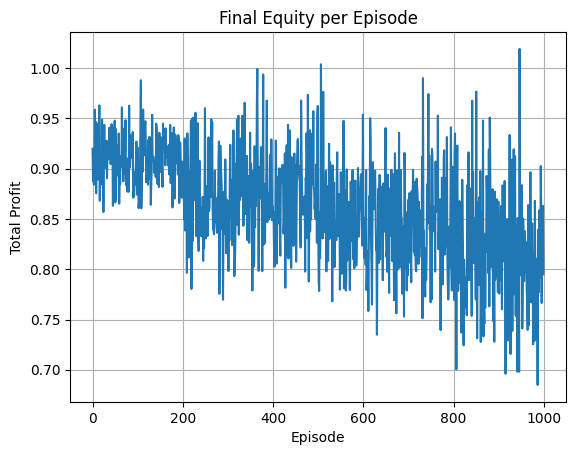

In [ ]:
plt.plot([curve[-1] for curve in equity_curves])
plt.title("Final Equity per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Profit")
plt.grid(True)
plt.show()


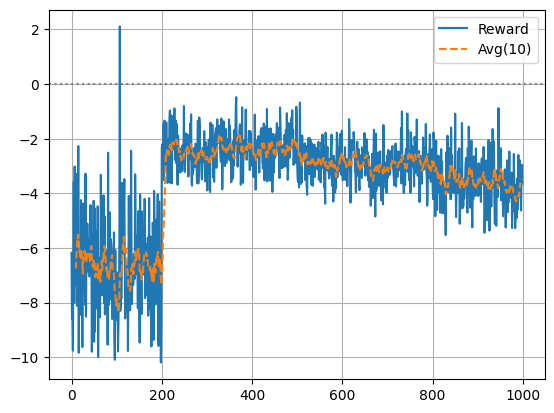

In [ ]:
plt.plot(month_rewards, label='Reward')
plt.plot(pd.Series(month_rewards).rolling(10).mean(), '--', label='Avg(10)')
plt.axhline(0, color='grey', ls=':')
plt.legend(); plt.grid(True); plt.show()

As we can see the assumption isnt correct . This could be because in longer windows (later phases) the rewards are delayed -> making it harder for the agent to assign credit to actions and Sharpe like scaling Can over penalize (sigma = sigma *rootT )


# Improvements made based on previous learning

-  KL penalty annealing was introduced by smoothly decreasing beta_kl over time to allow the agent to explore safely in early episodes and then exploit confidently in later s is more adaptive than using a fixed penalty.
-  a greedy action policy is triggered after episode 800- > replacing stochastic sampling with argmax action selection and effectively scheduling an exploration-to-exploitation shift.

- The reward function itself was refined with volatility smoothing, a sigma floor and sharpe scaling, ensuring that the denominator is always stable and that excessive reward swings from noisy equity curves are prevented
-and at every 50 episodes, a greedy evaluation phase is run to measure how well the learned policy performs without updating G-values—mimicking real-world deployment.
- diagnostic logging is restricted to every 25 episodes or when reward drops below ‑4, cutting down on clutter while still highlighting crucial learning signals





```
reward = log_return / smooth_sigma - annealed_kl * KL(pi || pi_ref)
if profit > 0.99:
    reward += 0.10
reward = max(reward, -3.0)
```

- This shaped reward incentivizes steady and low-risk gains and controlled policy deviation
- This helps makethe learning process both safer and more scalable over time.


In [ ]:
episodes     = 1000
short_T      = 21
long_T       = 60
baseline_s   = 0.98
baseline_l   = 1.05
sigma_cap_s  = 0.20
sigma_cap_l  = 0.30

kl_beta0, kl_betaT = 0.02, 0.003
use_sharpe_scaling = True
alpha, gamma, tau  = 0.1, 0.99, 1.0
greedy_start       = 800       # exploit after this ep
diag_every         = 25
sigma_floor        = 1e-3

ACTIONS = [0, 1]
G       = defaultdict(lambda: np.zeros(len(ACTIONS)))
pi_ref  = np.array([0.5, 0.5])

def softmax_g(state):
    g = G[state]
    p = np.exp(-g / tau)
    return p / p.sum()

def kl_div(p, q):
    return np.sum(p * (np.log(p + 1e-9) - np.log(q + 1e-9)))

def compute_reward(profit, equity_window, baseline, beta_kl, T, pi, pi_ref):
    log_ret = np.log(max(profit, 1e-9) / baseline)

    sigma   = max(np.std(np.diff(equity_window)) + 1e-6, sigma_floor)
    if use_sharpe_scaling:
        sigma *= np.sqrt(T)
    sigma = np.log1p(np.exp(sigma))

    raw_sharpe = log_ret / sigma
    kl_penalty = beta_kl * kl_div(pi, pi_ref)
    reward     = raw_sharpe - kl_penalty

    if profit > 0.99:
        reward += 0.10

    reward = max(reward, -3.0)
    return reward, log_ret, sigma, kl_penalty

def encode(tick, obs):
    tri = lambda x: 2 if x > 0 else 0 if x < 0 else 1
    trend   = tri(sma_f.iloc[tick] - sma_s.iloc[tick])
    rsi_bin = 0 if rsi.iloc[tick] < 30 else 2 if rsi.iloc[tick] > 70 else 1
    macd_s  = tri(macd.iloc[tick])
    bb_bin  = pd.qcut(bb_width.iloc[:tick+1], 3, labels=False).iloc[-1]
    delta_p = obs[-1,0] - obs[-2,0] if obs.shape[0] >= 2 else 0.0
    pos     = tri(delta_p)
    return (trend, rsi_bin, macd_s, bb_bin, pos)

equity_curves, month_rewards = [], []
pbar = tqdm(range(episodes), desc="Training G‑Learning")

for ep in pbar:
    if ep < 200:
        month_len, baseline, sigma_cap = short_T, baseline_s, sigma_cap_s
    else:
        month_len, baseline, sigma_cap = long_T, baseline_l, sigma_cap_l

    obs, _ = env_raw.reset()
    equity = [env_raw.unwrapped._total_profit]

    for t in range(month_len):
        s  = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s)

        if ep >= greedy_start:
            a = np.argmax(pi)
        else:
            a = np.random.choice(ACTIONS, p=pi)

        obs, _, terminated, truncated, _ = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g   = softmax_g(s_next) @ G[s_next]

        end_window = (t == month_len - 1)
        episode_end = terminated or truncated

        if end_window or episode_end:
            profit   = env_raw.unwrapped._total_profit
            eq_slice = equity[-month_len:] if len(equity) >= month_len else equity
            beta_kl  = kl_beta0 - (kl_beta0 - kl_betaT) * (ep / episodes)

            reward, lr, sig, klv = compute_reward(
                profit, eq_slice, baseline, beta_kl,
                month_len, pi, pi_ref
            )

            G[s][a] = (1 - alpha) * G[s][a] + alpha * (reward + gamma * Ea_g)
            month_rewards.append(reward)

            if (ep % diag_every == 0) or (reward < -4):
                print(f"[Diag] Ep {ep+1}, Profit {profit:.3f}, "
                      f"LogRet {lr:.4f}, σ {sig:.4f}, KLpen {klv:.4f}, "
                      f"β {beta_kl:.4f}, Rew {reward:.3f}")

        if episode_end:
            break

    equity_curves.append(equity)

    if ep % 50 == 0:
        obs_eval, _ = env_raw.reset()
        for _ in range(month_len):
            s_eval = encode(env_raw.unwrapped._current_tick, obs_eval)
            a_eval = np.argmax(softmax_g(s_eval))
            obs_eval, _, done_eval, _, _ = env_raw.step(a_eval)
            if done_eval:
                break
        print(f"[Greedy Eval] Ep {ep+1} profit: {env_raw.unwrapped._total_profit:.3f}")

    last_r = month_rewards[-1]
    pbar.set_description(f"Ep {ep+1} | R: {last_r:.3f}")
    if len(month_rewards) >= 10 and (ep % diag_every == 0):
        print(f"Ep {ep+1} | Avg(10): {np.mean(month_rewards[-10:]):.3f}")


Ep 3 | R: -0.253:   0%|          | 1/1000 [00:00<01:59,  8.37it/s]

[Diag] Ep 1, Profit 0.942, LogRet -0.0398, σ 0.7197, KLpen 0.0000, β 0.0200, Rew -0.055
[Greedy Eval] Ep 1 profit: 1.000


Ep 29 | R: -0.062:   3%|▎         | 28/1000 [00:01<00:51, 18.81it/s]

[Diag] Ep 26, Profit 0.873, LogRet -0.1151, σ 0.7277, KLpen 0.0000, β 0.0196, Rew -0.158
Ep 26 | Avg(10): -0.133


Ep 54 | R: -0.134:   5%|▌         | 54/1000 [00:03<00:56, 16.69it/s]

[Diag] Ep 51, Profit 0.887, LogRet -0.1000, σ 0.7200, KLpen 0.0000, β 0.0192, Rew -0.139
[Greedy Eval] Ep 51 profit: 1.000
Ep 51 | Avg(10): -0.134


Ep 79 | R: -0.153:   8%|▊         | 78/1000 [00:04<00:49, 18.53it/s]

[Diag] Ep 76, Profit 0.968, LogRet -0.0124, σ 0.7086, KLpen 0.0000, β 0.0187, Rew -0.018
Ep 76 | Avg(10): -0.156


Ep 102 | R: -0.103:  10%|█         | 102/1000 [00:06<01:00, 14.77it/s]

[Diag] Ep 101, Profit 0.837, LogRet -0.1576, σ 0.7287, KLpen 0.0000, β 0.0183, Rew -0.216
[Greedy Eval] Ep 101 profit: 1.000
Ep 101 | Avg(10): -0.147


Ep 129 | R: -0.117:  13%|█▎        | 128/1000 [00:07<00:47, 18.33it/s]

[Diag] Ep 126, Profit 0.915, LogRet -0.0691, σ 0.7157, KLpen 0.0000, β 0.0179, Rew -0.097
Ep 126 | Avg(10): -0.101


Ep 154 | R: -0.264:  15%|█▌        | 154/1000 [00:09<00:53, 15.77it/s]

[Diag] Ep 151, Profit 0.805, LogRet -0.1963, σ 0.7297, KLpen 0.0000, β 0.0175, Rew -0.269
[Greedy Eval] Ep 151 profit: 1.000
Ep 151 | Avg(10): -0.151


Ep 179 | R: -0.086:  18%|█▊        | 178/1000 [00:10<00:46, 17.63it/s]

[Diag] Ep 176, Profit 0.878, LogRet -0.1097, σ 0.7314, KLpen 0.0000, β 0.0170, Rew -0.150
Ep 176 | Avg(10): -0.116


Ep 201 | R: -0.309:  20%|██        | 200/1000 [00:13<01:00, 13.16it/s]

[Diag] Ep 201, Profit 0.834, LogRet -0.2302, σ 0.7454, KLpen 0.0000, β 0.0166, Rew -0.309
[Greedy Eval] Ep 201 profit: 0.909
Ep 201 | Avg(10): -0.125


Ep 227 | R: -0.350:  23%|██▎       | 227/1000 [00:17<02:02,  6.30it/s]

[Diag] Ep 226, Profit 0.837, LogRet -0.2264, σ 0.7352, KLpen 0.0000, β 0.0162, Rew -0.308
Ep 226 | Avg(10): -0.348


Ep 251 | R: -0.344:  25%|██▌       | 251/1000 [00:21<02:14,  5.58it/s]

[Diag] Ep 251, Profit 0.814, LogRet -0.2543, σ 0.7399, KLpen 0.0000, β 0.0158, Rew -0.344
[Greedy Eval] Ep 251 profit: 1.000
Ep 251 | Avg(10): -0.306


Ep 277 | R: -0.300:  28%|██▊       | 277/1000 [00:26<02:19,  5.18it/s]

[Diag] Ep 276, Profit 0.775, LogRet -0.3035, σ 0.7282, KLpen 0.0000, β 0.0153, Rew -0.417
Ep 276 | Avg(10): -0.366


Ep 301 | R: -0.223:  30%|███       | 301/1000 [00:30<02:03,  5.67it/s]

[Diag] Ep 301, Profit 0.892, LogRet -0.1627, σ 0.7303, KLpen 0.0000, β 0.0149, Rew -0.223
[Greedy Eval] Ep 301 profit: 0.909
Ep 301 | Avg(10): -0.304


Ep 327 | R: -0.374:  33%|███▎      | 327/1000 [00:35<01:43,  6.48it/s]

[Diag] Ep 326, Profit 0.812, LogRet -0.2567, σ 0.7323, KLpen 0.0000, β 0.0145, Rew -0.351
Ep 326 | Avg(10): -0.275


Ep 351 | R: -0.194:  35%|███▌      | 351/1000 [00:39<02:07,  5.08it/s]

[Diag] Ep 351, Profit 0.911, LogRet -0.1415, σ 0.7304, KLpen 0.0000, β 0.0140, Rew -0.194
[Greedy Eval] Ep 351 profit: 1.000
Ep 351 | Avg(10): -0.346


Ep 377 | R: -0.373:  38%|███▊      | 377/1000 [00:44<01:46,  5.88it/s]

[Diag] Ep 376, Profit 0.831, LogRet -0.2343, σ 0.7290, KLpen 0.0000, β 0.0136, Rew -0.321
Ep 376 | Avg(10): -0.389


Ep 401 | R: -0.238:  40%|████      | 401/1000 [00:48<02:03,  4.86it/s]

[Diag] Ep 401, Profit 0.879, LogRet -0.1778, σ 0.7474, KLpen 0.0000, β 0.0132, Rew -0.238
[Greedy Eval] Ep 401 profit: 0.909
Ep 401 | Avg(10): -0.346


Ep 427 | R: -0.482:  43%|████▎     | 427/1000 [00:53<01:40,  5.70it/s]

[Diag] Ep 426, Profit 0.862, LogRet -0.1967, σ 0.7380, KLpen 0.0000, β 0.0128, Rew -0.267
Ep 426 | Avg(10): -0.326


Ep 451 | R: -0.126:  45%|████▌     | 451/1000 [00:57<01:56,  4.73it/s]

[Diag] Ep 451, Profit 0.957, LogRet -0.0928, σ 0.7390, KLpen 0.0000, β 0.0123, Rew -0.126
[Greedy Eval] Ep 451 profit: 0.909
Ep 451 | Avg(10): -0.364


Ep 477 | R: -0.351:  48%|████▊     | 477/1000 [01:01<01:19,  6.57it/s]

[Diag] Ep 476, Profit 0.787, LogRet -0.2886, σ 0.7378, KLpen 0.0000, β 0.0119, Rew -0.391
Ep 476 | Avg(10): -0.291


Ep 501 | R: -0.326:  50%|█████     | 501/1000 [01:06<01:34,  5.30it/s]

[Diag] Ep 501, Profit 0.826, LogRet -0.2401, σ 0.7360, KLpen 0.0000, β 0.0115, Rew -0.326
[Greedy Eval] Ep 501 profit: 0.909
Ep 501 | Avg(10): -0.336


Ep 527 | R: -0.479:  53%|█████▎    | 527/1000 [01:10<01:14,  6.37it/s]

[Diag] Ep 526, Profit 0.853, LogRet -0.2080, σ 0.7255, KLpen 0.0000, β 0.0111, Rew -0.287
Ep 526 | Avg(10): -0.325


Ep 551 | R: -0.191:  55%|█████▌    | 551/1000 [01:14<01:32,  4.86it/s]

[Diag] Ep 551, Profit 0.913, LogRet -0.1400, σ 0.7337, KLpen 0.0000, β 0.0106, Rew -0.191
[Greedy Eval] Ep 551 profit: 0.909
Ep 551 | Avg(10): -0.342


Ep 577 | R: -0.461:  58%|█████▊    | 577/1000 [01:19<01:06,  6.34it/s]

[Diag] Ep 576, Profit 0.786, LogRet -0.2899, σ 0.7385, KLpen 0.0000, β 0.0102, Rew -0.392
Ep 576 | Avg(10): -0.359


Ep 601 | R: -0.319:  60%|██████    | 601/1000 [01:23<01:11,  5.60it/s]

[Diag] Ep 601, Profit 0.829, LogRet -0.2360, σ 0.7394, KLpen 0.0000, β 0.0098, Rew -0.319
[Greedy Eval] Ep 601 profit: 0.909
Ep 601 | Avg(10): -0.320


Ep 627 | R: -0.274:  63%|██████▎   | 626/1000 [01:28<01:20,  4.62it/s]

[Diag] Ep 626, Profit 0.763, LogRet -0.3194, σ 0.7422, KLpen 0.0000, β 0.0094, Rew -0.430
Ep 626 | Avg(10): -0.381


Ep 651 | R: -0.327:  65%|██████▌   | 651/1000 [01:32<01:01,  5.71it/s]

[Diag] Ep 651, Profit 0.823, LogRet -0.2430, σ 0.7427, KLpen 0.0000, β 0.0089, Rew -0.327
[Greedy Eval] Ep 651 profit: 1.000
Ep 651 | Avg(10): -0.361


Ep 676 | R: -0.415:  68%|██████▊   | 676/1000 [01:36<00:49,  6.53it/s]

[Diag] Ep 676, Profit 0.777, LogRet -0.3012, σ 0.7255, KLpen 0.0000, β 0.0085, Rew -0.415
Ep 676 | Avg(10): -0.325


Ep 701 | R: -0.302:  70%|███████   | 701/1000 [01:41<01:11,  4.18it/s]

[Diag] Ep 701, Profit 0.840, LogRet -0.2230, σ 0.7377, KLpen 0.0000, β 0.0081, Rew -0.302
[Greedy Eval] Ep 701 profit: 1.000
Ep 701 | Avg(10): -0.381


Ep 727 | R: -0.328:  73%|███████▎  | 727/1000 [01:46<00:45,  5.94it/s]

[Diag] Ep 726, Profit 0.773, LogRet -0.3064, σ 0.7431, KLpen 0.0000, β 0.0077, Rew -0.412
Ep 726 | Avg(10): -0.326


Ep 751 | R: -0.377:  75%|███████▌  | 751/1000 [01:50<00:49,  5.02it/s]

[Diag] Ep 751, Profit 0.796, LogRet -0.2766, σ 0.7340, KLpen 0.0000, β 0.0072, Rew -0.377
[Greedy Eval] Ep 751 profit: 1.000
Ep 751 | Avg(10): -0.350


Ep 776 | R: -0.397:  78%|███████▊  | 776/1000 [01:55<00:55,  4.07it/s]

[Diag] Ep 776, Profit 0.784, LogRet -0.2922, σ 0.7355, KLpen 0.0000, β 0.0068, Rew -0.397
Ep 776 | Avg(10): -0.324


Ep 801 | R: 0.030:  80%|████████  | 801/1000 [01:59<00:40,  4.96it/s]

[Diag] Ep 801, Profit 1.000, LogRet -0.0488, σ 0.6970, KLpen 0.0000, β 0.0064, Rew 0.030
[Greedy Eval] Ep 801 profit: 1.000
Ep 801 | Avg(10): -0.328


Ep 827 | R: -0.197:  83%|████████▎ | 827/1000 [02:03<00:28,  6.12it/s]

[Diag] Ep 826, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0060, Rew -0.197
Ep 826 | Avg(10): -0.197


Ep 851 | R: -0.197:  85%|████████▌ | 851/1000 [02:08<00:32,  4.54it/s]

[Diag] Ep 851, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0055, Rew -0.197
[Greedy Eval] Ep 851 profit: 0.909
Ep 851 | Avg(10): -0.197


Ep 877 | R: -0.197:  88%|████████▊ | 877/1000 [02:12<00:20,  6.09it/s]

[Diag] Ep 876, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0051, Rew -0.197
Ep 876 | Avg(10): -0.197


Ep 901 | R: -0.197:  90%|█████████ | 901/1000 [02:16<00:19,  5.11it/s]

[Diag] Ep 901, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0047, Rew -0.197
[Greedy Eval] Ep 901 profit: 0.909
Ep 901 | Avg(10): -0.197


Ep 926 | R: -0.197:  93%|█████████▎| 926/1000 [02:21<00:13,  5.35it/s]

[Diag] Ep 926, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0043, Rew -0.197
Ep 926 | Avg(10): -0.197


Ep 951 | R: -0.197:  95%|█████████▌| 951/1000 [02:25<00:10,  4.85it/s]

[Diag] Ep 951, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0038, Rew -0.197
[Greedy Eval] Ep 951 profit: 0.909
Ep 951 | Avg(10): -0.197


Ep 977 | R: -0.197:  98%|█████████▊| 977/1000 [02:29<00:03,  6.17it/s]

[Diag] Ep 976, Profit 0.909, LogRet -0.1439, σ 0.7298, KLpen 0.0000, β 0.0034, Rew -0.197
Ep 976 | Avg(10): -0.197


Ep 1000 | R: -0.197: 100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


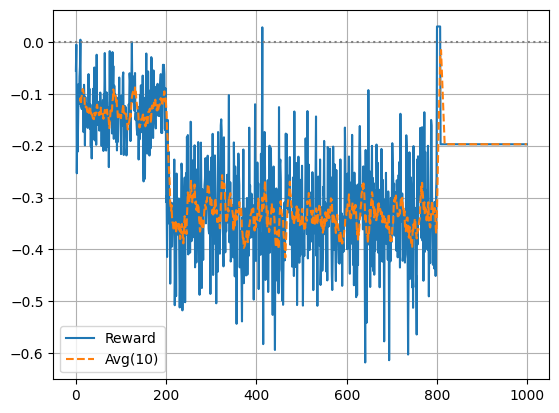

In [ ]:
plt.plot(month_rewards, label='Reward')
plt.plot(pd.Series(month_rewards).rolling(10).mean(), '--', label='Avg(10)')
plt.axhline(0, color='grey', ls=':')
plt.legend(); plt.grid(True); plt.show()

# Final improvements made!!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

episodes          = 1_000
short_T, mid_T, long_T = 21, 60, 90
baseline_s, baseline_m, baseline_l = 0.97, 1.03, 1.07
sigma_cap_s, sigma_cap_m, sigma_cap_l = 0.20, 0.30, 0.35

kl_beta0, kl_betaT = 0.02, 0.003
use_sharpe_scaling = True
alpha_default      = 0.05
gamma              = 0.99
tau                = 1.0
greedy_start       = 800
diag_every         = 25
sigma_floor        = 1e-3

ACTIONS = [0, 1]
G       = defaultdict(lambda: np.zeros(len(ACTIONS)))
pi_ref  = np.array([0.5, 0.5])

def safe_softmax(g_vec, temperature):
    g_vec = np.clip(g_vec, -50, 50)
    z     = (-g_vec - (-g_vec).max()) / max(temperature, 1e-3)
    exp_z = np.exp(np.clip(z, -700, 700))
    p     = exp_z / exp_z.sum()
    if not np.isfinite(p).all():
        p = np.full_like(p, 1.0 / len(p))
    return p

def softmax_g(state, temperature):
    return safe_softmax(G[state], temperature)

def kl_div(p, q):
    return np.sum(p * (np.log(p + 1e-9) - np.log(q + 1e-9)))

def compute_reward(profit, equity_window, baseline, beta_kl, T, pi):
    log_ret = np.log(max(profit, 1e-9) / baseline)
    sigma   = max(np.std(np.diff(equity_window)) + 1e-6, sigma_floor)
    if use_sharpe_scaling:
        sigma *= np.sqrt(T)
    sigma   = np.log(sigma + 1)
    reward  = (log_ret / sigma) - beta_kl * kl_div(pi, pi_ref)
    if profit > 0.99:
        reward += 0.10
    return max(reward, -3.0), log_ret, sigma

def encode(tick, obs):
    tri = lambda x: 2 if x > 0 else 0 if x < 0 else 1
    trend   = tri(sma_f.iloc[tick] - sma_s.iloc[tick])
    rsi_bin = 0 if rsi.iloc[tick] < 30 else 2 if rsi.iloc[tick] > 70 else 1
    macd_s  = tri(macd.iloc[tick])
    bb_bin  = pd.qcut(bb_width.iloc[:tick+1], 3, labels=False).iloc[-1]
    delta_p = obs[-1, 0] - obs[-2, 0] if obs.shape[0] >= 2 else 0.0
    pos     = tri(delta_p)
    mom_raw = price.iloc[tick] - price.iloc[max(0, tick-5)]
    mom_bin = tri(mom_raw)
    return (trend, rsi_bin, macd_s, bb_bin, pos, mom_bin)

equity_curves, month_rewards = [], []
pbar = tqdm(range(episodes), desc="Training G‑Learning")

for ep in pbar:
    tau = max(0.20, tau * 0.995)

    if ep < 200:
        month_len, baseline, sigma_cap = short_T, baseline_s, sigma_cap_s
    elif ep < 600:
        month_len, baseline, sigma_cap = mid_T, baseline_m, sigma_cap_m
    else:
        month_len, baseline, sigma_cap = long_T, baseline_l, sigma_cap_l

    obs, _ = env_raw.reset()
    equity     = [env_raw.unwrapped._total_profit]
    local_high = equity[0]

    for t in range(month_len):
        s  = encode(env_raw.unwrapped._current_tick, obs)
        pi = softmax_g(s, tau)

        if ep >= greedy_start:
            a = np.argmax(pi)
        else:
            a = np.random.choice(ACTIONS, p=(pi + 1e-12) / (pi + 1e-12).sum())

        obs, _, terminated, truncated, _ = env_raw.step(a)
        equity.append(env_raw.unwrapped._total_profit)
        local_high = max(local_high, equity[-1])

        s_next = encode(env_raw.unwrapped._current_tick, obs)
        Ea_g   = softmax_g(s_next, tau) @ G[s_next]

        if (t == month_len - 1) or terminated or truncated:
            profit   = env_raw.unwrapped._total_profit
            eq_slice = equity[-month_len:] if len(equity) >= month_len else equity
            beta_kl  = kl_beta0 - (kl_beta0 - kl_betaT) * (ep / episodes)

            reward, lr, sig = compute_reward(
                profit, eq_slice, baseline, beta_kl, month_len, pi
            )

            if profit >= local_high:
                reward += 0.05

            alpha_t = 0.2 if reward < -1 else alpha_default
            G[s][a] = (1 - alpha_t) * G[s][a] + alpha_t * (reward + gamma * Ea_g)
            month_rewards.append(reward)

            if (ep % diag_every == 0) or (reward < -4):
                print(f"[Diag] Ep {ep+1}, LogRet {lr:.4f}, σ {sig:.4f}, "
                      f"β {beta_kl:.4f}, New Rew {reward:.3f}")

            if terminated or truncated:
                break

    equity_curves.append(equity)

    if ep % 50 == 0:
        obs_eval, _ = env_raw.reset()
        for _ in range(month_len):
            s_eval = encode(env_raw.unwrapped._current_tick, obs_eval)
            a_eval = np.argmax(softmax_g(s_eval, tau))
            obs_eval, _, done_eval, _, _ = env_raw.step(a_eval)
            if done_eval:
                break
        print(f"[Greedy Eval] Ep {ep+1} profit: {env_raw.unwrapped._total_profit:.3f}")

    last_r = month_rewards[-1]
    pbar.set_description(f"Ep {ep+1} | R: {last_r:.3f}")
    if len(month_rewards) >= 10 and (ep % diag_every == 0):
        print(f"Ep {ep+1} | Avg(10): {np.mean(month_rewards[-10:]):.3f}")


Ep 4 | R: -1.003:   0%|          | 4/1000 [00:00<00:57, 17.42it/s]

[Diag] Ep 1, Bonus 0.83, LogRet -0.1455, σ 0.0656, β 0.0200, New Rew -1.384
[Greedy Eval] Ep 1 profit: 1.000


Ep 28 | R: 0.008:   3%|▎         | 28/1000 [00:01<01:12, 13.35it/s]

[Diag] Ep 26, Bonus 1.04, LogRet -0.1036, σ 0.0647, β 0.0196, New Rew -0.562
Ep 26 | Avg(10): -0.155


Ep 54 | R: -0.269:   5%|▌         | 54/1000 [00:03<00:58, 16.15it/s]

[Diag] Ep 51, Bonus 1.26, LogRet -0.0261, σ 0.0359, β 0.0192, New Rew 0.532
[Greedy Eval] Ep 51 profit: 1.000
Ep 51 | Avg(10): -0.045


Ep 79 | R: -0.858:   8%|▊         | 78/1000 [00:05<00:48, 18.87it/s]

[Diag] Ep 76, Bonus 1.18, LogRet -0.0535, σ 0.0488, β 0.0187, New Rew 0.086
Ep 76 | Avg(10): -0.122


Ep 104 | R: -0.570:  10%|█         | 104/1000 [00:06<00:50, 17.60it/s]

[Diag] Ep 101, Bonus 2.00, LogRet -0.0960, σ 0.0550, β 0.0183, New Rew 0.249
[Greedy Eval] Ep 101 profit: 1.000
Ep 101 | Avg(10): -0.196


Ep 129 | R: -0.684:  13%|█▎        | 128/1000 [00:07<00:47, 18.25it/s]

[Diag] Ep 126, Bonus 1.85, LogRet -0.1666, σ 0.0641, β 0.0179, New Rew -0.751
Ep 126 | Avg(10): -0.037


Ep 154 | R: 0.527:  15%|█▌        | 154/1000 [00:09<00:47, 17.98it/s]

[Diag] Ep 151, Bonus 1.93, LogRet -0.0594, σ 0.0479, β 0.0175, New Rew 0.692
[Greedy Eval] Ep 151 profit: 1.000
Ep 151 | Avg(10): 0.246


Ep 179 | R: 1.000:  18%|█▊        | 178/1000 [00:10<00:44, 18.36it/s]

[Diag] Ep 176, Bonus 0.96, LogRet -0.0462, σ 0.0463, β 0.0170, New Rew -0.041
Ep 176 | Avg(10): 0.131


Ep 201 | R: 1.429:  20%|██        | 200/1000 [00:11<00:42, 18.71it/s] 

[Diag] Ep 201, Bonus 3.46, LogRet -0.1602, σ 0.0787, β 0.0166, New Rew 1.429
[Greedy Eval] Ep 201 profit: 0.946
Ep 201 | Avg(10): 0.119


Ep 227 | R: 0.496:  23%|██▎       | 227/1000 [00:16<02:05,  6.14it/s]

[Diag] Ep 226, Bonus 3.76, LogRet -0.2488, σ 0.0753, β 0.0162, New Rew 0.759
Ep 226 | Avg(10): 1.034


Ep 251 | R: 1.445:  25%|██▌       | 251/1000 [00:20<02:11,  5.68it/s]

[Diag] Ep 251, Bonus 3.37, LogRet -0.1668, σ 0.0868, β 0.0158, New Rew 1.445
[Greedy Eval] Ep 251 profit: 1.004
Ep 251 | Avg(10): 0.969


Ep 277 | R: 0.932:  28%|██▊       | 277/1000 [00:24<01:49,  6.59it/s]

[Diag] Ep 276, Bonus 3.85, LogRet -0.2357, σ 0.0840, β 0.0153, New Rew 1.048
Ep 276 | Avg(10): 1.009


Ep 301 | R: 0.670:  30%|███       | 301/1000 [00:28<02:53,  4.02it/s]

[Diag] Ep 301, Bonus 3.67, LogRet -0.3630, σ 0.0756, β 0.0149, New Rew 0.670
[Greedy Eval] Ep 301 profit: 0.946
Ep 301 | Avg(10): 0.840


Ep 327 | R: 1.755:  33%|███▎      | 327/1000 [00:32<01:41,  6.65it/s]

[Diag] Ep 326, Bonus 3.21, LogRet -0.2448, σ 0.0722, β 0.0145, New Rew 0.205
Ep 326 | Avg(10): 1.033


Ep 351 | R: 0.471:  35%|███▌      | 351/1000 [00:36<01:56,  5.55it/s]

[Diag] Ep 351, Bonus 3.47, LogRet -0.2724, σ 0.0843, β 0.0140, New Rew 0.471
[Greedy Eval] Ep 351 profit: 0.946
Ep 351 | Avg(10): 0.881


Ep 376 | R: 0.388:  38%|███▊      | 376/1000 [00:40<02:07,  4.88it/s]

[Diag] Ep 376, Bonus 3.39, LogRet -0.3079, σ 0.0766, β 0.0136, New Rew 0.388
Ep 376 | Avg(10): 0.815


Ep 401 | R: 0.092:  40%|████      | 401/1000 [00:44<01:42,  5.87it/s]

[Diag] Ep 401, Bonus 3.09, LogRet -0.2358, σ 0.0749, β 0.0132, New Rew 0.092
[Greedy Eval] Ep 401 profit: 0.946
Ep 401 | Avg(10): 0.857


Ep 427 | R: 0.907:  43%|████▎     | 427/1000 [00:48<01:24,  6.79it/s]

[Diag] Ep 426, Bonus 3.48, LogRet -0.1436, σ 0.0828, β 0.0128, New Rew 1.744
Ep 426 | Avg(10): 1.268


Ep 451 | R: 1.026:  45%|████▌     | 451/1000 [00:52<02:00,  4.57it/s]

[Diag] Ep 451, Bonus 3.71, LogRet -0.2308, σ 0.0861, β 0.0123, New Rew 1.026
[Greedy Eval] Ep 451 profit: 0.946
Ep 451 | Avg(10): 0.918


Ep 477 | R: 0.218:  48%|████▊     | 477/1000 [00:56<01:18,  6.66it/s]

[Diag] Ep 476, Bonus 3.31, LogRet -0.1419, σ 0.0668, β 0.0119, New Rew 1.188
Ep 476 | Avg(10): 1.117


Ep 501 | R: 0.394:  50%|█████     | 501/1000 [01:00<01:26,  5.74it/s]

[Diag] Ep 501, Bonus 3.39, LogRet -0.2961, σ 0.0777, β 0.0115, New Rew 0.394
[Greedy Eval] Ep 501 profit: 0.946
Ep 501 | Avg(10): 0.549


Ep 527 | R: 0.095:  53%|█████▎    | 526/1000 [01:04<01:26,  5.49it/s]

[Diag] Ep 526, Bonus 3.54, LogRet -0.1367, σ 0.0632, β 0.0111, New Rew 1.374
Ep 526 | Avg(10): 1.043


Ep 551 | R: 0.893:  55%|█████▌    | 551/1000 [01:08<01:16,  5.88it/s]

[Diag] Ep 551, Bonus 3.89, LogRet -0.3823, σ 0.0923, β 0.0106, New Rew 0.893
[Greedy Eval] Ep 551 profit: 1.004
Ep 551 | Avg(10): 0.779


Ep 577 | R: 0.973:  58%|█████▊    | 577/1000 [01:12<01:03,  6.64it/s]

[Diag] Ep 576, Bonus 3.53, LogRet -0.1945, σ 0.0787, β 0.0102, New Rew 1.053
Ep 576 | Avg(10): 0.948


Ep 601 | R: 0.263:  60%|██████    | 601/1000 [01:16<01:21,  4.88it/s]

[Diag] Ep 601, Bonus 3.26, LogRet -0.3191, σ 0.0750, β 0.0098, New Rew 0.263
[Greedy Eval] Ep 601 profit: 0.901
Ep 601 | Avg(10): 0.859


Ep 626 | R: 0.932:  63%|██████▎   | 626/1000 [01:22<01:20,  4.67it/s]

[Diag] Ep 626, Bonus 3.93, LogRet -0.3913, σ 0.0764, β 0.0094, New Rew 0.932
Ep 626 | Avg(10): 0.684


Ep 651 | R: 0.031:  65%|██████▌   | 651/1000 [01:28<01:28,  3.95it/s]

[Diag] Ep 651, Bonus 3.03, LogRet -0.2705, σ 0.0862, β 0.0089, New Rew 0.031
[Greedy Eval] Ep 651 profit: 0.930
Ep 651 | Avg(10): 0.582


Ep 676 | R: 0.389:  68%|██████▊   | 676/1000 [01:34<01:16,  4.24it/s]

[Diag] Ep 676, Bonus 3.39, LogRet -0.3043, σ 0.0992, β 0.0085, New Rew 0.389
Ep 676 | Avg(10): 0.744


Ep 701 | R: 2.232:  70%|███████   | 701/1000 [01:40<01:17,  3.86it/s]

[Diag] Ep 701, Bonus 3.84, LogRet -0.1611, σ 0.1000, β 0.0081, New Rew 2.232
[Greedy Eval] Ep 701 profit: 0.901
Ep 701 | Avg(10): 1.314


Ep 726 | R: 0.864:  73%|███████▎  | 726/1000 [01:46<01:01,  4.48it/s]

[Diag] Ep 726, Bonus 3.86, LogRet -0.3777, σ 0.1018, β 0.0077, New Rew 0.864
Ep 726 | Avg(10): 0.737


Ep 751 | R: 0.596:  75%|███████▌  | 751/1000 [01:52<01:04,  3.86it/s]

[Diag] Ep 751, Bonus 3.60, LogRet -0.3908, σ 0.0804, β 0.0072, New Rew 0.596
[Greedy Eval] Ep 751 profit: 0.901
Ep 751 | Avg(10): 0.413


Ep 776 | R: 0.716:  78%|███████▊  | 776/1000 [01:58<00:51,  4.31it/s]

[Diag] Ep 776, Bonus 3.72, LogRet -0.4472, σ 0.0839, β 0.0068, New Rew 0.716
Ep 776 | Avg(10): 0.575


Ep 801 | R: 0.419:  80%|████████  | 801/1000 [02:04<00:50,  3.97it/s]

[Diag] Ep 801, Bonus 3.42, LogRet -0.1714, σ 0.0541, β 0.0064, New Rew 0.419
[Greedy Eval] Ep 801 profit: 0.901
Ep 801 | Avg(10): 0.442


Ep 826 | R: 0.550:  83%|████████▎ | 826/1000 [02:10<00:41,  4.16it/s]

[Diag] Ep 826, Bonus 3.55, LogRet -0.1714, σ 0.0541, β 0.0060, New Rew 0.550
Ep 826 | Avg(10): 0.488


Ep 851 | R: 0.747:  85%|████████▌ | 851/1000 [02:16<00:36,  4.05it/s]

[Diag] Ep 851, Bonus 3.75, LogRet -0.1714, σ 0.0541, β 0.0055, New Rew 0.747
[Greedy Eval] Ep 851 profit: 0.901
Ep 851 | Avg(10): 0.650


Ep 876 | R: 0.939:  88%|████████▊ | 876/1000 [02:22<00:36,  3.42it/s]

[Diag] Ep 876, Bonus 3.94, LogRet -0.1714, σ 0.0541, β 0.0051, New Rew 0.939
Ep 876 | Avg(10): 0.711


Ep 901 | R: 0.409:  90%|█████████ | 901/1000 [02:27<00:24,  4.00it/s]

[Diag] Ep 901, Bonus 3.41, LogRet -0.1714, σ 0.0541, β 0.0047, New Rew 0.409
[Greedy Eval] Ep 901 profit: 0.901
Ep 901 | Avg(10): 0.526


Ep 926 | R: 0.187:  93%|█████████▎| 926/1000 [02:33<00:20,  3.57it/s]

[Diag] Ep 926, Bonus 3.19, LogRet -0.1714, σ 0.0541, β 0.0043, New Rew 0.187
Ep 926 | Avg(10): 0.331


Ep 951 | R: 0.341:  95%|█████████▌| 951/1000 [02:39<00:12,  3.91it/s]

[Diag] Ep 951, Bonus 3.34, LogRet -0.1714, σ 0.0541, β 0.0038, New Rew 0.341
[Greedy Eval] Ep 951 profit: 0.901
Ep 951 | Avg(10): 0.377


Ep 976 | R: 0.968:  98%|█████████▊| 976/1000 [02:45<00:05,  4.01it/s]

[Diag] Ep 976, Bonus 3.97, LogRet -0.1714, σ 0.0541, β 0.0034, New Rew 0.968
Ep 976 | Avg(10): 0.538


Ep 1000 | R: 0.006: 100%|██████████| 1000/1000 [02:51<00:00,  5.84it/s]


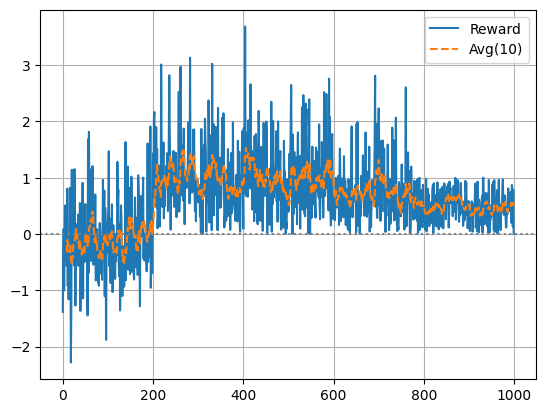

In [ ]:
plt.plot(month_rewards, label='Reward')
plt.plot(pd.Series(month_rewards).rolling(10).mean(), '--', label='Avg(10)')
plt.axhline(0, color='grey', ls=':')
plt.legend(); plt.grid(True); plt.show()

- In this final version of the G-learning algorithm, several strategic improvements were introduced to enhance training stability policy robustness and reward reliability.
- First i used a three-phase curriculum (short, mid, long horizon)-> which provides a smoother transition in learning complexity helping the agent gradually adapt to longer term planning without sudden jumps
- a safe softmax with clipping ensures numerical stability when action preferences become extreme  preventing issues like NaNs during training
- A decaying temperature gradually shifts the policy from exploration to exploitation->promoting safer early learning and more confident decision-making later
-  On the reward-> adaptive learning rates respond to poor performance by temporarily increasing the update rate =, helping the agent recover faster from bad strategies.
-  bonus rewards were added for achieving breakeven profit and surpassing the local high reinforcing safe trading behavior and continual improvement





